In [1]:
# the building we want to run
building_id = 2
# Price of the panel
price = 106
# this will create a folder which will save the files
iteration = 31
# optimization method
# Currently implemented are: rbf-net, rbf-cost, ga-50, ga-20
opt_method = "rbf-cost"
# Number of evaluations:
number_of_opt_evaluations = 100
# number of run
run_i=2
# Some cluster solution
base_path=""

In [2]:
# Parameters
opt_method = "ga-100"
number_of_opt_evaluations = 200
run_i = 0


In [3]:
# Important file names 
# This is where the optimal solution or final population of solutions is provided
ga_file = "panel_{}_{}_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# here we store every run that optmizer runs
ga_proc = "panel_{}_{}_archive_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)
# Here we combine the optimal solution with the addition information that we are interested in.
ga_fina = "panel_{}_{}_processed_{}_{}.xlsx".format(price,opt_method,number_of_opt_evaluations,run_i)

In [4]:
############ INPUT FILES  ##############
buildings = ['RefBldgLargeOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgMediumOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf',
            'RefBldgWarehouseNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf']

b_name = ['LargeOffice',
         'MediumOffice',
         'SmallOffice',
         'Warehouse']

idf_file   = base_path+'energy_plus/input_building/idf/upgraded/' + buildings[building_id]
# GA
ga_output_dir = base_path+'ga/bc/' + b_name[building_id] + '/{}/'.format(iteration)
ga_file=ga_output_dir+ga_file
ga_proc=ga_output_dir+ga_proc
ga_fina=ga_output_dir+ga_fina



# Weather file
epw_file   = base_path+'energy_plus/input_building/epw/' + 'CAN_BC_Vancouver.718920_CWEC.epw'

# EnergyHub
ehub_file  = base_path+'ehub/input_ehub_excel/' + 'bc_three.xlsx'
number_of_panels = 3



In [5]:
########### OUTPUT FILES ###############
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)


# EnergyPlus
output_dir = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
error_dir  = base_path+'energy_plus/output_energy_plus/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(output_dir)

# EHUB
ehub_dir   = base_path+'ehub/output_ehub_excel/' + "{}-{}-{}/".format(opt_method,number_of_opt_evaluations,run_i)
ensure_dir(ehub_dir)
res_file   = ehub_dir + "bc_ehub_results.xlsx"
# PV FACTORS
rendered_files = base_path+"rendered_pv_factors/bc/"
ensure_dir(ga_output_dir)
# panel price 400, 200, 106


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
########### LIBRARIES ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, HTML
ep_path="/home/theochri/projects/def-revins/theochri/EnergyPlus/"

# (A) EnergyPlus - North Axis, Electricity & Roof Area

## Run the model:

In [8]:
from pv_model import pvBuilding
# Make the building object
pvbuilding = pvBuilding.PvBuilding(idf_file, out_dir=output_dir,
                                   epw_file=epw_file, err_dir=error_dir,ep_path=ep_path)

/home/theochri/projects/def-revins/theochri/EnergyPlus/


## the North Axis
The north axis gets grabbed automatically from the idf.

In [9]:
pvbuilding.North_Axis

0.0

In [10]:
pvbuilding.Building_Information


Building,
    Ref Bldg Small Office New2004_v1.3_5.0,    !- Name
    0.0,                      !- North Axis
    City,                     !- Terrain
    0.04,                     !- Loads Convergence Tolerance Value
    0.2,                      !- Temperature Convergence Tolerance Value
    FullInteriorAndExterior,    !- Solar Distribution
    25,                       !- Maximum Number of Warmup Days
    6;                        !- Minimum Number of Warmup Days

## Grab the hourly electricity data
Run the model and store the hourly electricity. 

In [11]:
# Determine the hourly electricity use
pvbuilding.run_ep(ep_path=ep_path)

EnergyPlus is found in the path: /home/theochri/projects/def-revins/theochri/EnergyPlus/


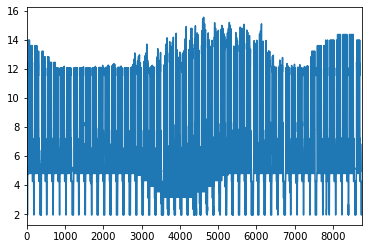

In [12]:
# Show the results in the hourly 
pvbuilding.hourly_electricity.plot()

In [13]:
pvbuilding.max_demand()
pvbuilding.monthly_peak_demand
print(float(pvbuilding.pre_winter_maximum))

The maximum demand charge is: $ 2,059.63
14.35220436334519


## Grab the Roof Area:
To get the roof area we need to feed the sql_file. 

In [14]:
pvbuilding.get_roof_details()
pvbuilding.p_roof_details()

Roof area is 599 m2
Roof area is up 29 m high


# (B) `pvfactors` - Irradience

We will now use pvfactors to find the yearly load of the panels placed at certain angles. Below is some details of how the to translate a panel to the pvfactors package. 


<img src="./images/Example_pvarray.png" alt=""
	title="A cute kitten" width="500" />
    
    
Given that the total area needed is specified by the gcr and the width of the panel:

$\mathrm(ground~area) = \frac{\mathrm(active~area)}{\mathrm(gcr)}$

In [15]:
from pv_model import pvFactors

# Build a pv panel that will live on the building.
pvpanel = pvFactors.PvPanel(rendered_files)
# Setup the Panel on the building. 
# Height of the building and the align the axis with the building
pvpanel.setup_array(pvbuilding)

Calculate the irradiance for a single panel.

ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.0560882091522217 sec


ERROR:root:Finished Generation of Irradiance


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.961317777633667 sec


ERROR:root:Finished Generation of Irradiance


0.0


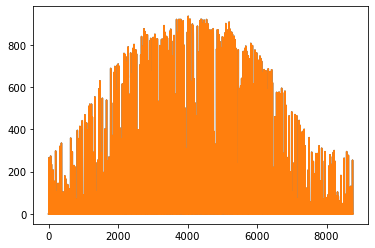

In [16]:
pan_vals = (215, 230, 245, 1, 26, 36, 0.3, 0.7499999999999998, 0.3)

irr1 = pvpanel.irradiance(100,1,0.25,force_recalc=False)
plt.plot(irr1);
type(irr1)
irr2 = pvpanel.irradiance(100,1,0.25,force_recalc=True)
plt.plot(irr2);
print(max(irr1-irr2))

# (C) EnergyHub - Cost and Capacity installed

## Model for BC


| **Name**                 | **Small**        | **Medium**              | **Large**                                            | **Details**                                                                                                                                                    |
| :----------------------- | :--------------- | :---------------------- | :--------------------------------------------------- | :------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Technical Constraint** | Demand \< 35kW   | Demand \>35kW \& \<150kW | Larger than \>150kW or Total energy use \>550,000kWh | Demand is the peak energy use in kW for each month.                                                                                                            |
| Basic Charge             | \$ 0.3645 /day    | \$ 0.2673 /day           | \$ 0.2673 /day                                        |                                                                                                                                                                |
| Demand Charge            | \-               | \$ 5.42/kW               | \$ 12.34/kW                                           | Based on the monthly peak load                                                                                                                                 |
| Energy Charge            | \$ 0.1253 /kWh    | \$ 0.0986 /kWh           | \$ 0.0606 /kWh                                        |                                                                                                                                                                |
| Minimum Charge           | The basic charge | The Minimum charge      | The Minimum Charge                                   | The mimimum charge is equal to 50% of highest winter months demand charge, if the sum of the basic, demand and energy charge is less than this minimum charge. |
| Power Factor Surcharge   | \-               | \-                      | \-                                                   | At low powerfactors                                                                                                                                            |
| Discounts                | \-               | \-                      | \-                                                   | Maintaining good power quality                                                                                                                                 |
| Taxes                    | \-               | \-                      | \-                                                   |                                                                                                                                                                |


(155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)
Loading the model
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (155, 175, 260, 26, 36, 36, 0.65, 0.7, 0.9)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 26.0
                                           and a gcr of 0.650


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.955129623413086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8668689727783203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 36.0
                                           and a gcr of 0.900


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8629157543182373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  22 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [307.537, 0.0, 0.0]


ERROR:ga_logger:Cost: 3187.57


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


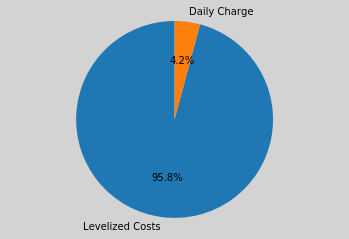

Total roof area of the  building: 599 m2
Total roof area used 473 m2
Percentage: 79.0%


In [17]:
from pv_model import pvModel
# this was the optimal solution
pan_vals = (155,175,260,26,36,36,0.65,0.7,0.9)
gcr=(0.65,0.7,0.9)
print(pan_vals)

# setup the gcr
area_per_panel = [pvpanel.pp['pvrow_depth']*pvpanel.pp['pvrow_width']/gcr[i] for i in range(number_of_panels)]
roof_area_per_unit_capacity = {"PV{}".format(i):area_per_panel[i]  for i in range(number_of_panels)}
# Here's where we instantiate our model. Nothing is solved at this point.

default_settings = {
                    'name': 'glpk-cluster',
                    'solver_path': '/home/theochri/ENV/bin/glpsol',
                    'options': {
                                'mipgap': 0.05,
                               },
                    }
# preload the excel
print("Loading the model")
my_model = pvModel.ModelBC(excel         = ehub_file,\
                           pvbuilding    = pvbuilding,\
                           resultsFile   = res_file,\
                           ROOF_AREA_CAP = roof_area_per_unit_capacity,
                           NUM_PANELS    = number_of_panels,
                           factor_multiplier=3,
                           solver_settings=default_settings)
my_model.eval_model(pan_vals,106,pvpanel)

After evaluating the model we can plot the results. This is a pie chart that breaks down the total cost into the off,on and mid peak costs. 

In [18]:
my_model.energyIm

61845.7

In [19]:
my_model.solveResults['solution']['demand_charge_c'].sum()

demand_charge_c    0.0
dtype: float64

In [20]:
print(my_model.solveResults['solution']['monthly_import'])
print(my_model.solveResults['solution']['monthly_import'].sum())
print(my_model.solveResults['solution']['total_import'])

print(my_model.solveResults['solution']['monthly_export'])
print(my_model.solveResults['solution']['monthly_export'].sum())
print(my_model.solveResults['solution']['total_export'])
print(my_model.solveResults['solution']['daily_charge_c'])


     monthly_import
Apr         4805.72
Aug         5680.08
Dec         5274.31
Feb         4713.95
Jan         5340.70
Jul         5200.48
Jun         5124.65
Mar         5319.26
May         5015.79
Nov         5153.19
Oct         5154.70
Sep         5062.88
monthly_import    61845.71
dtype: float64
61845.7
     monthly_export
Apr         6899.34
Aug         8061.75
Dec         1351.01
Feb         2744.22
Jan         1541.01
Jul         9311.54
Jun         7990.47
Mar         4415.47
May         8175.98
Nov         1793.90
Oct         3229.92
Sep         6330.97
monthly_export    61845.58
dtype: float64
61845.6
133.042


In [21]:
my_model.solveResults['solution']['daily_charge_c']

133.042

In [22]:
my_model.solveResults['solution']['is_installed']

is_installed
GreenEng             0
Grid                 1
Invertor             1
PV0                  1
PV1                  0
PV2                  0

In [23]:
my_model.solveResults['solution']['any_above_35']

0

In [24]:
my_model.solveResults['solution']['a150_or_a550']

0

# (D) GA - Optimize the model

In [25]:
from pv_model import pvOptimizer

range_azi  = range(90,270,5)
range_tilt = range(1,61,5)
range_gcr  = np.arange(0.2, .95, 0.05)

In [26]:
# preload the excel
from pyehub.excel_to_request_format import convert

request_format = convert(excel_file=ehub_file)

In [27]:
import logging
lrun       = logging.getLogger('Runs_logger')
hdlrun       = logging.FileHandler('runs_logger.txt')
formatterrun  = logging.Formatter('%(asctime)s %(message)s')
hdlrun.setFormatter(formatterrun)
lrun.addHandler(hdlrun) 
lrun.setLevel(logging.ERROR)

In [28]:
import time
t1=time.time()

pvoptimizer = pvOptimizer.PvOptimizer(range_azi=range_azi,
                         range_tilt=range_tilt,
                         range_gcr=range_gcr,
                         pvpanel=pvpanel,
                         price=price,
                         store_file=ga_file,
                         ehub_request=request_format,
                         res_file=res_file,
                         pvbuilding=pvbuilding,
                         roof_area_per_unit_capacity=roof_area_per_unit_capacity,
                         ga_proc=ga_proc,
                         solver_settings=default_settings)



ERROR:optimizer_logger:Found the solver set


/home/theochri/paper_pusher/lib/python3.6/site-packages/besos/evaluator.py:395: FutureWarning: EvaluatorSR has been renamed as EvaluatorGeneric with same functionaility. EvaluatorSR will be removed in a future release.
  warn(msg, FutureWarning)
ERROR:optimizer_logger:Started {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:0


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (254.08840358606923, 133.20988099428143, 206.45747290540143, 54.31816314839435, 35.70798041455403, 3.299855049966331, 0.2957707811157479, 0.6682777788336101, 0.7049240469735605)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 254
                                           a tilt of 54.3
                                           and a gcr of 0.296


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.010387420654297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 133
                                           a tilt of 35.7
                                           and a gcr of 0.668


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.853684425354004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 206
                                           a tilt of 3.3
                                           and a gcr of 0.705


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.700608253479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 328.315]


ERROR:ga_logger:Cost: 3393.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,394 per year


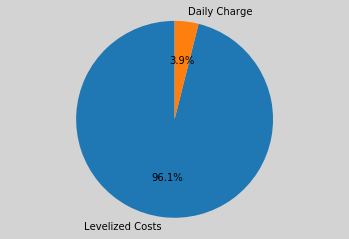

Total roof area of the  building: 599 m2
Total roof area used 466 m2
Percentage: 77.8%
succes
[[254.08840358606923, 133.20988099428143, 206.45747290540143, 54.31816314839435, 35.70798041455403, 3.299855049966331, 0.2957707811157479, 0.6682777788336101, 0.7049240469735605, 3393.94, 328.315, 0.0, 0.0, 328.315, {'Levelized Costs': 3260.884, 'Energy Charge': 0.014000000000010004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599659656895, 61845.7, 465.745]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (228.66209446021728, 215.91169820245523, 212.8297259188774, 39.57782166316641, 5.287219217799359, 10.610864214391999, 0.3576697241556376, 0.644126320433461, 0.40925564780661317)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 39.6
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0851056575775146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 5.3
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.972132921218872 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 10.6
                                           and a gcr of 0.409


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9941775798797607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 211.526, 110.65]


ERROR:ga_logger:Cost: 3332.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,333 per year


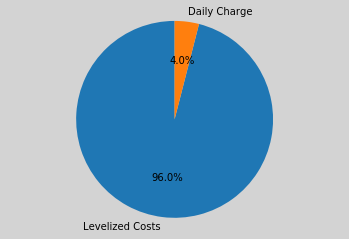

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[228.66209446021728, 215.91169820245523, 212.8297259188774, 39.57782166316641, 5.287219217799359, 10.610864214391999, 0.3576697241556376, 0.644126320433461, 0.40925564780661317, 3332.98, 322.17600000000004, 0.0, 211.526, 110.65, {'Levelized Costs': 3199.92, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59949574513, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (148.24398482624522, 226.0773343073607, 166.97573081016313, 1.3381613366313934, 33.68686172572931, 19.65059561396156, 0.575212488762046, 0.7721891091375728, 0.4133043074758632)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 1.3
                                           and a gcr of 0.575


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.976128101348877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 33.7
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.861008405685425 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 19.7
                                           and a gcr of 0.413


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8403589725494385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 152.296, 165.956]


ERROR:ga_logger:Cost: 3294.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,294 per year


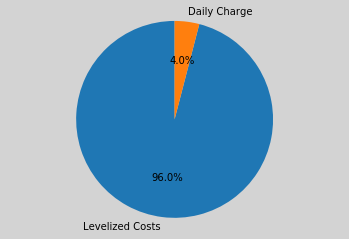

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[148.24398482624522, 226.0773343073607, 166.97573081016313, 1.3381613366313934, 33.68686172572931, 19.65059561396156, 0.575212488762046, 0.7721891091375728, 0.4133043074758632, 3294.0, 318.25199999999995, 0.0, 152.296, 165.956, {'Levelized Costs': 3160.944, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60116244816, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240.768549855508, 227.66138176399343, 159.3318760821432, 43.41077720475906, 49.143391327623334, 36.46456497874342, 0.4101592425386426, 0.7326835253825195, 0.26541958874000926)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 43.4
                                           and a gcr of 0.410


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9523873329162598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 49.1
                                           and a gcr of 0.733


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8623909950256348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 159
                                           a tilt of 36.5
                                           and a gcr of 0.265


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.901049852371216 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 309.098, 46.9503]


ERROR:ga_logger:Cost: 3669.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,669 per year


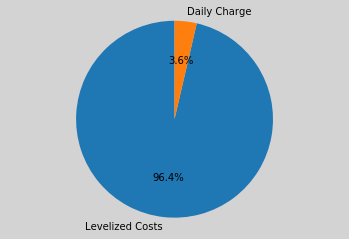

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[240.768549855508, 227.66138176399343, 159.3318760821432, 43.41077720475906, 49.143391327623334, 36.46456497874342, 0.4101592425386426, 0.7326835253825195, 0.26541958874000926, 3669.4, 356.04830000000004, 0.0, 309.098, 46.9503, {'Levelized Costs': 3536.3480000000004, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60092835203, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (104.61505660871987, 264.47925934963735, 148.63270178944464, 35.21899756321229, 29.948684770082608, 6.175722990788197, 0.36293741118771145, 0.29407756129684437, 0.20145451163626288)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 35.2
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9666850566864014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 29.9
                                           and a gcr of 0.294


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.805119037628174 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 6.2
                                           and a gcr of 0.201


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.79797625541687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [217.313, 0.0, 0.0]


ERROR:ga_logger:Cost: 5149.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0462 /kWh
Total Cost of the system: $ 5,150 per year


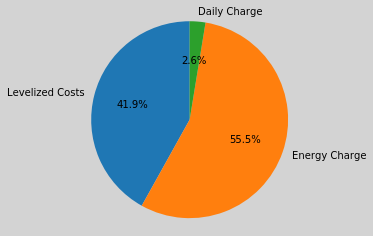

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[104.61505660871987, 264.47925934963735, 148.63270178944464, 35.21899756321229, 29.948684770082608, 6.175722990788197, 0.36293741118771145, 0.29407756129684437, 0.20145451163626288, 5149.55, 217.313, 217.313, 0.0, 0.0, {'Levelized Costs': 2158.3966, 'Energy Charge': 2858.1114000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 39035.56292572999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.83120480213725, 209.16791903528855, 179.10498888781365, 11.478386688457771, 31.86882456119767, 17.077107497377998, 0.829283333486897, 0.6263898409544926, 0.27098873838493825)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 11.5
                                           and a gcr of 0.829


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.938918352127075 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 31.9
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8076236248016357 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 17.1
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8006973266601562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 161s


ERROR:ga_logger:panel relevance: [0.0, 259.724, 49.8957]


ERROR:ga_logger:Cost: 3208.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,208 per year


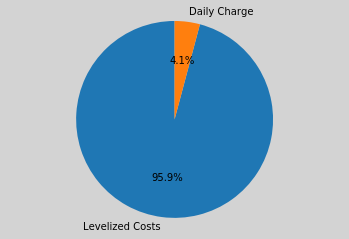

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[175.83120480213725, 209.16791903528855, 179.10498888781365, 11.478386688457771, 31.86882456119767, 17.077107497377998, 0.829283333486897, 0.6263898409544926, 0.27098873838493825, 3208.27, 309.61969999999997, 0.0, 259.724, 49.8957, {'Levelized Costs': 3075.213, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60145946702, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.97154820478863, 157.11327553412548, 208.47079041215312, 28.076744459591378, 9.408869057445262, 52.19049554934819, 0.8302386156301285, 0.5898864601528224, 0.8085315715728112)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 28.1
                                           and a gcr of 0.830


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9990766048431396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 9.4
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.756946325302124 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 52.2
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794081449508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 314.981, 0.0]


ERROR:ga_logger:Cost: 3261.51


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,262 per year


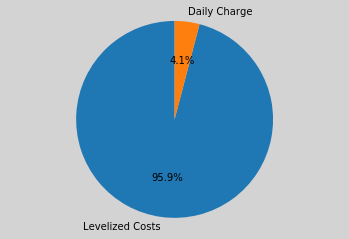

Total roof area of the  building: 599 m2
Total roof area used 534 m2
Percentage: 89.2%
succes
[[239.97154820478863, 157.11327553412548, 208.47079041215312, 28.076744459591378, 9.408869057445262, 52.19049554934819, 0.8302386156301285, 0.5898864601528224, 0.8085315715728112, 3261.51, 314.981, 0.0, 314.981, 0.0, {'Levelized Costs': 3128.463, 'Energy Charge': 0.005000000000109139, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60285089988, 61845.7, 533.969]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (102.64359744468206, 143.89318386989964, 245.16323777782392, 46.66454439424612, 12.516591808562122, 52.50455326250186, 0.5309210202702004, 0.5266143885765777, 0.8502154966684035)


ERROR:ga_logger:price of the panel 106


Found the solver set


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 46.7
                                           and a gcr of 0.531


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9227356910705566 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 12.5
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.786115884780884 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 245
                                           a tilt of 52.5
                                           and a gcr of 0.850


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.793442964553833 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 312.93, 0.0]


ERROR:ga_logger:Cost: 3241.14


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,241 per year


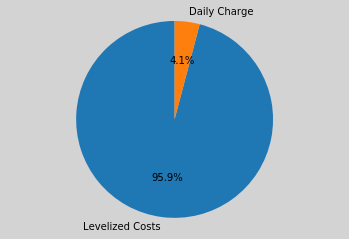

Total roof area of the  building: 599 m2
Total roof area used 594 m2
Percentage: 99.2%
succes
[[102.64359744468206, 143.89318386989964, 245.16323777782392, 46.66454439424612, 12.516591808562122, 52.50455326250186, 0.5309210202702004, 0.5266143885765777, 0.8502154966684035, 3241.14, 312.93, 0.0, 312.93, 0.0, {'Levelized Costs': 3108.0829999999996, 'Energy Charge': 0.015000000000441105, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600915849915, 61845.7, 594.23]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (118.87078296929292, 161.5863406431066, 220.27328582579105, 3.7728217860192705, 46.078311287438005, 3.015517942381027, 0.3728655419608179, 0.6763394659914868, 0.3826287466795266)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 119
                                           a tilt of 3.8
                                           and a gcr of 0.373


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2076475620269775 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 46.1
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.834089994430542 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 3.0
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6795883178710938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 321.901, 0.0]


ERROR:ga_logger:Cost: 3330.24


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,330 per year


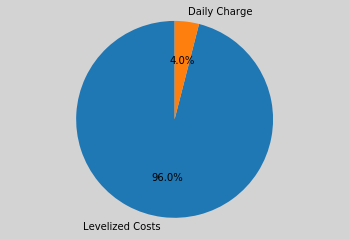

Total roof area of the  building: 599 m2
Total roof area used 476 m2
Percentage: 79.5%
succes
[[118.87078296929292, 161.5863406431066, 220.27328582579105, 3.7728217860192705, 46.078311287438005, 3.015517942381027, 0.3728655419608179, 0.6763394659914868, 0.3826287466795266, 3330.24, 321.901, 0.0, 321.901, 0.0, {'Levelized Costs': 3197.1829999999995, 'Energy Charge': 0.015000000000213731, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60262579989, 61845.7, 475.945]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (193.18503896025936, 159.60547123813487, 176.42436624766356, 6.906163054785546, 38.52985136616497, 37.056013567611714, 0.8567004778398704, 0.8722322047278086, 0.506489166951235)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 6.9
                                           and a gcr of 0.857


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0389957427978516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 160
                                           a tilt of 38.5
                                           and a gcr of 0.872


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.853691816329956 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 37.1
                                           and a gcr of 0.506


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.868058204650879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 297.512]


ERROR:ga_logger:Cost: 3088.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,088 per year


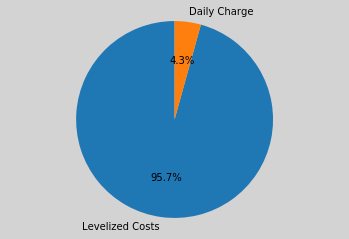

Total roof area of the  building: 599 m2
Total roof area used 587 m2
Percentage: 98.1%
succes
[[193.18503896025936, 159.60547123813487, 176.42436624766356, 6.906163054785546, 38.52985136616497, 37.056013567611714, 0.8567004778398704, 0.8722322047278086, 0.506489166951235, 3088.0, 297.512, 0.0, 0.0, 297.512, {'Levelized Costs': 2954.946, 'Energy Charge': 0.012000000000227828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601016129935, 61845.7, 587.4]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (223.8501606056157, 98.21426364470096, 223.77477023045338, 4.233884231635703, 3.5156552322696992, 42.74668774929589, 0.5376595451576109, 0.5753189935500358, 0.8377030509983485)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 4.2
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 6.088762998580933 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 3.5
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 9.262704849243164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 224
                                           a tilt of 42.7
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8157830238342285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  78 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 122 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [198.145, 132.455, 0.0]


ERROR:ga_logger:Cost: 3416.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,417 per year


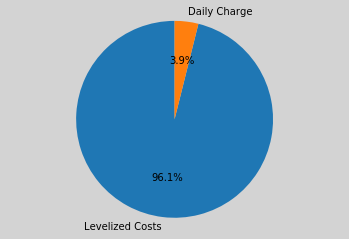

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[223.8501606056157, 98.21426364470096, 223.77477023045338, 4.233884231635703, 3.5156552322696992, 42.74668774929589, 0.5376595451576109, 0.5753189935500358, 0.8377030509983485, 3416.64, 330.6, 198.145, 132.455, 0.0, {'Levelized Costs': 3283.583, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60184461776, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (182.43878902363542, 199.03422403502282, 162.43151097569324, 40.479919118459065, 30.218708916514743, 19.19748031895247, 0.27882800606105207, 0.5715463261357596, 0.33787431728972217)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 182
                                           a tilt of 40.5
                                           and a gcr of 0.279


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1320958137512207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 199
                                           a tilt of 30.2
                                           and a gcr of 0.572


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.947483539581299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 19.2
                                           and a gcr of 0.338


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941263198852539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [39.787, 260.664, 0.0]


ERROR:ga_logger:Cost: 3117.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,117 per year


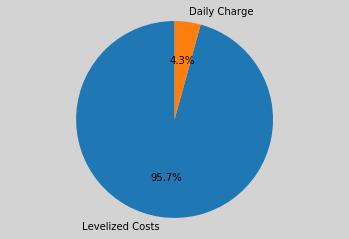

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[182.43878902363542, 199.03422403502282, 162.43151097569324, 40.479919118459065, 30.218708916514743, 19.19748031895247, 0.27882800606105207, 0.5715463261357596, 0.33787431728972217, 3117.2, 300.45099999999996, 39.787, 260.664, 0.0, {'Levelized Costs': 2984.138, 'Energy Charge': 0.019999999999924967, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111257735, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (251.21164762378996, 229.39215887883563, 253.42873041919043, 20.7128802764524, 31.349421714887576, 22.551850968014065, 0.6102457657483445, 0.5058953714198244, 0.5584189512807036)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 20.7
                                           and a gcr of 0.610


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1590540409088135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 31.3
                                           and a gcr of 0.506


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9306976795196533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 22.6
                                           and a gcr of 0.558


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9979703426361084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [152.99, 176.082, 0.0]


ERROR:ga_logger:Cost: 3401.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,401 per year


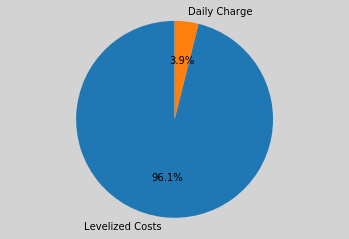

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[251.21164762378996, 229.39215887883563, 253.42873041919043, 20.7128802764524, 31.349421714887576, 22.551850968014065, 0.6102457657483445, 0.5058953714198244, 0.5584189512807036, 3401.46, 329.072, 152.99, 176.082, 0.0, {'Levelized Costs': 3268.402, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60179574445, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (136.76765814745357, 145.96029361265497, 158.3548355928831, 34.25113860986466, 52.10137976176055, 6.5673481515174945, 0.528708289025333, 0.4652505186769459, 0.2054802466028362)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 34.3
                                           and a gcr of 0.529


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3046836853027344 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 146
                                           a tilt of 52.1
                                           and a gcr of 0.465


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8220713138580322 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 6.6
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.820708751678467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 96s


ERROR:ga_logger:panel relevance: [316.194, 0.0, 0.0]


ERROR:ga_logger:Cost: 3273.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,274 per year


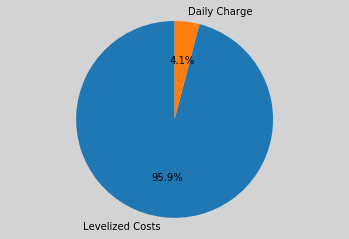

Total roof area of the  building: 599 m2
Total roof area used 598 m2
Percentage: 99.9%
succes
[[136.76765814745357, 145.96029361265497, 158.3548355928831, 34.25113860986466, 52.10137976176055, 6.5673481515174945, 0.528708289025333, 0.4652505186769459, 0.2054802466028362, 3273.56, 316.194, 316.194, 0.0, 0.0, {'Levelized Costs': 3140.503, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59959804995, 61845.7, 598.05]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.52487522107054, 244.8030210165994, 125.22449148733882, 7.27537293010718, 30.973820762257866, 10.555129794500951, 0.6711900496375892, 0.27377707487993963, 0.3296821139300783)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 7.3
                                           and a gcr of 0.671


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.931901693344116 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 31.0
                                           and a gcr of 0.274


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.865830421447754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 10.6
                                           and a gcr of 0.330


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7984509468078613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [318.704, 0.0, 0.0]


ERROR:ga_logger:Cost: 3298.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,298 per year


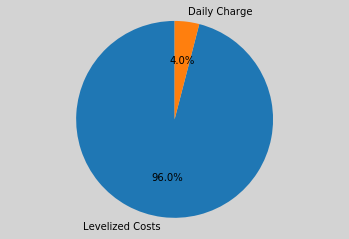

Total roof area of the  building: 599 m2
Total roof area used 475 m2
Percentage: 79.3%
succes
[[162.52487522107054, 244.8030210165994, 125.22449148733882, 7.27537293010718, 30.973820762257866, 10.555129794500951, 0.6711900496375892, 0.27377707487993963, 0.3296821139300783, 3298.49, 318.704, 318.704, 0.0, 0.0, {'Levelized Costs': 3165.4379999999996, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60280261371, 61845.7, 474.834]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (216.20591929407976, 264.8541683345353, 107.3110436921903, 28.756736301530946, 38.77248772342783, 49.2370506970959, 0.5977860104259844, 0.5808556622592507, 0.23450314179655776)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 28.8
                                           and a gcr of 0.598


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.958484172821045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 38.8
                                           and a gcr of 0.581


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8736627101898193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 107
                                           a tilt of 49.2
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8366754055023193 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [313.094, 0.0, 0.0]


ERROR:ga_logger:Cost: 3242.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


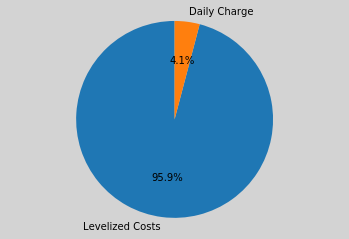

Total roof area of the  building: 599 m2
Total roof area used 524 m2
Percentage: 87.5%
succes
[[216.20591929407976, 264.8541683345353, 107.3110436921903, 28.756736301530946, 38.77248772342783, 49.2370506970959, 0.5977860104259844, 0.5808556622592507, 0.23450314179655776, 3242.77, 313.094, 313.094, 0.0, 0.0, {'Levelized Costs': 3109.717, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105005711, 61845.7, 523.756]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (134.9762232407436, 143.6531200591903, 181.43307860231033, 44.02065457124057, 40.54819820756897, 23.94869349115085, 0.8578175717715539, 0.8988978887179804, 0.7740689698437431)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 135
                                           a tilt of 44.0
                                           and a gcr of 0.858


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.972839593887329 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 40.5
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8210813999176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 181
                                           a tilt of 23.9
                                           and a gcr of 0.774


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8277294635772705 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.841]


ERROR:ga_logger:Cost: 3180.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,181 per year


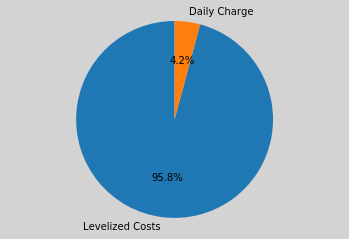

Total roof area of the  building: 599 m2
Total roof area used 396 m2
Percentage: 66.2%
succes
[[134.9762232407436, 143.6531200591903, 181.43307860231033, 44.02065457124057, 40.54819820756897, 23.94869349115085, 0.8578175717715539, 0.8988978887179804, 0.7740689698437431, 3180.66, 306.841, 0.0, 0.0, 306.841, {'Levelized Costs': 3047.613, 'Energy Charge': 0.00500000000027967, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60194714652, 61845.7, 396.4]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (263.8412174092491, 255.97098209391407, 234.05518766341245, 9.103116859113008, 6.146371073813855, 30.47718916625532, 0.26500405394077414, 0.4279121873197927, 0.31105513135591445)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 264
                                           a tilt of 9.1
                                           and a gcr of 0.265


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.255944013595581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 6.1
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.122101068496704 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 234
                                           a tilt of 30.5
                                           and a gcr of 0.311


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.840216636657715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 256.217, 0.0]


ERROR:ga_logger:Cost: 4484.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0292 /kWh
Total Cost of the system: $ 4,484 per year


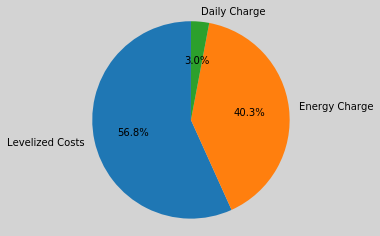

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[263.8412174092491, 255.97098209391407, 234.05518766341245, 9.103116859113008, 6.146371073813855, 30.47718916625532, 0.26500405394077414, 0.4279121873197927, 0.31105513135591445, 4484.03, 256.217, 0.0, 256.217, 0.0, {'Levelized Costs': 2544.8016999999995, 'Energy Charge': 1806.1863, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 47430.816661591765, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.8580573597916, 216.25629301662207, 255.02772596698392, 6.14391689425875, 53.34851236583299, 5.728865934046045, 0.35276051145485465, 0.7703449447450643, 0.4573769409925646)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 6.1
                                           and a gcr of 0.353


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940688133239746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 53.3
                                           and a gcr of 0.770


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8149147033691406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 5.7
                                           and a gcr of 0.457


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2293319702148438 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 186.478, 163.142]


ERROR:ga_logger:Cost: 3605.56


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,606 per year


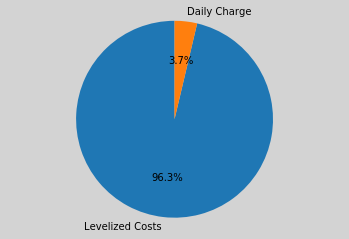

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.8580573597916, 216.25629301662207, 255.02772596698392, 6.14391689425875, 53.34851236583299, 5.728865934046045, 0.35276051145485465, 0.7703449447450643, 0.4573769409925646, 3605.56, 349.62, 0.0, 186.478, 163.142, {'Levelized Costs': 3472.4939999999997, 'Energy Charge': 0.024000000000285127, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60043787321, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (103.20025033406986, 119.29979086563851, 119.78623761220263, 34.75843148297305, 7.55472404735091, 35.55649663663961, 0.7121631985029793, 0.2927691588276938, 0.8916127433450107)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 34.8
                                           and a gcr of 0.712


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9676551818847656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 119
                                           a tilt of 7.6
                                           and a gcr of 0.293


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8316304683685303 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 35.6
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.837712287902832 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 81.4883, 285.695]


ERROR:ga_logger:Cost: 3780.0


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,780 per year


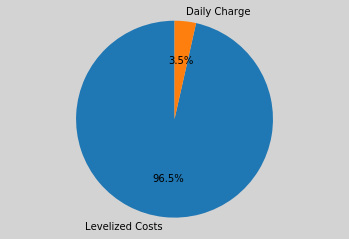

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[103.20025033406986, 119.29979086563851, 119.78623761220263, 34.75843148297305, 7.55472404735091, 35.55649663663961, 0.7121631985029793, 0.2927691588276938, 0.8916127433450107, 3780.0, 367.1833, 0.0, 81.4883, 285.695, {'Levelized Costs': 3646.9539999999993, 'Energy Charge': 0.004000000000587534, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603864659846, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210.86417941414106, 143.66244575964112, 229.18115513120975, 53.19040343870743, 8.691880968330752, 39.412432530684825, 0.8016550940822929, 0.28694493449083147, 0.448878738708283)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 53.2
                                           and a gcr of 0.802


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.007838249206543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 8.7
                                           and a gcr of 0.287


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8254287242889404 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 39.4
                                           and a gcr of 0.449


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8249998092651367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [164.419, 0.0, 176.707]


ERROR:ga_logger:Cost: 3521.18


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,521 per year


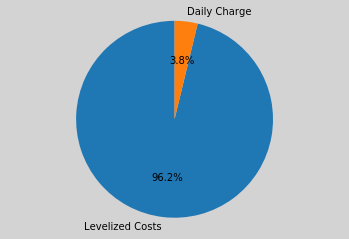

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[210.86417941414106, 143.66244575964112, 229.18115513120975, 53.19040343870743, 8.691880968330752, 39.412432530684825, 0.8016550940822929, 0.28694493449083147, 0.448878738708283, 3521.18, 341.126, 164.419, 0.0, 176.707, {'Levelized Costs': 3388.122, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60191519791, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (201.18692384534, 127.813755113343, 177.62248650342661, 48.296875789878555, 14.169820454138033, 18.740511630652968, 0.8160935485555405, 0.5559397831042342, 0.5686112914898068)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 48.3
                                           and a gcr of 0.816


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.922455072402954 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 128
                                           a tilt of 14.2
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.835721731185913 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 178
                                           a tilt of 18.7
                                           and a gcr of 0.569


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.810387134552002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 117s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 301.718]


ERROR:ga_logger:Cost: 3129.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,130 per year


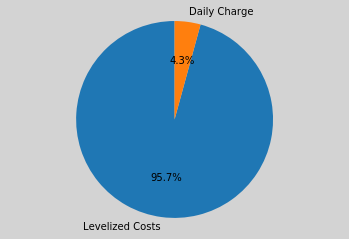

Total roof area of the  building: 599 m2
Total roof area used 531 m2
Percentage: 88.6%
succes
[[201.18692384534, 127.813755113343, 177.62248650342661, 48.296875789878555, 14.169820454138033, 18.740511630652968, 0.8160935485555405, 0.5559397831042342, 0.5686112914898068, 3129.78, 301.718, 0.0, 0.0, 301.718, {'Levelized Costs': 2996.7210000000005, 'Energy Charge': 0.01699999999971169, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603127430324, 61845.7, 530.623]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (171.99131044808342, 201.6271161523936, 243.9717387170381, 35.7230837850643, 28.80121994280294, 35.95808013457009, 0.25493751161043354, 0.6384426148270759, 0.3844159174127849)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 35.7
                                           and a gcr of 0.255


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.928340196609497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 202
                                           a tilt of 28.8
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.832204580307007 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 244
                                           a tilt of 36.0
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.808972120285034 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [52.4776, 250.855, 0.0]


ERROR:ga_logger:Cost: 3145.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,146 per year


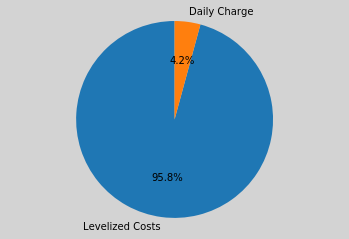

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[171.99131044808342, 201.6271161523936, 243.9717387170381, 35.7230837850643, 28.80121994280294, 35.95808013457009, 0.25493751161043354, 0.6384426148270759, 0.3844159174127849, 3145.81, 303.3326, 52.4776, 250.855, 0.0, {'Levelized Costs': 3012.756, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59919657553, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.39225109672586, 228.91294708115373, 91.86526876121432, 23.4646431988669, 6.337275785866024, 13.575891928011375, 0.2985909795522298, 0.6199679735130665, 0.7717778254255978)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 178
                                           a tilt of 23.5
                                           and a gcr of 0.299


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9962801933288574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 229
                                           a tilt of 6.3
                                           and a gcr of 0.620


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0206615924835205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 13.6
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7882049083709717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [46.1738, 275.342, 0.0]


ERROR:ga_logger:Cost: 3326.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,326 per year


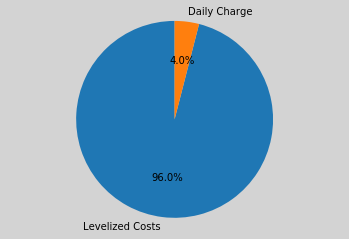

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[178.39225109672586, 228.91294708115373, 91.86526876121432, 23.4646431988669, 6.337275785866024, 13.575891928011375, 0.2985909795522298, 0.6199679735130665, 0.7717778254255978, 3326.41, 321.5158, 46.1738, 275.342, 0.0, {'Levelized Costs': 3193.3559999999998, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600066437895, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (176.28575896467214, 98.00060750347559, 255.12275736358984, 13.070518088115001, 28.82605748173459, 55.48533816309995, 0.45709489668928244, 0.26118970866322533, 0.7842049573164256)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 13.1
                                           and a gcr of 0.457


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9281764030456543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 28.8
                                           and a gcr of 0.261


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8344109058380127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 55.5
                                           and a gcr of 0.784


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.872744083404541 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  15 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [273.691, 0.0, 0.0]


ERROR:ga_logger:Cost: 3687.82


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0135 /kWh
Total Cost of the system: $ 3,688 per year


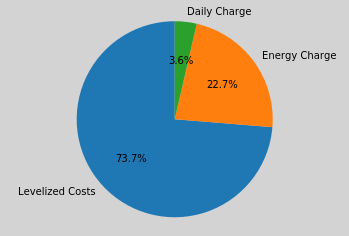

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[176.28575896467214, 98.00060750347559, 255.12275736358984, 13.070518088115001, 28.82605748173459, 55.48533816309995, 0.45709489668928244, 0.26118970866322533, 0.7842049573164256, 3687.82, 273.691, 273.691, 0.0, 0.0, {'Levelized Costs': 2718.3520000000003, 'Energy Charge': 836.4260000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55170.30127056006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.0673498567238, 140.5724871431824, 169.25388523065402, 26.181594543729485, 37.52098445532929, 21.947902535602925, 0.7018117525784211, 0.7288591348436111, 0.8760759869136854)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 258
                                           a tilt of 26.2
                                           and a gcr of 0.702


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9888179302215576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 37.5
                                           and a gcr of 0.729


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8649494647979736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 21.9
                                           and a gcr of 0.876


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.836205244064331 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 318.895]


ERROR:ga_logger:Cost: 3300.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


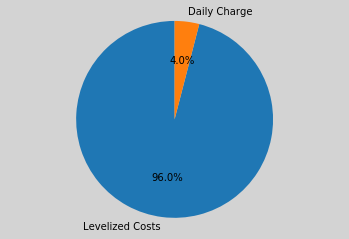

Total roof area of the  building: 599 m2
Total roof area used 364 m2
Percentage: 60.8%
succes
[[258.0673498567238, 140.5724871431824, 169.25388523065402, 26.181594543729485, 37.52098445532929, 21.947902535602925, 0.7018117525784211, 0.7288591348436111, 0.8760759869136854, 3300.39, 318.895, 0.0, 0.0, 318.895, {'Levelized Costs': 3167.34, 'Energy Charge': 0.007999999999981355, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600862588086, 61845.7, 364.004]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (137.3805654790412, 253.28866651414967, 197.9113011056482, 46.616930338803336, 40.08971146264062, 49.042561187086314, 0.4471436884527391, 0.5346934632835233, 0.7354715802924625)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 46.6
                                           and a gcr of 0.447


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9172282218933105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 40.1
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8387012481689453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 198
                                           a tilt of 49.0
                                           and a gcr of 0.735


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.870073080062866 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [175.793, 0.0, 151.225]


ERROR:ga_logger:Cost: 3381.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,381 per year


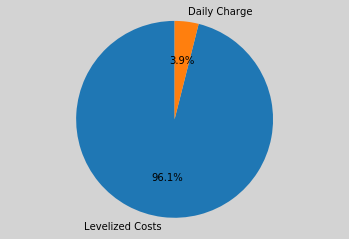

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.3805654790412, 253.28866651414967, 197.9113011056482, 46.616930338803336, 40.08971146264062, 49.042561187086314, 0.4471436884527391, 0.5346934632835233, 0.7354715802924625, 3381.06, 327.01800000000003, 175.793, 0.0, 151.225, {'Levelized Costs': 3248.006, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601215441886, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.825037717682, 263.71099759428733, 193.3379690311491, 19.78032115918326, 34.29224461750091, 39.00178085132094, 0.6820503624026699, 0.45249089494110195, 0.7471146959642632)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 19.8
                                           and a gcr of 0.682


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.965212821960449 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 34.3
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8110275268554688 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 39.0
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8092219829559326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.621]


ERROR:ga_logger:Cost: 3267.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,268 per year


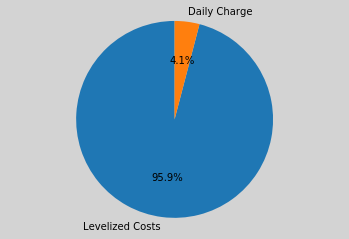

Total roof area of the  building: 599 m2
Total roof area used 422 m2
Percentage: 70.6%
succes
[[239.825037717682, 263.71099759428733, 193.3379690311491, 19.78032115918326, 34.29224461750091, 39.00178085132094, 0.6820503624026699, 0.45249089494110195, 0.7471146959642632, 3267.86, 315.621, 0.0, 0.0, 315.621, {'Levelized Costs': 3134.801, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60348068732, 61845.7, 422.453]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.73243148505983, 91.6416764918697, 242.0652307512974, 47.91548185578143, 37.43177597389542, 2.7936100163846707, 0.4733942567537516, 0.8658355138278082, 0.25077586647716515)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 47.9
                                           and a gcr of 0.473


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941221237182617 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 37.4
                                           and a gcr of 0.866


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.91086745262146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 242
                                           a tilt of 2.8
                                           and a gcr of 0.251


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6816604137420654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [122.396, 294.567, 0.0]


ERROR:ga_logger:Cost: 4274.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,274 per year


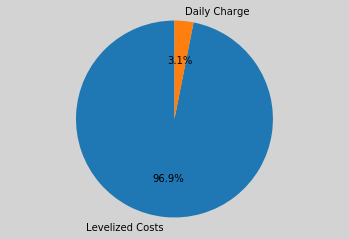

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[244.73243148505983, 91.6416764918697, 242.0652307512974, 47.91548185578143, 37.43177597389542, 2.7936100163846707, 0.4733942567537516, 0.8658355138278082, 0.25077586647716515, 4274.42, 416.963, 122.396, 294.567, 0.0, {'Levelized Costs': 4141.361, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60161620013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.6890053591314, 120.14759297561653, 191.52063976649254, 17.492097565188974, 6.556750494728191, 12.706318818709478, 0.6137030222415258, 0.48742199879281645, 0.42838864305507285)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 17.5
                                           and a gcr of 0.614


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.990227460861206 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 120
                                           a tilt of 6.6
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7960946559906006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 12.7
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.828994035720825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [304.255, 0.0, 0.0]


ERROR:ga_logger:Cost: 3154.98


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,155 per year


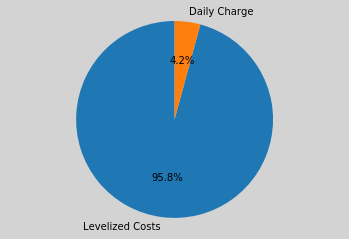

Total roof area of the  building: 599 m2
Total roof area used 496 m2
Percentage: 82.8%
succes
[[170.6890053591314, 120.14759297561653, 191.52063976649254, 17.492097565188974, 6.556750494728191, 12.706318818709478, 0.6137030222415258, 0.48742199879281645, 0.42838864305507285, 3154.98, 304.255, 304.255, 0.0, 0.0, {'Levelized Costs': 3021.93, 'Energy Charge': 0.008000000000151886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60165781505, 61845.7, 495.77]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (104.28064642104323, 137.19507789894192, 171.8005488509296, 48.584127474926035, 47.71420190906785, 6.9098172975581615, 0.7970662954883272, 0.41621099291216523, 0.7785967820387967)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 104
                                           a tilt of 48.6
                                           and a gcr of 0.797


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.96277117729187 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 137
                                           a tilt of 47.7
                                           and a gcr of 0.416


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8102805614471436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 172
                                           a tilt of 6.9
                                           and a gcr of 0.779


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7995316982269287 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 320.139]


ERROR:ga_logger:Cost: 3312.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,313 per year


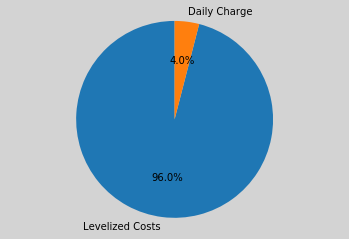

Total roof area of the  building: 599 m2
Total roof area used 411 m2
Percentage: 68.7%
succes
[[104.28064642104323, 137.19507789894192, 171.8005488509296, 48.584127474926035, 47.71420190906785, 6.9098172975581615, 0.7970662954883272, 0.41621099291216523, 0.7785967820387967, 3312.74, 320.139, 0.0, 0.0, 320.139, {'Levelized Costs': 3179.678, 'Energy Charge': 0.01999999999998181, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60248556111, 61845.7, 411.175]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (129.8541733864901, 176.6626927986021, 257.52118967150733, 33.155052150351636, 25.97674935539431, 3.1202373132808496, 0.5558138764519891, 0.3629122441212893, 0.8493024981651922)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 130
                                           a tilt of 33.2
                                           and a gcr of 0.556


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.009037494659424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 26.0
                                           and a gcr of 0.363


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8355116844177246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 258
                                           a tilt of 3.1
                                           and a gcr of 0.849


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.671746015548706 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 144.533, 170.288]


ERROR:ga_logger:Cost: 3259.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,260 per year


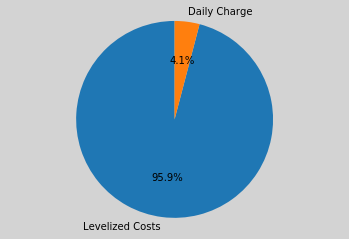

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[129.8541733864901, 176.6626927986021, 257.52118967150733, 33.155052150351636, 25.97674935539431, 3.1202373132808496, 0.5558138764519891, 0.3629122441212893, 0.8493024981651922, 3259.92, 314.821, 0.0, 144.533, 170.288, {'Levelized Costs': 3126.8669999999997, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602070007415, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.87308116787455, 171.32580440090584, 182.97379705870426, 2.8886421790328893, 22.054369902000563, 23.056776589992523, 0.6219600593518899, 0.8354639306040721, 0.4959475642827134)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 2.9
                                           and a gcr of 0.622


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.783421039581299 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 22.1
                                           and a gcr of 0.835


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8485183715820312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 23.1
                                           and a gcr of 0.496


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8484909534454346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 296.64]


ERROR:ga_logger:Cost: 3079.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,079 per year


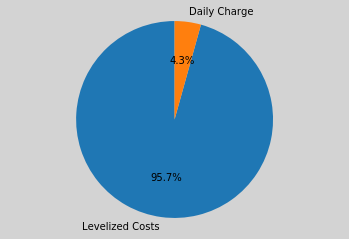

Total roof area of the  building: 599 m2
Total roof area used 598 m2
Percentage: 99.9%
succes
[[180.87308116787455, 171.32580440090584, 182.97379705870426, 2.8886421790328893, 22.054369902000563, 23.056776589992523, 0.6219600593518899, 0.8354639306040721, 0.4959475642827134, 3079.35, 296.64, 0.0, 0.0, 296.64, {'Levelized Costs': 2946.2949999999996, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59990348101, 61845.7, 598.128]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (149.67775114383664, 189.81231794934334, 131.46870483815627, 54.059073633722676, 12.159509581946407, 14.891904887345476, 0.5233670888825058, 0.5349783044031353, 0.40033036762882224)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 54.1
                                           and a gcr of 0.523


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2187042236328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 12.2
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.795966863632202 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 14.9
                                           and a gcr of 0.400


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.825465679168701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 309.24, 0.0]


ERROR:ga_logger:Cost: 3204.49


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,204 per year


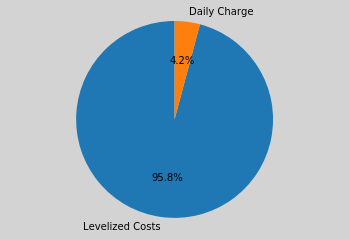

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[149.67775114383664, 189.81231794934334, 131.46870483815627, 54.059073633722676, 12.159509581946407, 14.891904887345476, 0.5233670888825058, 0.5349783044031353, 0.40033036762882224, 3204.49, 309.24, 0.0, 309.24, 0.0, {'Levelized Costs': 3071.432, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60115358079, 61845.7, 578.042]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (177.33470993735, 256.57832742525386, 206.60773311140792, 11.29634417122358, 50.04552757556191, 35.5341024050671, 0.6765367273142777, 0.4156152720809753, 0.38161247278444366)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 11.3
                                           and a gcr of 0.677


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9512319564819336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 50.0
                                           and a gcr of 0.416


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8617939949035645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 35.5
                                           and a gcr of 0.382


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8205175399780273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [180.234, 0.0, 126.831]


ERROR:ga_logger:Cost: 3182.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,183 per year


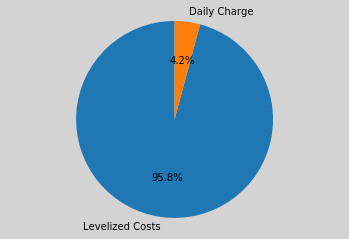

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[177.33470993735, 256.57832742525386, 206.60773311140792, 11.29634417122358, 50.04552757556191, 35.5341024050671, 0.6765367273142777, 0.4156152720809753, 0.38161247278444366, 3182.89, 307.065, 180.234, 0.0, 126.831, {'Levelized Costs': 3049.8349999999996, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601055867584, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.31699403266606, 177.16023302331791, 222.31339135514406, 23.0584719426547, 34.50217006210087, 3.818364791863912, 0.35929137350028484, 0.4825598090893008, 0.541725116149285)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 23.1
                                           and a gcr of 0.359


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.929804563522339 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 34.5
                                           and a gcr of 0.483


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.824507474899292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 3.8
                                           and a gcr of 0.542


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0657660961151123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 288.938, 0.0]


ERROR:ga_logger:Cost: 3174.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0028 /kWh
Total Cost of the system: $ 3,175 per year


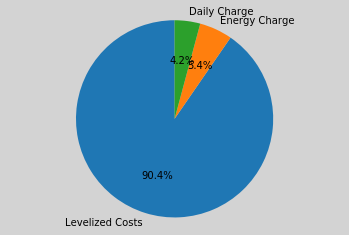

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[91.31699403266606, 177.16023302331791, 222.31339135514406, 23.0584719426547, 34.50217006210087, 3.818364791863912, 0.35929137350028484, 0.4825598090893008, 0.541725116149285, 3174.64, 288.938, 0.0, 288.938, 0.0, {'Levelized Costs': 2869.797, 'Energy Charge': 171.80100000000016, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60474.607899289986, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.64655789544135, 137.5847194232053, 91.5251957042841, 30.05929601102826, 12.087487898881061, 35.3249940560323, 0.4319780425603938, 0.6775274701847127, 0.27766380979848365)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 30.1
                                           and a gcr of 0.432


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9525399208068848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 138
                                           a tilt of 12.1
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8136355876922607 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 35.3
                                           and a gcr of 0.278


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8413970470428467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 318.052, 0.0]


ERROR:ga_logger:Cost: 3292.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,292 per year


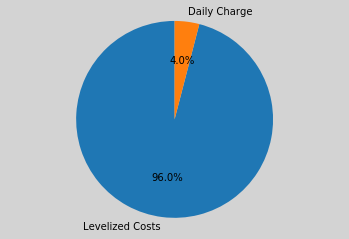

Total roof area of the  building: 599 m2
Total roof area used 469 m2
Percentage: 78.4%
succes
[[120.64655789544135, 137.5847194232053, 91.5251957042841, 30.05929601102826, 12.087487898881061, 35.3249940560323, 0.4319780425603938, 0.6775274701847127, 0.27766380979848365, 3292.01, 318.052, 0.0, 318.052, 0.0, {'Levelized Costs': 3158.957, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60056186611, 61845.7, 469.43]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (153.1669311978464, 107.18123951526907, 138.7299528297612, 34.08143763030255, 22.976734083360554, 22.19174581617397, 0.8694066932416096, 0.5774489204705284, 0.6722318886291851)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 153
                                           a tilt of 34.1
                                           and a gcr of 0.869


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9506444931030273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 107
                                           a tilt of 23.0
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.833177328109741 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 22.2
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8144633769989014 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.685]


ERROR:ga_logger:Cost: 3278.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


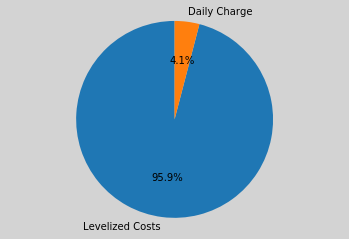

Total roof area of the  building: 599 m2
Total roof area used 471 m2
Percentage: 78.7%
succes
[[153.1669311978464, 107.18123951526907, 138.7299528297612, 34.08143763030255, 22.976734083360554, 22.19174581617397, 0.8694066932416096, 0.5774489204705284, 0.6722318886291851, 3278.44, 316.685, 0.0, 0.0, 316.685, {'Levelized Costs': 3145.39, 'Energy Charge': 0.008000000000038199, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600214899976, 61845.7, 471.095]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.2725880424594, 163.19564498372446, 92.92812737448125, 11.194836214361976, 10.977217696036444, 43.01672303330091, 0.6933314150338419, 0.23994287642347706, 0.5974994880085203)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 11.2
                                           and a gcr of 0.693


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.708986520767212 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 11.0
                                           and a gcr of 0.240


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8097281455993652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 93
                                           a tilt of 43.0
                                           and a gcr of 0.597


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.811528444290161 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [259.368, 53.9086, 0.0]


ERROR:ga_logger:Cost: 3244.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,245 per year


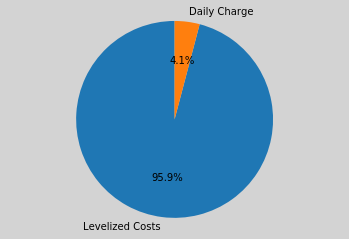

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[199.2725880424594, 163.19564498372446, 92.92812737448125, 11.194836214361976, 10.977217696036444, 43.01672303330091, 0.6933314150338419, 0.23994287642347706, 0.5974994880085203, 3244.58, 313.2766, 259.368, 53.9086, 0.0, {'Levelized Costs': 3111.522, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602460852104, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.80845325866548, 210.0095189582953, 202.69960698003882, 17.67637978165271, 36.169358002765726, 51.04220275403709, 0.682482130432735, 0.34533367891821604, 0.6637824757278432)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 140
                                           a tilt of 17.7
                                           and a gcr of 0.682


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9245784282684326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 36.2
                                           and a gcr of 0.345


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8115720748901367 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 51.0
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.814779043197632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [211.38, 99.8151, 0.0]


ERROR:ga_logger:Cost: 3223.91


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,224 per year


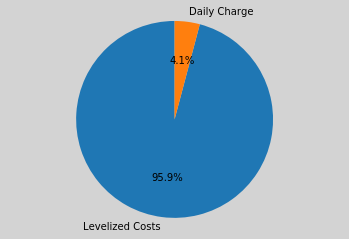

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.80845325866548, 210.0095189582953, 202.69960698003882, 17.67637978165271, 36.169358002765726, 51.04220275403709, 0.682482130432735, 0.34533367891821604, 0.6637824757278432, 3223.91, 311.1951, 211.38, 99.8151, 0.0, {'Levelized Costs': 3090.8489999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59925729495, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (92.20168254890123, 191.0034251583216, 183.70129861339274, 42.45981202526838, 39.76413394410296, 5.496460549406354, 0.36279321683070864, 0.7561795190396439, 0.3733413396889981)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 92
                                           a tilt of 42.5
                                           and a gcr of 0.363


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9431514739990234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 39.8
                                           and a gcr of 0.756


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.872748374938965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 5.5
                                           and a gcr of 0.373


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4542593955993652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 315.665, 0.0]


ERROR:ga_logger:Cost: 3268.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,268 per year


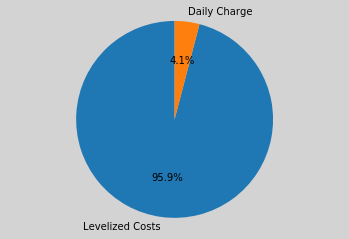

Total roof area of the  building: 599 m2
Total roof area used 417 m2
Percentage: 69.7%
succes
[[92.20168254890123, 191.0034251583216, 183.70129861339274, 42.45981202526838, 39.76413394410296, 5.496460549406354, 0.36279321683070864, 0.7561795190396439, 0.3733413396889981, 3268.3, 315.665, 0.0, 315.665, 0.0, {'Levelized Costs': 3135.248, 'Energy Charge': 0.010000000000104592, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60351573396, 61845.7, 417.447]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.05825022768119, 170.68787202749894, 146.1565445329254, 37.13878553674049, 12.310282735991978, 16.42140636563043, 0.5167034909252322, 0.28293548971551274, 0.6048089680764637)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 37.1
                                           and a gcr of 0.517


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0031516551971436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 12.3
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.828739881515503 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 16.4
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8192577362060547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [298.674, 0.0, 0.0]


ERROR:ga_logger:Cost: 3099.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,100 per year


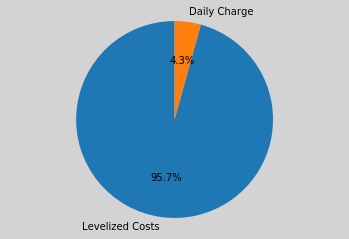

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[172.05825022768119, 170.68787202749894, 146.1565445329254, 37.13878553674049, 12.310282735991978, 16.42140636563043, 0.5167034909252322, 0.28293548971551274, 0.6048089680764637, 3099.55, 298.674, 298.674, 0.0, 0.0, {'Levelized Costs': 2966.4950000000003, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60055852017, 61845.7, 578.038]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (177.04151046463713, 257.5938519021704, 101.72769254509463, 41.86888448016831, 2.388077739856976, 49.02256416176286, 0.39077124173168787, 0.39903170513865277, 0.5751937065923515)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 177
                                           a tilt of 41.9
                                           and a gcr of 0.391


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.92375111579895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 2.4
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.652745485305786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 49.0
                                           and a gcr of 0.575


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9244518280029297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [233.979, 0.0, 0.0]


ERROR:ga_logger:Cost: 4083.95


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0263 /kWh
Total Cost of the system: $ 4,084 per year


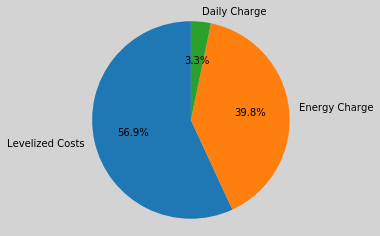

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[177.04151046463713, 257.5938519021704, 101.72769254509463, 41.86888448016831, 2.388077739856976, 49.02256416176286, 0.39077124173168787, 0.39903170513865277, 0.5751937065923515, 4083.95, 233.979, 233.979, 0.0, 0.0, {'Levelized Costs': 2323.9249999999997, 'Energy Charge': 1626.9830000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 48861.00897509988, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.84852266072618, 136.31507607429438, 116.47912427598686, 39.67677267952424, 11.23186046760056, 17.85741264197292, 0.5524176766836149, 0.7854616627688413, 0.36968727474902224)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 122
                                           a tilt of 39.7
                                           and a gcr of 0.552


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.224332571029663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 11.2
                                           and a gcr of 0.785


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.81048321723938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 116
                                           a tilt of 17.9
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8156614303588867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 189.747, 132.048]


ERROR:ga_logger:Cost: 3329.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,329 per year


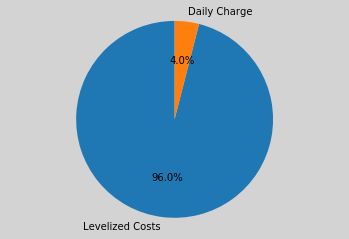

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.84852266072618, 136.31507607429438, 116.47912427598686, 39.67677267952424, 11.23186046760056, 17.85741264197292, 0.5524176766836149, 0.7854616627688413, 0.36968727474902224, 3329.19, 321.795, 0.0, 189.747, 132.048, {'Levelized Costs': 3196.1259999999997, 'Energy Charge': 0.02200000000016189, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59990437028, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (170.3104631007156, 181.569794604761, 211.21608626649873, 25.179549271453357, 8.423119990199408, 45.49284495152328, 0.3107536619289899, 0.7809316958780295, 0.4866034699245204)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 25.2
                                           and a gcr of 0.311


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9151644706726074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 8.4
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.846829891204834 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 45.5
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.812835454940796 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [105.087, 203.505, 0.0]


ERROR:ga_logger:Cost: 3198.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,198 per year


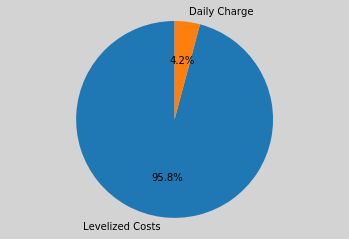

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[170.3104631007156, 181.569794604761, 211.21608626649873, 25.179549271453357, 8.423119990199408, 45.49284495152328, 0.3107536619289899, 0.7809316958780295, 0.4866034699245204, 3198.06, 308.592, 105.087, 203.505, 0.0, {'Levelized Costs': 3064.9939999999997, 'Energy Charge': 0.024000000000455657, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60149027237, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200.53848805307143, 258.2343412647464, 184.3418836465118, 41.3719213920535, 25.82376717136706, 18.559562517009095, 0.31103365801260086, 0.868523749257128, 0.25489648213062516)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 201
                                           a tilt of 41.4
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9318687915802 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 258
                                           a tilt of 25.8
                                           and a gcr of 0.869


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8034934997558594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 18.6
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.834491729736328 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [89.8985, 269.008, 0.0]


ERROR:ga_logger:Cost: 3697.79


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,698 per year


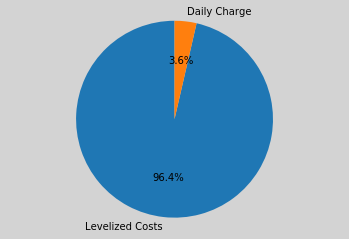

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[200.53848805307143, 258.2343412647464, 184.3418836465118, 41.3719213920535, 25.82376717136706, 18.559562517009095, 0.31103365801260086, 0.868523749257128, 0.25489648213062516, 3697.79, 358.9065, 89.8985, 269.008, 0.0, {'Levelized Costs': 3564.736, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602254835096, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.32022777517517, 238.41795715611636, 149.93239102864436, 4.663940056377902, 18.229670394763048, 54.239177994856426, 0.7521785075941125, 0.5005913815601482, 0.4684401931817231)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 4.7
                                           and a gcr of 0.752


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977652072906494 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 238
                                           a tilt of 18.2
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9244303703308105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 150
                                           a tilt of 54.2
                                           and a gcr of 0.468


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.831695318222046 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [72.7227, 251.336, 0.0]


ERROR:ga_logger:Cost: 3351.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,352 per year


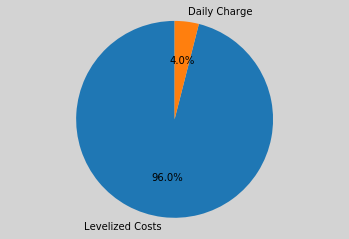

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[141.32022777517517, 238.41795715611636, 149.93239102864436, 4.663940056377902, 18.229670394763048, 54.239177994856426, 0.7521785075941125, 0.5005913815601482, 0.4684401931817231, 3351.68, 324.05870000000004, 72.7227, 251.336, 0.0, {'Levelized Costs': 3218.6219999999994, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60126504925, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.90905941696315, 176.06154475779798, 230.3792754632323, 19.054390284116813, 53.40411514254636, 37.10244194829769, 0.7267032007209144, 0.6724481686761413, 0.3673739919494329)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 19.1
                                           and a gcr of 0.727


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9490914344787598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 53.4
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8283138275146484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 37.1
                                           and a gcr of 0.367


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8862202167510986 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 230.602, 93.9864]


ERROR:ga_logger:Cost: 3356.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,357 per year


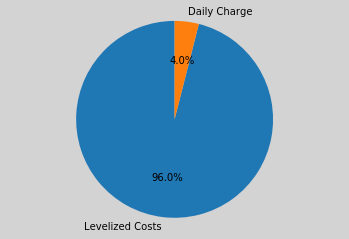

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.90905941696315, 176.06154475779798, 230.3792754632323, 19.054390284116813, 53.40411514254636, 37.10244194829769, 0.7267032007209144, 0.6724481686761413, 0.3673739919494329, 3356.93, 324.5884, 0.0, 230.602, 93.9864, {'Levelized Costs': 3223.879, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59937633426, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63

ERROR:ga_logger:panel values: (254.1229419044818, 174.99159208549037, 138.52258644629208, 21.795284273554046, 6.007068540714041, 47.51812338090464, 0.4206241910564806, 0.7017717504968946, 0.7812048381465542)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 254
                                           a tilt of 21.8
                                           and a gcr of 0.421


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.950629711151123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 175
                                           a tilt of 6.0
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.797987699508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 47.5
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8394691944122314 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 320.88, 0.0]


ERROR:ga_logger:Cost: 3320.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


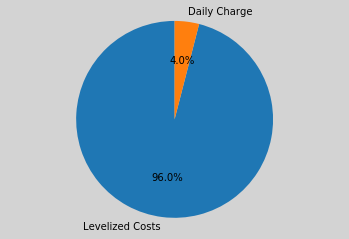

Total roof area of the  building: 599 m2
Total roof area used 457 m2
Percentage: 76.4%
succes
[[254.1229419044818, 174.99159208549037, 138.52258644629208, 21.795284273554046, 6.007068540714041, 47.51812338090464, 0.4206241910564806, 0.7017717504968946, 0.7812048381465542, 3320.1, 320.88, 0.0, 320.88, 0.0, {'Levelized Costs': 3187.037, 'Energy Charge': 0.021000000000185537, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59994749304, 61845.7, 457.242]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165.9097596920013, 114.38374647418925, 119.77293426966587, 25.486528553534583, 28.576728360406342, 30.295465824344927, 0.48674817019181943, 0.6188902397903233, 0.22050213749914327)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 25.5
                                           and a gcr of 0.487


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940812110900879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 28.6
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8445520401000977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 30.3
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0563719272613525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [239.185, 66.4488, 0.0]


ERROR:ga_logger:Cost: 3168.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,169 per year


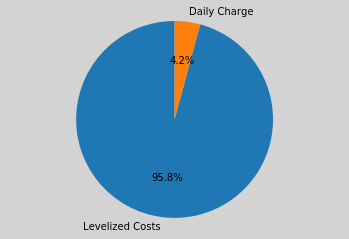

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[165.9097596920013, 114.38374647418925, 119.77293426966587, 25.486528553534583, 28.576728360406342, 30.295465824344927, 0.48674817019181943, 0.6188902397903233, 0.22050213749914327, 3168.67, 305.6338, 239.185, 66.4488, 0.0, {'Levelized Costs': 3035.6130000000003, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603122910106, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.57182823010083, 127.08947761293652, 138.5957167656141, 17.39044357607273, 34.5688092948589, 14.431051112014433, 0.38174776790629616, 0.7480503636863307, 0.2228685125311794)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 17.4
                                           and a gcr of 0.382


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.960385799407959 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 127
                                           a tilt of 34.6
                                           and a gcr of 0.748


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.857919931411743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 14.4
                                           and a gcr of 0.223


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.863534927368164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [124.988, 202.984, 0.0]


ERROR:ga_logger:Cost: 3390.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,391 per year


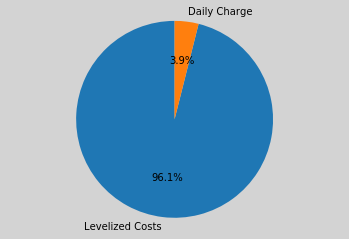

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[174.57182823010083, 127.08947761293652, 138.5957167656141, 17.39044357607273, 34.5688092948589, 14.431051112014433, 0.38174776790629616, 0.7480503636863307, 0.2228685125311794, 3390.54, 327.972, 124.988, 202.984, 0.0, {'Levelized Costs': 3257.4759999999997, 'Energy Charge': 0.022000000000389264, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59935141, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (96.10101333062417, 157.94852796067443, 255.75476962976984, 18.049940176668148, 42.30986144075464, 35.73611476450523, 0.7560328577013942, 0.8794414602784633, 0.7462233112135839)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 18.0
                                           and a gcr of 0.756


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9804694652557373 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 158
                                           a tilt of 42.3
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.807777166366577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 256
                                           a tilt of 35.7
                                           and a gcr of 0.746


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8233726024627686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 340.334, 0.0]


ERROR:ga_logger:Cost: 3513.33


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,513 per year


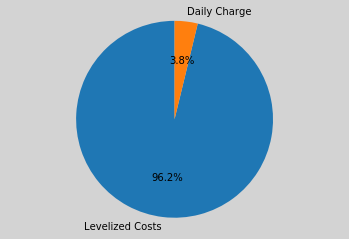

Total roof area of the  building: 599 m2
Total roof area used 387 m2
Percentage: 64.6%
succes
[[96.10101333062417, 157.94852796067443, 255.75476962976984, 18.049940176668148, 42.30986144075464, 35.73611476450523, 0.7560328577013942, 0.8794414602784633, 0.7462233112135839, 3513.33, 340.334, 0.0, 340.334, 0.0, {'Levelized Costs': 3380.276, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59957800015, 61845.7, 386.989]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (154.08173529276706, 116.43465156664624, 199.20349259589332, 10.576904165401446, 45.73955681232354, 41.70665751409199, 0.23432983688507547, 0.5383754080447948, 0.514871539793547)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 154
                                           a tilt of 10.6
                                           and a gcr of 0.234


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.991879463195801 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 116
                                           a tilt of 45.7
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8169822692871094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 41.7
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.819329261779785 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 305.807]


ERROR:ga_logger:Cost: 3170.39


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,170 per year


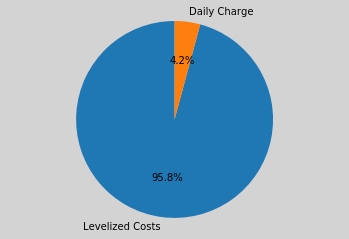

Total roof area of the  building: 599 m2
Total roof area used 594 m2
Percentage: 99.2%
succes
[[154.08173529276706, 116.43465156664624, 199.20349259589332, 10.576904165401446, 45.73955681232354, 41.70665751409199, 0.23432983688507547, 0.5383754080447948, 0.514871539793547, 3170.39, 305.807, 0.0, 0.0, 305.807, {'Levelized Costs': 3037.339, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60097363382, 61845.7, 593.947]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.99117201077067, 118.04260247490896, 148.6802436142417, 39.11176839853339, 45.50474151042838, 13.786255781966295, 0.8377676090640371, 0.8936597297159656, 0.5999469475584083)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 127
                                           a tilt of 39.1
                                           and a gcr of 0.838


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2330148220062256 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 118
                                           a tilt of 45.5
                                           and a gcr of 0.894


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.801791191101074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 149
                                           a tilt of 13.8
                                           and a gcr of 0.600


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8305306434631348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.458]


ERROR:ga_logger:Cost: 3226.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,227 per year


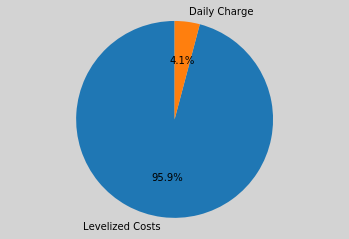

Total roof area of the  building: 599 m2
Total roof area used 519 m2
Percentage: 86.7%
succes
[[126.99117201077067, 118.04260247490896, 148.6802436142417, 39.11176839853339, 45.50474151042838, 13.786255781966295, 0.8377676090640371, 0.8936597297159656, 0.5999469475584083, 3226.52, 311.458, 0.0, 0.0, 311.458, {'Levelized Costs': 3093.4719999999998, 'Energy Charge': 0.006000000000312866, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60064236017, 61845.7, 519.142]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (120.32745634257567, 190.4870789108942, 127.65270185429233, 19.167834649737387, 10.059370396788925, 55.062463532696526, 0.22888217325397076, 0.8590588491957913, 0.5042559910173794)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 19.2
                                           and a gcr of 0.229


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.945281505584717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 10.1
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2635931968688965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 128
                                           a tilt of 55.1
                                           and a gcr of 0.504


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.834568500518799 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [71.1533, 247.313, 0.0]


ERROR:ga_logger:Cost: 3296.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,296 per year


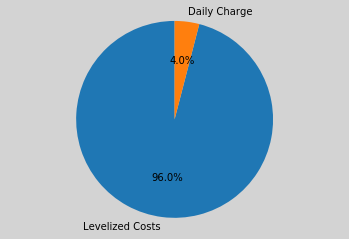

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[120.32745634257567, 190.4870789108942, 127.65270185429233, 19.167834649737387, 10.059370396788925, 55.062463532696526, 0.22888217325397076, 0.8590588491957913, 0.5042559910173794, 3296.13, 318.4663, 71.1533, 247.313, 0.0, {'Levelized Costs': 3163.076, 'Energy Charge': 0.012000000000170985, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59920822302, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (145.1001191712501, 248.67121908546846, 110.94499566162489, 7.654019605149785, 23.387942590246066, 31.737218573925844, 0.6403386010138602, 0.39488111421825356, 0.8239600793056998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 7.7
                                           and a gcr of 0.640


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9339916706085205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 23.4
                                           and a gcr of 0.395


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.840001106262207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 111
                                           a tilt of 31.7
                                           and a gcr of 0.824


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.840682029724121 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [320.058, 0.0, 0.0]


ERROR:ga_logger:Cost: 3311.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,312 per year


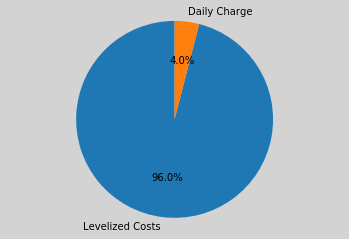

Total roof area of the  building: 599 m2
Total roof area used 500 m2
Percentage: 83.5%
succes
[[145.1001191712501, 248.67121908546846, 110.94499566162489, 7.654019605149785, 23.387942590246066, 31.737218573925844, 0.6403386010138602, 0.39488111421825356, 0.8239600793056998, 3311.94, 320.058, 320.058, 0.0, 0.0, {'Levelized Costs': 3178.886, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60347939992, 61845.7, 499.827]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.8410252207654, 100.19724876005311, 240.06661367861403, 39.92350799028799, 54.56075382024799, 36.53816242190546, 0.8217396632407428, 0.27201911994603106, 0.533968276173755)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 39.9
                                           and a gcr of 0.822


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0009801387786865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 54.6
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.824007749557495 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 240
                                           a tilt of 36.5
                                           and a gcr of 0.534


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8235549926757812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [316.608, 0.0, 0.0]


ERROR:ga_logger:Cost: 3277.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,278 per year


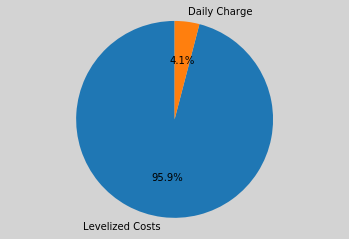

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.3%
succes
[[180.8410252207654, 100.19724876005311, 240.06661367861403, 39.92350799028799, 54.56075382024799, 36.53816242190546, 0.8217396632407428, 0.27201911994603106, 0.533968276173755, 3277.67, 316.608, 316.608, 0.0, 0.0, {'Levelized Costs': 3144.618, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60076389622, 61845.7, 385.29]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.14962098230657, 241.32539461853023, 242.1207791948706, 26.45274931322489, 40.654907214701026, 54.023382942193244, 0.3508913219394503, 0.600574506576776, 0.351332853960897)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 26.5
                                           and a gcr of 0.351


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.936843156814575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 241
                                           a tilt of 40.7
                                           and a gcr of 0.601


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8117129802703857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 242
                                           a tilt of 54.0
                                           and a gcr of 0.351


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8789420127868652 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [6.35665, 348.721, 0.0]


ERROR:ga_logger:Cost: 3659.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,660 per year


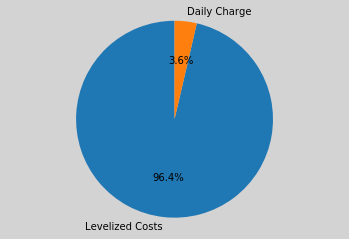

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.14962098230657, 241.32539461853023, 242.1207791948706, 26.45274931322489, 40.654907214701026, 54.023382942193244, 0.3508913219394503, 0.600574506576776, 0.351332853960897, 3659.76, 355.07765, 6.35665, 348.721, 0.0, {'Levelized Costs': 3526.694, 'Energy Charge': 0.02400000000017144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59811387817, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (256.0280864127268, 216.36786853912247, 233.19477764663915, 50.39247036324457, 36.207153474127104, 41.810681715825325, 0.44365534610263035, 0.8322396678648494, 0.28394864413774024)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 50.4
                                           and a gcr of 0.444


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.185554265975952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 216
                                           a tilt of 36.2
                                           and a gcr of 0.832


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.822638988494873 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 41.8
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9199249744415283 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 253.885, 83.3956]


ERROR:ga_logger:Cost: 3482.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,483 per year


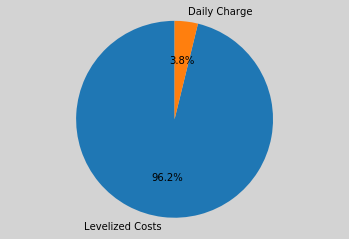

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[256.0280864127268, 216.36786853912247, 233.19477764663915, 50.39247036324457, 36.207153474127104, 41.810681715825325, 0.44365534610263035, 0.8322396678648494, 0.28394864413774024, 3482.99, 337.2806, 0.0, 253.885, 83.3956, {'Levelized Costs': 3349.9269999999997, 'Energy Charge': 0.02100000000007185, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600390483094, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (232.893077684967, 114.44690340580712, 103.86928708761656, 55.6421006655113, 20.251769236143616, 34.3481211722398, 0.5128970665707895, 0.8287448903599703, 0.2334883462110804)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 55.6
                                           and a gcr of 0.513


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.918139934539795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 20.3
                                           and a gcr of 0.829


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8168225288391113 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 104
                                           a tilt of 34.3
                                           and a gcr of 0.233


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.811678171157837 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  14 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 287.241, 58.8775]


ERROR:ga_logger:Cost: 3570.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,571 per year


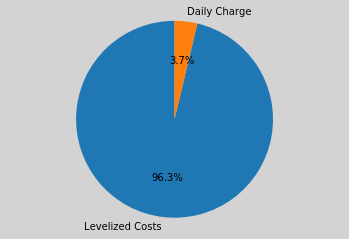

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[232.893077684967, 114.44690340580712, 103.86928708761656, 55.6421006655113, 20.251769236143616, 34.3481211722398, 0.5128970665707895, 0.8287448903599703, 0.2334883462110804, 3570.77, 346.1185, 0.0, 287.241, 58.8775, {'Levelized Costs': 3437.702, 'Energy Charge': 0.02599999999983993, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.597652050164, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (258.98873332058434, 226.27947287625506, 240.82849872373026, 10.70790641180702, 3.8429597261847706, 25.833487129556733, 0.8925187223654742, 0.36621383675897123, 0.4842124662614286)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 259
                                           a tilt of 10.7
                                           and a gcr of 0.893


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.93300199508667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 3.8
                                           and a gcr of 0.366


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7699642181396484 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 25.8
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.802384614944458 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [95.2762, 0.0, 238.238]


ERROR:ga_logger:Cost: 3445.59


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,446 per year


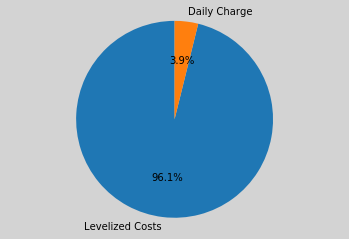

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[258.98873332058434, 226.27947287625506, 240.82849872373026, 10.70790641180702, 3.8429597261847706, 25.833487129556733, 0.8925187223654742, 0.36621383675897123, 0.4842124662614286, 3445.59, 333.5142, 95.2762, 0.0, 238.238, {'Levelized Costs': 3312.538, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600885222506, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.84044744170944, 189.804763512938, 120.69476159208227, 54.79614387130056, 33.87388275029836, 29.464616134326203, 0.22458024581262517, 0.6285436465161912, 0.6998441089210818)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 54.8
                                           and a gcr of 0.225


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9179270267486572 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 33.9
                                           and a gcr of 0.629


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.82051157951355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 121
                                           a tilt of 29.5
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8449971675872803 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 302.172, 0.0]


ERROR:ga_logger:Cost: 3134.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,134 per year


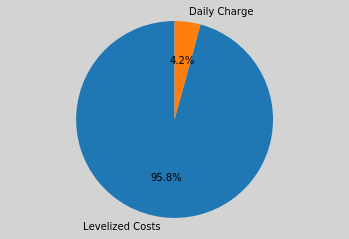

Total roof area of the  building: 599 m2
Total roof area used 481 m2
Percentage: 80.3%
succes
[[196.84044744170944, 189.804763512938, 120.69476159208227, 54.79614387130056, 33.87388275029836, 29.464616134326203, 0.22458024581262517, 0.6285436465161912, 0.6998441089210818, 3134.29, 302.172, 0.0, 302.172, 0.0, {'Levelized Costs': 3001.229, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600789652, 61845.7, 480.749]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (178.56876672856941, 216.69587255171865, 136.68088024639115, 2.685573053362015, 33.936866953682504, 50.118328769057726, 0.2097553928781169, 0.33832644883691954, 0.5382547716925699)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 179
                                           a tilt of 2.7
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.886789321899414 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 33.9
                                           and a gcr of 0.338


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.838057041168213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 50.1
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.874723196029663 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 322.286]


ERROR:ga_logger:Cost: 3713.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0061 /kWh
Total Cost of the system: $ 3,714 per year


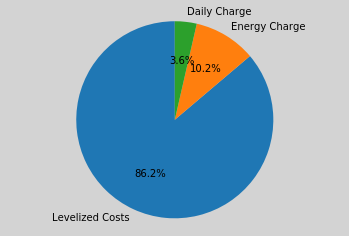

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[178.56876672856941, 216.69587255171865, 136.68088024639115, 2.685573053362015, 33.936866953682504, 50.118328769057726, 0.2097553928781169, 0.33832644883691954, 0.5382547716925699, 3713.89, 322.286, 0.0, 0.0, 322.286, {'Levelized Costs': 3201.009, 'Energy Charge': 379.83900000000006, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58814.28316925897, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (263.43414289020564, 102.35795595606993, 101.52476801863945, 20.306496638709554, 1.0829459192374253, 32.85045388291159, 0.4653952334304077, 0.2646091114387956, 0.21795845017065263)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 263
                                           a tilt of 20.3
                                           and a gcr of 0.465


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9756648540496826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 1.1
                                           and a gcr of 0.265


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.9771835803985596 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 102
                                           a tilt of 32.9
                                           and a gcr of 0.218


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.815714120864868 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [278.661, 0.0, 0.0]


ERROR:ga_logger:Cost: 4407.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0244 /kWh
Total Cost of the system: $ 4,407 per year


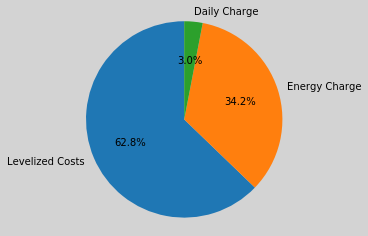

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[263.43414289020564, 102.35795595606993, 101.52476801863945, 20.306496638709554, 1.0829459192374253, 32.85045388291159, 0.4653952334304077, 0.2646091114387956, 0.21795845017065263, 4407.48, 278.661, 278.661, 0.0, 0.0, {'Levelized Costs': 2767.7189999999996, 'Energy Charge': 1506.7190000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 49820.78649535148, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (207.54955664626783, 207.81316523380195, 140.2302826043951, 11.670200983105206, 42.12692216148681, 36.77828640631584, 0.8590993146279231, 0.7733615539103911, 0.7910737521292996)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 208
                                           a tilt of 11.7
                                           and a gcr of 0.859


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9528541564941406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 208
                                           a tilt of 42.1
                                           and a gcr of 0.773


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.848763942718506 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.8
                                           and a gcr of 0.791


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.082700490951538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [322.478, 0.0, 0.0]


ERROR:ga_logger:Cost: 3335.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,336 per year


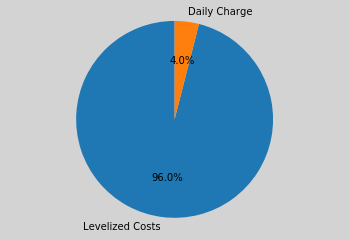

Total roof area of the  building: 599 m2
Total roof area used 375 m2
Percentage: 62.7%
succes
[[207.54955664626783, 207.81316523380195, 140.2302826043951, 11.670200983105206, 42.12692216148681, 36.77828640631584, 0.8590993146279231, 0.7733615539103911, 0.7910737521292996, 3335.97, 322.478, 322.478, 0.0, 0.0, {'Levelized Costs': 3202.912, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60189808973, 61845.7, 375.368]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (220.16112385514515, 179.92614972254444, 191.4382694569976, 9.62646933747129, 36.50310799226164, 18.953686663362515, 0.37543835950102294, 0.2285733499491856, 0.34143324912236506)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 220
                                           a tilt of 9.6
                                           and a gcr of 0.375


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.967798948287964 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 36.5
                                           and a gcr of 0.229


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8696446418762207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 19.0
                                           and a gcr of 0.341


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843595027923584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 69s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 0.0]


ERROR:ga_logger:Can not solve this model correctly.


succes
[[220.16112385514515, 179.92614972254444, 191.4382694569976, 9.62646933747129, 36.50310799226164, 18.953686663362515, 0.37543835950102294, 0.2285733499491856, 0.34143324912236506, 90000000000, 0, 0.0, 0.0, 0.0, {'Levelized Costs': 0, 'Energy Charge': 10000000000, 'Demand Charge': 0, 'Daily Charge': 0}, 90000000000, 90000000000, 0]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.89617717976876, 180.24219094611905, 175.1404557889482, 34.792093812472956, 5.912635015532191, 36.00188007470721, 0.4733330091716245, 0.3992838769740948, 0.4436974174606755)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 34.8
                                           and a gcr of 0.473


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9911463260650635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 5.9
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1502223014831543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 36.0
                                           and a gcr of 0.444


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8078842163085938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 265.669]


ERROR:ga_logger:Cost: 3536.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0124 /kWh
Total Cost of the system: $ 3,537 per year


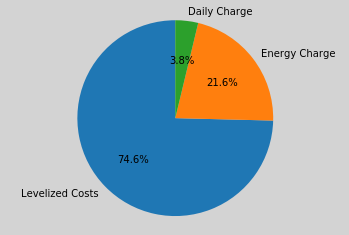

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.89617717976876, 180.24219094611905, 175.1404557889482, 34.792093812472956, 5.912635015532191, 36.00188007470721, 0.4733330091716245, 0.3992838769740948, 0.4436974174606755, 3536.85, 265.669, 0.0, 0.0, 265.669, {'Levelized Costs': 2638.6789999999996, 'Energy Charge': 765.1290000000004, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55739.367641540026, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.40909993854515, 186.5559978774968, 194.42167795294972, 15.575702762257569, 12.142027105421892, 42.31829956155865, 0.6879230153490803, 0.28348043409853785, 0.6793521473305673)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 15.6
                                           and a gcr of 0.688


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.061664342880249 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 187
                                           a tilt of 12.1
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9180662631988525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 42.3
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8368189334869385 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 67.1805, 245.774]


ERROR:ga_logger:Cost: 3241.38


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,241 per year


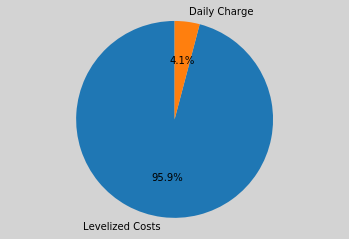

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.40909993854515, 186.5559978774968, 194.42167795294972, 15.575702762257569, 12.142027105421892, 42.31829956155865, 0.6879230153490803, 0.28348043409853785, 0.6793521473305673, 3241.38, 312.9545, 0.0, 67.1805, 245.774, {'Levelized Costs': 3108.3280000000004, 'Energy Charge': 0.009999999999934062, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60020729585, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (129.32676598821428, 129.7483936730327, 130.92110311100504, 36.242567718313175, 48.32150289220589, 19.016464933617648, 0.7746109846512694, 0.7433141068142697, 0.5629377453712197)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 129
                                           a tilt of 36.2
                                           and a gcr of 0.775


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.939276933670044 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 48.3
                                           and a gcr of 0.743


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.89107346534729 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 19.0
                                           and a gcr of 0.563


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.828929901123047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.721]


ERROR:ga_logger:Cost: 3268.86


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,269 per year


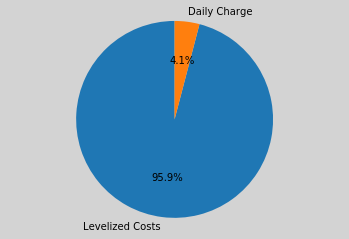

Total roof area of the  building: 599 m2
Total roof area used 561 m2
Percentage: 93.7%
succes
[[129.32676598821428, 129.7483936730327, 130.92110311100504, 36.242567718313175, 48.32150289220589, 19.016464933617648, 0.7746109846512694, 0.7433141068142697, 0.5629377453712197, 3268.86, 315.721, 0.0, 0.0, 315.721, {'Levelized Costs': 3135.806, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602192932056, 61845.7, 560.845]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (100.50160109837908, 195.45144302319744, 124.62213351115719, 33.23327092362916, 18.993825807364406, 14.279442213287608, 0.8673622677437467, 0.48605142236857046, 0.2551953261647865)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 101
                                           a tilt of 33.2
                                           and a gcr of 0.867


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977492570877075 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 195
                                           a tilt of 19.0
                                           and a gcr of 0.486


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.793402671813965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 125
                                           a tilt of 14.3
                                           and a gcr of 0.255


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.814852714538574 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [59.7257, 257.56, 0.0]


ERROR:ga_logger:Cost: 3284.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


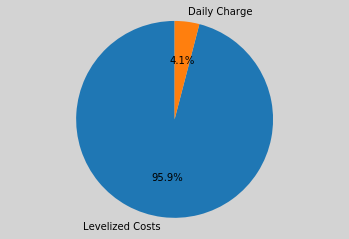

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[100.50160109837908, 195.45144302319744, 124.62213351115719, 33.23327092362916, 18.993825807364406, 14.279442213287608, 0.8673622677437467, 0.48605142236857046, 0.2551953261647865, 3284.4, 317.2857, 59.7257, 257.56, 0.0, {'Levelized Costs': 3151.341, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60065551989, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (225.64741079799725, 222.0979792284326, 213.44630641834686, 39.139519770135564, 19.514293964447234, 41.43597186208267, 0.5267582373874209, 0.720891703404059, 0.4448870665753577)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 226
                                           a tilt of 39.1
                                           and a gcr of 0.527


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.942006826400757 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 19.5
                                           and a gcr of 0.721


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.896923065185547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 41.4
                                           and a gcr of 0.445


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8333284854888916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 127.644, 187.608]


ERROR:ga_logger:Cost: 3264.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,264 per year


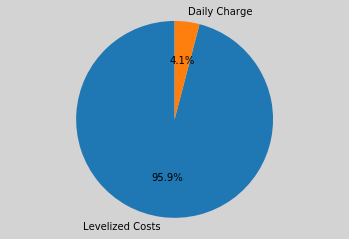

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[225.64741079799725, 222.0979792284326, 213.44630641834686, 39.139519770135564, 19.514293964447234, 41.43597186208267, 0.5267582373874209, 0.720891703404059, 0.4448870665753577, 3264.2, 315.252, 0.0, 127.644, 187.608, {'Levelized Costs': 3131.1479999999997, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600495185514, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.21940646495217, 167.73241076258344, 224.19788222535865, 36.00270955330427, 19.55233821435964, 50.12245337839806, 0.5177314377513623, 0.6623395679926558, 0.6553628621132221)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 36.0
                                           and a gcr of 0.518


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.945161819458008 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 168
                                           a tilt of 19.6
                                           and a gcr of 0.662


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7933731079101562 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 224
                                           a tilt of 50.1
                                           and a gcr of 0.655


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.798222541809082 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 304.971, 0.0]


ERROR:ga_logger:Cost: 3162.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,162 per year


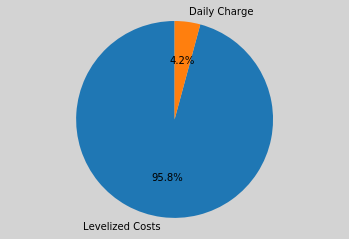

Total roof area of the  building: 599 m2
Total roof area used 460 m2
Percentage: 76.9%
succes
[[94.21940646495217, 167.73241076258344, 224.19788222535865, 36.00270955330427, 19.55233821435964, 50.12245337839806, 0.5177314377513623, 0.6623395679926558, 0.6553628621132221, 3162.09, 304.971, 0.0, 304.971, 0.0, {'Levelized Costs': 3029.037, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60170892448, 61845.7, 460.446]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (105.20089340783862, 173.63405894295806, 139.8270604403615, 41.82548352995182, 49.57483008553631, 36.47884297741623, 0.47917128485579574, 0.6577551953654523, 0.8030482596470809)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 41.8
                                           and a gcr of 0.479


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0118086338043213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 49.6
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9056663513183594 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.5
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.865046501159668 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 319.818, 0.0]


ERROR:ga_logger:Cost: 3309.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,310 per year


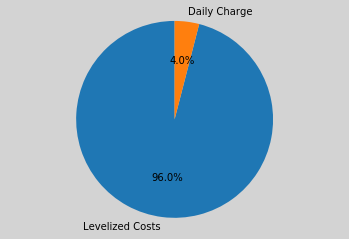

Total roof area of the  building: 599 m2
Total roof area used 486 m2
Percentage: 81.2%
succes
[[105.20089340783862, 173.63405894295806, 139.8270604403615, 41.82548352995182, 49.57483008553631, 36.47884297741623, 0.47917128485579574, 0.6577551953654523, 0.8030482596470809, 3309.55, 319.818, 0.0, 319.818, 0.0, {'Levelized Costs': 3176.491, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60105802001, 61845.7, 486.226]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.65817615893818, 218.1492809364386, 93.73517980698217, 6.748517800628879, 7.391839251934973, 14.965199886754887, 0.22659592640752108, 0.8037265033604184, 0.7534194466014488)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 6.7
                                           and a gcr of 0.227


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9229936599731445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 218
                                           a tilt of 7.4
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.804414749145508 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 94
                                           a tilt of 15.0
                                           and a gcr of 0.753


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8229312896728516 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 324.666, 0.0]


ERROR:ga_logger:Cost: 3357.7


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,358 per year


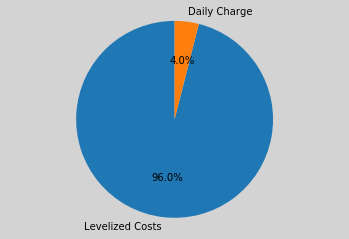

Total roof area of the  building: 599 m2
Total roof area used 404 m2
Percentage: 67.5%
succes
[[108.65817615893818, 218.1492809364386, 93.73517980698217, 6.748517800628879, 7.391839251934973, 14.965199886754887, 0.22659592640752108, 0.8037265033604184, 0.7534194466014488, 3357.7, 324.666, 0.0, 324.666, 0.0, {'Levelized Costs': 3224.6419999999994, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600902315, 61845.7, 403.95]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (112.54612565009803, 229.7542276186299, 151.0871736186707, 19.222130977116457, 24.93379084177838, 52.62382570490644, 0.39063496055694635, 0.21314014094562142, 0.6762734245466229)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 19.2
                                           and a gcr of 0.391


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.7716877460479736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 24.9
                                           and a gcr of 0.213


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.938631534576416 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 52.6
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.841332197189331 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [93.3143, 0.0, 243.379]


ERROR:ga_logger:Cost: 3477.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,477 per year


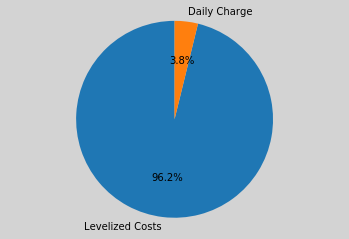

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[112.54612565009803, 229.7542276186299, 151.0871736186707, 19.222130977116457, 24.93379084177838, 52.62382570490644, 0.39063496055694635, 0.21314014094562142, 0.6762734245466229, 3477.17, 336.6933, 93.3143, 0.0, 243.379, {'Levelized Costs': 3344.111, 'Energy Charge': 0.017000000000109594, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601522300014, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (175.00897134577787, 252.87052082118154, 94.99060460756674, 53.57526452090863, 33.38776385061306, 14.346077815296116, 0.8997291564716801, 0.27818436753296416, 0.8384733992444684)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 175
                                           a tilt of 53.6
                                           and a gcr of 0.900


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9201736450195312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 33.4
                                           and a gcr of 0.278


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8755621910095215 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 14.3
                                           and a gcr of 0.838


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.806117057800293 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [259.071, 86.4647, 0.0]


ERROR:ga_logger:Cost: 3564.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,565 per year


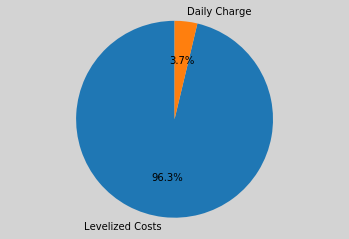

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[175.00897134577787, 252.87052082118154, 94.99060460756674, 53.57526452090863, 33.38776385061306, 14.346077815296116, 0.8997291564716801, 0.27818436753296416, 0.8384733992444684, 3564.99, 345.5357, 259.071, 86.4647, 0.0, {'Levelized Costs': 3431.932, 'Energy Charge': 0.016000000000190084, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60229561964, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (117.87367166203401, 242.25112487169784, 231.71434582775424, 26.681189451331043, 54.23548487836536, 49.648045260249205, 0.8745514931275484, 0.5298829732911569, 0.7813357574755666)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 118
                                           a tilt of 26.7
                                           and a gcr of 0.875


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.936906337738037 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 242
                                           a tilt of 54.2
                                           and a gcr of 0.530


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8309688568115234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 232
                                           a tilt of 49.6
                                           and a gcr of 0.781


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8239388465881348 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [362.413, 0.0, 0.0]


ERROR:ga_logger:Cost: 3732.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,733 per year


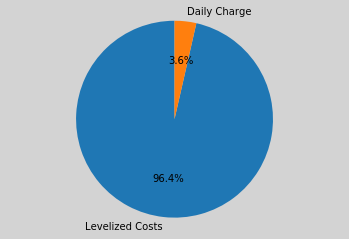

Total roof area of the  building: 599 m2
Total roof area used 414 m2
Percentage: 69.2%
succes
[[117.87367166203401, 242.25112487169784, 231.71434582775424, 26.681189451331043, 54.23548487836536, 49.648045260249205, 0.8745514931275484, 0.5298829732911569, 0.7813357574755666, 3732.61, 362.413, 362.413, 0.0, 0.0, {'Levelized Costs': 3599.554, 'Energy Charge': 0.014000000000237378, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601349690085, 61845.7, 414.398]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.54125912261037, 141.39040547869024, 193.81376826925504, 47.71059347412062, 51.24871291403591, 23.737449403190336, 0.888111255547765, 0.5324195653734811, 0.3064254259204242)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 47.7
                                           and a gcr of 0.888


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.289052963256836 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 51.2
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8378305435180664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 23.7
                                           and a gcr of 0.306


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.871772289276123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [79.7336, 270.992, 0.0]


ERROR:ga_logger:Cost: 3616.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,617 per year


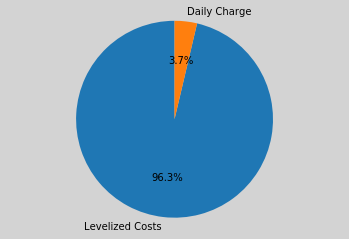

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.54125912261037, 141.39040547869024, 193.81376826925504, 47.71059347412062, 51.24871291403591, 23.737449403190336, 0.888111255547765, 0.5324195653734811, 0.3064254259204242, 3616.54, 350.7256, 79.7336, 270.992, 0.0, {'Levelized Costs': 3483.488, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59891403111, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (137.2513124059797, 167.1671600746407, 106.41321777092405, 35.59064624522948, 17.02425906419227, 43.92001293971062, 0.3009675795798203, 0.8031437396224104, 0.5701200439920415)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 35.6
                                           and a gcr of 0.301


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977431535720825 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 167
                                           a tilt of 17.0
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.817866563796997 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 43.9
                                           and a gcr of 0.570


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.803786039352417 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [102.016, 208.658, 0.0]


ERROR:ga_logger:Cost: 3218.73


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,219 per year


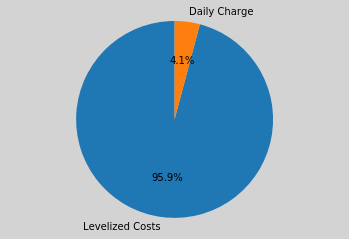

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[137.2513124059797, 167.1671600746407, 106.41321777092405, 35.59064624522948, 17.02425906419227, 43.92001293971062, 0.3009675795798203, 0.8031437396224104, 0.5701200439920415, 3218.73, 310.674, 102.016, 208.658, 0.0, {'Levelized Costs': 3085.674, 'Energy Charge': 0.014000000000294222, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60063380042, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (238.49845407167862, 227.85094205312237, 232.8710946382622, 29.966180176244766, 47.737180104954724, 13.945978787854807, 0.21085188871604638, 0.657892482602459, 0.4333928454881427)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 30.0
                                           and a gcr of 0.211


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9418821334838867 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 47.7
                                           and a gcr of 0.658


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8566904067993164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 233
                                           a tilt of 13.9
                                           and a gcr of 0.433


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9633677005767822 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [0.0, 252.286, 93.3032]


ERROR:ga_logger:Cost: 3565.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,566 per year


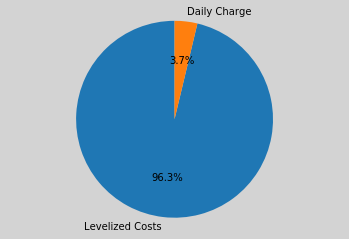

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[238.49845407167862, 227.85094205312237, 232.8710946382622, 29.966180176244766, 47.737180104954724, 13.945978787854807, 0.21085188871604638, 0.657892482602459, 0.4333928454881427, 3565.52, 345.5892, 0.0, 252.286, 93.3032, {'Levelized Costs': 3432.462, 'Energy Charge': 0.01600000000030377, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599773351176, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (238.92243720093668, 97.8503346203967, 98.58480533209571, 36.34436627564115, 2.3218925325293682, 20.023801239395265, 0.5217997142759666, 0.6860654945662912, 0.5771764285563821)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 239
                                           a tilt of 36.3
                                           and a gcr of 0.522


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0018012523651123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 98
                                           a tilt of 2.3
                                           and a gcr of 0.686


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6793417930603027 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 99
                                           a tilt of 20.0
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8247992992401123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 334.598, 0.0]


ERROR:ga_logger:Cost: 3456.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,456 per year


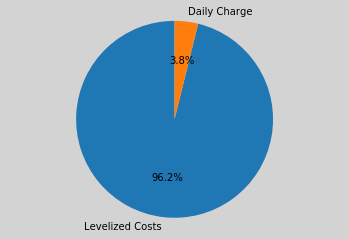

Total roof area of the  building: 599 m2
Total roof area used 488 m2
Percentage: 81.5%
succes
[[238.92243720093668, 97.8503346203967, 98.58480533209571, 36.34436627564115, 2.3218925325293682, 20.023801239395265, 0.5217997142759666, 0.6860654945662912, 0.5771764285563821, 3456.35, 334.598, 0.0, 334.598, 0.0, {'Levelized Costs': 3323.2889999999993, 'Energy Charge': 0.019000000000460204, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604261450084, 61845.7, 487.705]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.72112518717068, 252.1823113169697, 197.07453267552918, 47.73583518046906, 36.15826948286609, 41.216354605241506, 0.7344611382459438, 0.7706721625703095, 0.6850188598063613)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 47.7
                                           and a gcr of 0.734


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9845540523529053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 36.2
                                           and a gcr of 0.771


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.814147710800171 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 41.2
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8126065731048584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 315.347]


ERROR:ga_logger:Cost: 3265.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,265 per year


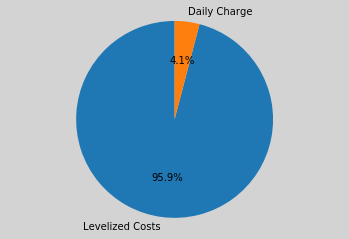

Total roof area of the  building: 599 m2
Total roof area used 460 m2
Percentage: 76.9%
succes
[[184.72112518717068, 252.1823113169697, 197.07453267552918, 47.73583518046906, 36.15826948286609, 41.216354605241506, 0.7344611382459438, 0.7706721625703095, 0.6850188598063613, 3265.15, 315.347, 0.0, 0.0, 315.347, {'Levelized Costs': 3132.09, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60011244117, 61845.7, 460.348]]
The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.69854823541357, 244.7478671083549, 250.79319650823098, 43.8969797464611, 22.385219188517873, 13.194894401934743, 0.8977376367790497, 0.5741506565766938, 0.8802681383099156)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 43.9
                                           and a gcr of 0.898


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.925318717956543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 22.4
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8236780166625977 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 251
                                           a tilt of 13.2
                                           and a gcr of 0.880


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.88303804397583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 332.743, 0.0]


ERROR:ga_logger:Cost: 3437.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,438 per year


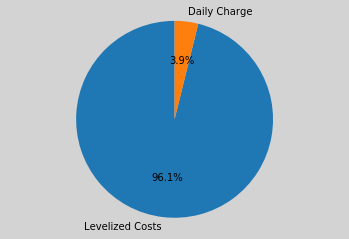

Total roof area of the  building: 599 m2
Total roof area used 580 m2
Percentage: 96.8%
succes
[[146.69854823541357, 244.7478671083549, 250.79319650823098, 43.8969797464611, 22.385219188517873, 13.194894401934743, 0.8977376367790497, 0.5741506565766938, 0.8802681383099156, 3437.92, 332.743, 0.0, 332.743, 0.0, {'Levelized Costs': 3304.869, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60200586651, 61845.7, 579.539]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.46960272656094, 263.37726960078976, 254.10572163242765, 36.25090551122118, 12.559485291578318, 36.18686588158217, 0.8922202271704851, 0.8250844135638973, 0.3756162950045157)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 36.3
                                           and a gcr of 0.892


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9893016815185547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 263
                                           a tilt of 12.6
                                           and a gcr of 0.825


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.428792715072632 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 36.2
                                           and a gcr of 0.376


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8382577896118164 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [327.772, 0.0, 0.0]


ERROR:ga_logger:Cost: 3388.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,389 per year


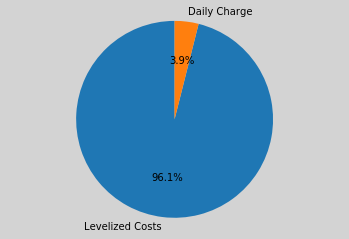

Total roof area of the  building: 599 m2
Total roof area used 367 m2
Percentage: 61.4%
succes
[[168.46960272656094, 263.37726960078976, 254.10572163242765, 36.25090551122118, 12.559485291578318, 36.18686588158217, 0.8922202271704851, 0.8250844135638973, 0.3756162950045157, 3388.55, 327.772, 327.772, 0.0, 0.0, {'Levelized Costs': 3255.4860000000003, 'Energy Charge': 0.022000000000048203, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602199704794, 61845.7, 367.367]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.18308903036845, 131.80366970657798, 159.61605980262922, 17.49569046991295, 53.158949459642145, 21.425364700948826, 0.8040599943105018, 0.8131712076707736, 0.895418805471206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 17.5
                                           and a gcr of 0.804


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.938673496246338 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 53.2
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.795771598815918 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 21.4
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8195719718933105 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [313.092, 0.0, 0.0]


ERROR:ga_logger:Cost: 3242.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,243 per year


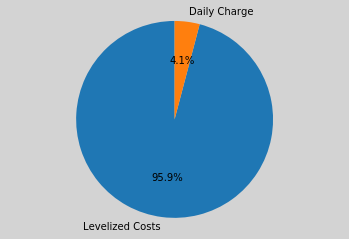

Total roof area of the  building: 599 m2
Total roof area used 389 m2
Percentage: 65.0%
succes
[[168.18308903036845, 131.80366970657798, 159.61605980262922, 17.49569046991295, 53.158949459642145, 21.425364700948826, 0.8040599943105018, 0.8131712076707736, 0.895418805471206, 3242.75, 313.092, 313.092, 0.0, 0.0, {'Levelized Costs': 3109.6910000000003, 'Energy Charge': 0.016999999999995907, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601139423896, 61845.7, 389.389]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.28719903922807, 248.73109983172068, 175.2080595492747, 12.106984457985126, 4.836739653705049, 49.2232057823951, 0.21012946818909412, 0.6674089322954375, 0.6833137402304696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 12.1
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.958726644515991 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 4.8
                                           and a gcr of 0.667


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8286211490631104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 49.2
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.818363904953003 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [39.5053, 0.0, 280.676]


ERROR:ga_logger:Cost: 3313.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,313 per year


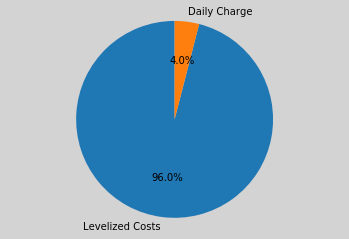

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.28719903922807, 248.73109983172068, 175.2080595492747, 12.106984457985126, 4.836739653705049, 49.2232057823951, 0.21012946818909412, 0.6674089322954375, 0.6833137402304696, 3313.16, 320.18129999999996, 39.5053, 0.0, 280.676, {'Levelized Costs': 3180.109, 'Energy Charge': 0.009000000000185082, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60322511619, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (205.48987340116958, 197.41171522420467, 192.03253003225302, 25.53920379708081, 52.822332368163046, 1.005009405789052, 0.26035918253880963, 0.4309691991448166, 0.5484963968608831)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 205
                                           a tilt of 25.5
                                           and a gcr of 0.260


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0087380409240723 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 197
                                           a tilt of 52.8
                                           and a gcr of 0.431


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.030505657196045 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 1.0
                                           and a gcr of 0.548


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 1.9651200771331787 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 328.419]


ERROR:ga_logger:Cost: 3510.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0019 /kWh
Total Cost of the system: $ 3,510 per year


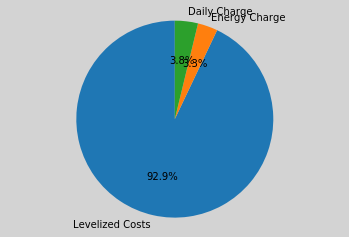

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[205.48987340116958, 197.41171522420467, 192.03253003225302, 25.53920379708081, 52.822332368163046, 1.005009405789052, 0.26035918253880963, 0.4309691991448166, 0.5484963968608831, 3510.06, 328.419, 0.0, 0.0, 328.419, {'Levelized Costs': 3261.9139999999998, 'Energy Charge': 115.10400000000027, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60927.140523627364, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (91.20092605763536, 103.89677479818013, 248.12505439768253, 40.06879517864894, 25.402023776497902, 20.311314420155114, 0.7945662519563221, 0.7403796576064179, 0.8900377609190822)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 91
                                           a tilt of 40.1
                                           and a gcr of 0.795


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.980891466140747 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 104
                                           a tilt of 25.4
                                           and a gcr of 0.740


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8386287689208984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 248
                                           a tilt of 20.3
                                           and a gcr of 0.890


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8272228240966797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 359.981, 0.0]


ERROR:ga_logger:Cost: 3708.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,708 per year


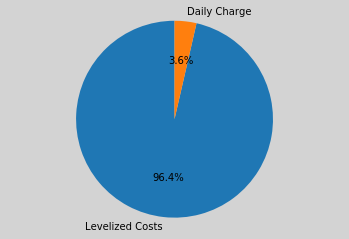

Total roof area of the  building: 599 m2
Total roof area used 486 m2
Percentage: 81.2%
succes
[[91.20092605763536, 103.89677479818013, 248.12505439768253, 40.06879517864894, 25.402023776497902, 20.311314420155114, 0.7945662519563221, 0.7403796576064179, 0.8900377609190822, 3708.46, 359.981, 0.0, 359.981, 0.0, {'Levelized Costs': 3575.4030000000002, 'Energy Charge': 0.01499999999987267, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60185719998, 61845.7, 486.212]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.18900776175298, 180.43085296248302, 258.7116035714299, 51.454237332360705, 6.255285682917591, 18.726857823884888, 0.3667258957610442, 0.7970980758328174, 0.6465735944914048)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 51.5
                                           and a gcr of 0.367


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0197768211364746 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 6.3
                                           and a gcr of 0.797


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0682454109191895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 259
                                           a tilt of 18.7
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8434066772460938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 320.89, 0.0]


ERROR:ga_logger:Cost: 3320.2


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,320 per year


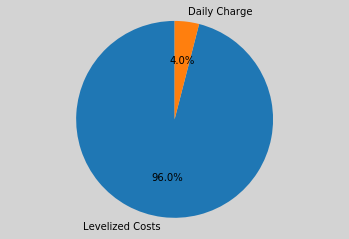

Total roof area of the  building: 599 m2
Total roof area used 403 m2
Percentage: 67.2%
succes
[[241.18900776175298, 180.43085296248302, 258.7116035714299, 51.454237332360705, 6.255285682917591, 18.726857823884888, 0.3667258957610442, 0.7970980758328174, 0.6465735944914048, 3320.2, 320.89, 0.0, 320.89, 0.0, {'Levelized Costs': 3187.149, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600243456705, 61845.7, 402.573]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.16386506440165, 191.02530230170254, 159.69125988765282, 38.29919619567193, 55.968697700035136, 35.09008466103402, 0.7383552923859833, 0.8361877921442717, 0.32290393257791106)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 241
                                           a tilt of 38.3
                                           and a gcr of 0.738


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.935924768447876 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 56.0
                                           and a gcr of 0.836


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8635785579681396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 35.1
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8250904083251953 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 218.365, 109.018]


ERROR:ga_logger:Cost: 3384.69


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


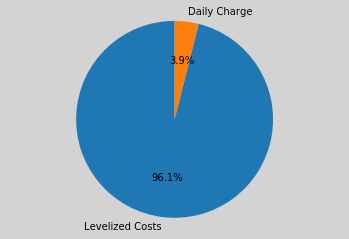

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[241.16386506440165, 191.02530230170254, 159.69125988765282, 38.29919619567193, 55.968697700035136, 35.09008466103402, 0.7383552923859833, 0.8361877921442717, 0.32290393257791106, 3384.69, 327.38300000000004, 0.0, 218.365, 109.018, {'Levelized Costs': 3251.633, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60237958433, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (256.47225505199384, 204.47304473697642, 234.68104870013323, 54.399966930498884, 53.34690764425577, 21.065202800393546, 0.3872744409389639, 0.30012025367842315, 0.5141038234502)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 54.4
                                           and a gcr of 0.387


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.035454511642456 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 204
                                           a tilt of 53.3
                                           and a gcr of 0.300


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.84079909324646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 21.1
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.813289165496826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.826]


ERROR:ga_logger:Cost: 3513.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0052 /kWh
Total Cost of the system: $ 3,513 per year


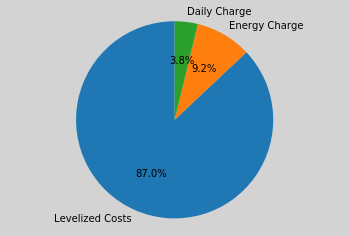

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[256.47225505199384, 204.47304473697642, 234.68104870013323, 54.399966930498884, 53.34690764425577, 21.065202800393546, 0.3872744409389639, 0.30012025367842315, 0.5141038234502, 3513.34, 307.826, 0.0, 0.0, 307.826, {'Levelized Costs': 3057.3790000000004, 'Energy Charge': 322.91899999999987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 59268.58161664305, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (103.43569682183723, 182.17261810263972, 200.54076451181436, 45.373603463934714, 26.163586572985892, 52.94380927098267, 0.8591783964021895, 0.339994189951743, 0.8552684076995751)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 103
                                           a tilt of 45.4
                                           and a gcr of 0.859


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9485528469085693 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 26.2
                                           and a gcr of 0.340


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8873937129974365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 201
                                           a tilt of 52.9
                                           and a gcr of 0.855


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.80823016166687 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 121.831, 205.631]


ERROR:ga_logger:Cost: 3385.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


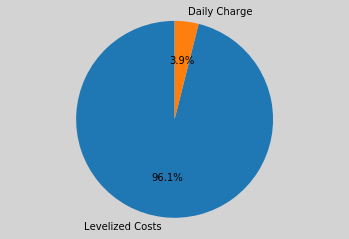

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[103.43569682183723, 182.17261810263972, 200.54076451181436, 45.373603463934714, 26.163586572985892, 52.94380927098267, 0.8591783964021895, 0.339994189951743, 0.8552684076995751, 3385.48, 327.462, 0.0, 121.831, 205.631, {'Levelized Costs': 3252.4239999999995, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60015727103, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (251.05091203357156, 179.90449482438225, 139.2426463869189, 37.67143967382512, 1.880614222393869, 48.7457483007278, 0.2763842692394999, 0.30220428015387296, 0.5665279971803492)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 251
                                           a tilt of 37.7
                                           and a gcr of 0.276


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.994042158126831 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 1.9
                                           and a gcr of 0.302


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.6978228092193604 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 48.7
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8033580780029297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 3.85011, 331.998]


ERROR:ga_logger:Cost: 3468.76


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,469 per year


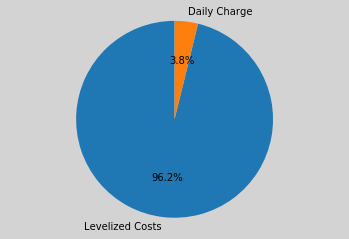

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[251.05091203357156, 179.90449482438225, 139.2426463869189, 37.67143967382512, 1.880614222393869, 48.7457483007278, 0.2763842692394999, 0.30220428015387296, 0.5665279971803492, 3468.76, 335.84810999999996, 0.0, 3.85011, 331.998, {'Levelized Costs': 3335.695, 'Energy Charge': 0.023000000000024556, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60327240007, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (115.61903257618792, 125.01257449010009, 255.10906539739182, 17.199207509570314, 28.84192345287495, 49.446363446683804, 0.2580792820689371, 0.331244605825722, 0.8299611729856013)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 116
                                           a tilt of 17.2
                                           and a gcr of 0.258


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9524950981140137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 125
                                           a tilt of 28.8
                                           and a gcr of 0.331


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8244881629943848 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 49.4
                                           and a gcr of 0.830


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.835341215133667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 44.3071, 385.934]


ERROR:ga_logger:Cost: 4406.3


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 4,406 per year


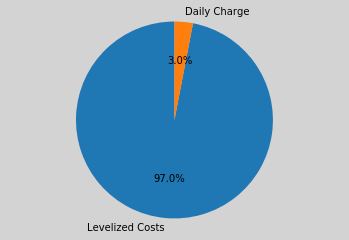

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[115.61903257618792, 125.01257449010009, 255.10906539739182, 17.199207509570314, 28.84192345287495, 49.446363446683804, 0.2580792820689371, 0.331244605825722, 0.8299611729856013, 4406.3, 430.2411, 0.0, 44.3071, 385.934, {'Levelized Costs': 4273.241999999999, 'Energy Charge': 0.016000000000417458, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59967133599, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (208.63882475539774, 154.12233916762756, 106.19578219998401, 5.63885293333666, 13.92909971721459, 53.79210556363069, 0.7276564786100548, 0.5352882163833725, 0.4697114079958269)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 209
                                           a tilt of 5.6
                                           and a gcr of 0.728


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4293718338012695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 154
                                           a tilt of 13.9
                                           and a gcr of 0.535


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8075995445251465 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 106
                                           a tilt of 53.8
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8284220695495605 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 308.863, 0.0]


ERROR:ga_logger:Cost: 3200.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,201 per year


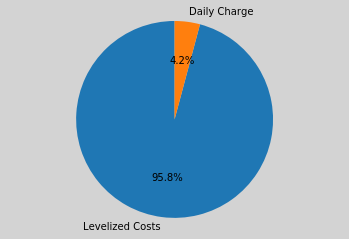

Total roof area of the  building: 599 m2
Total roof area used 577 m2
Percentage: 96.4%
succes
[[208.63882475539774, 154.12233916762756, 106.19578219998401, 5.63885293333666, 13.92909971721459, 53.79210556363069, 0.7276564786100548, 0.5352882163833725, 0.4697114079958269, 3200.75, 308.863, 0.0, 308.863, 0.0, {'Levelized Costs': 3067.689, 'Energy Charge': 0.019000000000175987, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60164274025, 61845.7, 577.004]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (146.8315400748728, 226.0230316220882, 179.23030356239252, 19.450898277702198, 55.38327091018583, 2.3189267776148665, 0.39929810782567826, 0.28157313488184516, 0.7250982737839307)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 19.5
                                           and a gcr of 0.399


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2084643840789795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 226
                                           a tilt of 55.4
                                           and a gcr of 0.282


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1481902599334717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 2.3
                                           and a gcr of 0.725


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.96401309967041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [142.91, 0.0, 174.646]


ERROR:ga_logger:Cost: 3287.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,287 per year


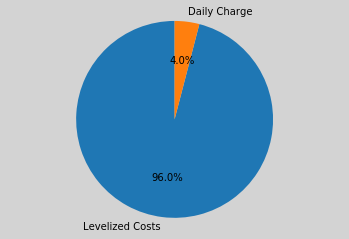

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[146.8315400748728, 226.0230316220882, 179.23030356239252, 19.450898277702198, 55.38327091018583, 2.3189267776148665, 0.39929810782567826, 0.28157313488184516, 0.7250982737839307, 3287.09, 317.556, 142.91, 0.0, 174.646, {'Levelized Costs': 3154.039, 'Energy Charge': 0.009000000000128239, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60241941261, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (243.4619055481189, 121.96080738107317, 118.67138711591718, 31.425138685717283, 17.617702705658132, 28.642730551198277, 0.5784973906371277, 0.8098423393488063, 0.6142942797607379)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 243
                                           a tilt of 31.4
                                           and a gcr of 0.578


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9446210861206055 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 122
                                           a tilt of 17.6
                                           and a gcr of 0.810


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843169689178467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 28.6
                                           and a gcr of 0.614


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.827648162841797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 335.016]


ERROR:ga_logger:Cost: 3460.5


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,460 per year


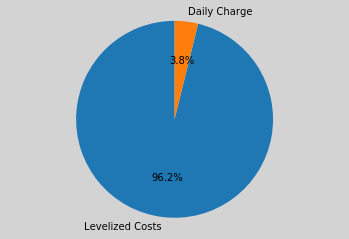

Total roof area of the  building: 599 m2
Total roof area used 545 m2
Percentage: 91.1%
succes
[[243.4619055481189, 121.96080738107317, 118.67138711591718, 31.425138685717283, 17.617702705658132, 28.642730551198277, 0.5784973906371277, 0.8098423393488063, 0.6142942797607379, 3460.5, 335.016, 0.0, 0.0, 335.016, {'Levelized Costs': 3327.439, 'Energy Charge': 0.019000000000119144, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60131894005, 61845.7, 545.367]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240.386954127862, 264.305058597628, 138.37204874331596, 7.9894145537885946, 31.329455878627243, 27.435132832699022, 0.8631152300750484, 0.470131666878153, 0.6375428787013537)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 8.0
                                           and a gcr of 0.863


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.141031265258789 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 31.3
                                           and a gcr of 0.470


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.880614757537842 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 138
                                           a tilt of 27.4
                                           and a gcr of 0.638


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.827709674835205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 317.13]


ERROR:ga_logger:Cost: 3282.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,283 per year


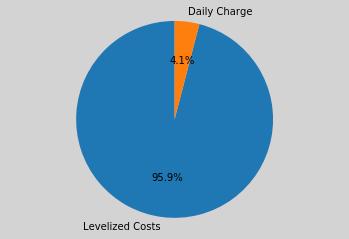

Total roof area of the  building: 599 m2
Total roof area used 497 m2
Percentage: 83.1%
succes
[[240.386954127862, 264.305058597628, 138.37204874331596, 7.9894145537885946, 31.329455878627243, 27.435132832699022, 0.8631152300750484, 0.470131666878153, 0.6375428787013537, 3282.85, 317.13, 0.0, 0.0, 317.13, {'Levelized Costs': 3149.796, 'Energy Charge': 0.012000000000341515, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60054105001, 61845.7, 497.425]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.32519888728913, 164.0372682060393, 192.11638270461083, 29.72744596555617, 17.063123683669474, 21.837933781060105, 0.7771414618323964, 0.8834029517217739, 0.25407058105863367)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 29.7
                                           and a gcr of 0.777


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9510340690612793 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 164
                                           a tilt of 17.1
                                           and a gcr of 0.883


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8177175521850586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 21.8
                                           and a gcr of 0.254


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8388850688934326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 226.809, 86.8963]


ERROR:ga_logger:Cost: 3248.85


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


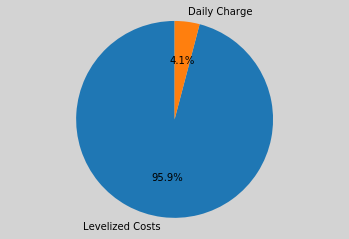

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.32519888728913, 164.0372682060393, 192.11638270461083, 29.72744596555617, 17.063123683669474, 21.837933781060105, 0.7771414618323964, 0.8834029517217739, 0.25407058105863367, 3248.85, 313.70529999999997, 0.0, 226.809, 86.8963, {'Levelized Costs': 3115.803, 'Energy Charge': 0.005000000000109139, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60308049383, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.28004048885109, 174.09437508945862, 141.29394828860737, 28.770325532271038, 45.29247720288138, 18.939419338279162, 0.4699139940520568, 0.4467490650679744, 0.3800534007089309)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 147
                                           a tilt of 28.8
                                           and a gcr of 0.470


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9625589847564697 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 174
                                           a tilt of 45.3
                                           and a gcr of 0.447


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.835495710372925 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 18.9
                                           and a gcr of 0.380


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8130064010620117 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [281.366, 0.0, 0.0]


ERROR:ga_logger:Cost: 3482.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0090 /kWh
Total Cost of the system: $ 3,483 per year


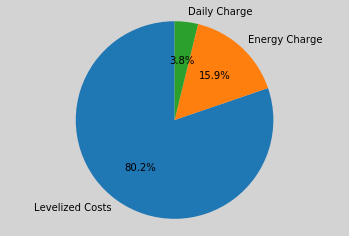

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[147.28004048885109, 174.09437508945862, 141.29394828860737, 28.770325532271038, 45.29247720288138, 18.939419338279162, 0.4699139940520568, 0.4467490650679744, 0.3800534007089309, 3482.54, 281.366, 281.366, 0.0, 0.0, {'Levelized Costs': 2794.58, 'Energy Charge': 554.9180000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 57417.040525729964, 61845.7, 598.762]]


ERROR:optimizer_logger:100


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (188.18560486146143, 140.496722192489, 236.85831833871788, 39.707452595668286, 53.101971565921886, 36.50475166488012, 0.8206299454082946, 0.6077898511448893, 0.5832507814667003)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 188
                                           a tilt of 39.7
                                           and a gcr of 0.821


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0263864994049072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 140
                                           a tilt of 53.1
                                           and a gcr of 0.608


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.796046257019043 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 36.5
                                           and a gcr of 0.583


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8085620403289795 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [319.69, 0.0, 0.0]


ERROR:ga_logger:Cost: 3308.29


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


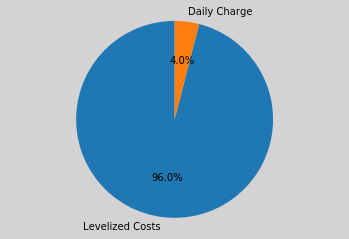

Total roof area of the  building: 599 m2
Total roof area used 390 m2
Percentage: 65.1%
succes
[[188.18560486146143, 140.496722192489, 236.85831833871788, 39.707452595668286, 53.101971565921886, 36.50475166488012, 0.8206299454082946, 0.6077898511448893, 0.5832507814667003, 3308.29, 319.69, 319.69, 0.0, 0.0, {'Levelized Costs': 3175.23, 'Energy Charge': 0.018000000000199634, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.604176622306, 61845.7, 389.567]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (124.97106179913379, 100.19724876005311, 102.65528167072598, 30.275351405635423, 7.842486466245459, 35.358404813057646, 0.45981898152004597, 0.2473202324813218, 0.32065162038494693)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 125
                                           a tilt of 30.3
                                           and a gcr of 0.460


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.876526117324829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 100
                                           a tilt of 7.8
                                           and a gcr of 0.247


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.808072328567505 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 103
                                           a tilt of 35.4
                                           and a gcr of 0.321


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8293182849884033 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 71s


ERROR:ga_logger:panel relevance: [275.322, 0.0, 0.0]


ERROR:ga_logger:Cost: 3945.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0174 /kWh
Total Cost of the system: $ 3,945 per year


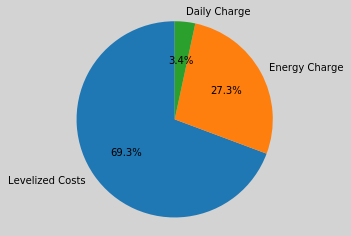

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.97106179913379, 100.19724876005311, 102.65528167072598, 30.275351405635423, 7.842486466245459, 35.358404813057646, 0.45981898152004597, 0.2473202324813218, 0.32065162038494693, 3945.09, 275.322, 275.322, 0.0, 0.0, {'Levelized Costs': 2734.5530000000003, 'Energy Charge': 1077.495, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53246.4235069, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (241.70360166321748, 256.9533602172293, 260.2110676567837, 8.896243792727056, 33.95069042450989, 29.716640904918194, 0.8914164459392463, 0.8791499872586813, 0.517626074612946)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 242
                                           a tilt of 8.9
                                           and a gcr of 0.891


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.047678232192993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 34.0
                                           and a gcr of 0.879


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.803417444229126 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 260
                                           a tilt of 29.7
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.831644058227539 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [337.094, 0.0, 0.0]


ERROR:ga_logger:Cost: 3481.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,481 per year


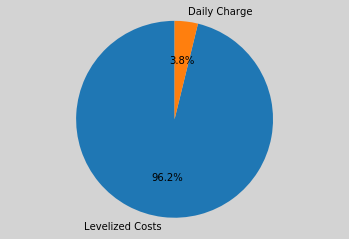

Total roof area of the  building: 599 m2
Total roof area used 378 m2
Percentage: 63.2%
succes
[[241.70360166321748, 256.9533602172293, 260.2110676567837, 8.896243792727056, 33.95069042450989, 29.716640904918194, 0.8914164459392463, 0.8791499872586813, 0.517626074612946, 3481.15, 337.094, 337.094, 0.0, 0.0, {'Levelized Costs': 3348.092, 'Energy Charge': 0.016000000000076398, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60242647631, 61845.7, 378.156]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.85290850256803, 256.86518795446585, 130.86885576241974, 34.72090810820859, 12.314890117017113, 35.81050862181935, 0.8639185570417299, 0.5283237788548747, 0.4909981795406495)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 34.7
                                           and a gcr of 0.864


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0347516536712646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 257
                                           a tilt of 12.3
                                           and a gcr of 0.528


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2290713787078857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 131
                                           a tilt of 35.8
                                           and a gcr of 0.491


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8084685802459717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [62.7042, 0.0, 258.354]


ERROR:ga_logger:Cost: 3321.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,322 per year


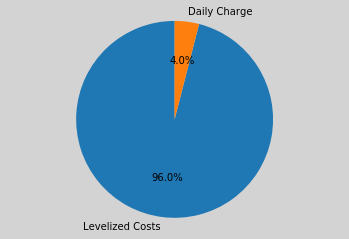

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.85290850256803, 256.86518795446585, 130.86885576241974, 34.72090810820859, 12.314890117017113, 35.81050862181935, 0.8639185570417299, 0.5283237788548747, 0.4909981795406495, 3321.87, 321.0582, 62.7042, 0.0, 258.354, {'Levelized Costs': 3188.817, 'Energy Charge': 0.011000000000080945, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60174646999, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (227.6961743322187, 255.82970551929023, 186.8157583383815, 41.82548352995182, 49.57483008553631, 42.2439046914511, 0.6423870802317915, 0.6892638815497305, 0.8460474267477005)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 228
                                           a tilt of 41.8
                                           and a gcr of 0.642


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.924537420272827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 49.6
                                           and a gcr of 0.689


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.834930181503296 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 187
                                           a tilt of 42.2
                                           and a gcr of 0.846


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.804821014404297 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 323.635]


ERROR:ga_logger:Cost: 3347.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,347 per year


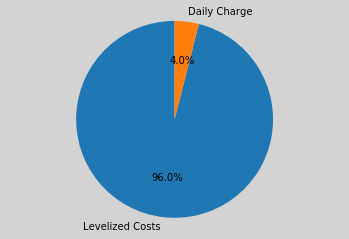

Total roof area of the  building: 599 m2
Total roof area used 383 m2
Percentage: 63.9%
succes
[[227.6961743322187, 255.82970551929023, 186.8157583383815, 41.82548352995182, 49.57483008553631, 42.2439046914511, 0.6423870802317915, 0.6892638815497305, 0.8460474267477005, 3347.46, 323.635, 0.0, 0.0, 323.635, {'Levelized Costs': 3214.402, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60085461266, 61845.7, 382.526]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (108.74917454053322, 173.19689415970015, 139.28149081923274, 19.78032115918326, 34.29224461750091, 41.00195690280613, 0.4942658726742836, 0.45249089494110195, 0.7471146959642632)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 109
                                           a tilt of 19.8
                                           and a gcr of 0.494


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9547693729400635 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 173
                                           a tilt of 34.3
                                           and a gcr of 0.452


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7971208095550537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 139
                                           a tilt of 41.0
                                           and a gcr of 0.747


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8107895851135254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 214.428, 93.2987]


ERROR:ga_logger:Cost: 3189.46


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,189 per year


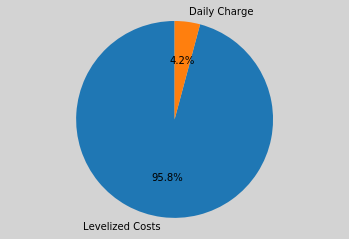

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[108.74917454053322, 173.19689415970015, 139.28149081923274, 19.78032115918326, 34.29224461750091, 41.00195690280613, 0.4942658726742836, 0.45249089494110195, 0.7471146959642632, 3189.46, 307.7267, 0.0, 214.428, 93.2987, {'Levelized Costs': 3056.399, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59987344985, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (176.24767487134406, 144.646368479775, 221.60869763816544, 40.81801286411871, 54.87062033187702, 37.386511806562595, 0.7267032007209144, 0.6724481686761413, 0.6851711968210046)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 40.8
                                           and a gcr of 0.727


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9309983253479004 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 145
                                           a tilt of 54.9
                                           and a gcr of 0.672


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.810133218765259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 222
                                           a tilt of 37.4
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0795040130615234 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [313.178, 0.0, 0.0]


ERROR:ga_logger:Cost: 3243.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,244 per year


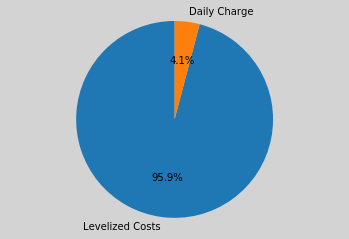

Total roof area of the  building: 599 m2
Total roof area used 431 m2
Percentage: 72.0%
succes
[[176.24767487134406, 144.646368479775, 221.60869763816544, 40.81801286411871, 54.87062033187702, 37.386511806562595, 0.7267032007209144, 0.6724481686761413, 0.6851711968210046, 3243.6, 313.178, 313.178, 0.0, 0.0, {'Levelized Costs': 3110.538, 'Energy Charge': 0.02000000000015234, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60278554011, 61845.7, 430.957]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (132.6338343024685, 169.0475962132615, 151.39404269772106, 17.65601174973272, 12.310282735991978, 18.85028846980071, 0.5167034909252322, 0.26027976612278697, 0.3570916310275571)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 133
                                           a tilt of 17.7
                                           and a gcr of 0.517


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.09403920173645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 169
                                           a tilt of 12.3
                                           and a gcr of 0.260


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7861328125 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 18.9
                                           and a gcr of 0.357


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.815142869949341 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [309.382, 0.0, 0.0]


ERROR:ga_logger:Cost: 3312.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0017 /kWh
Total Cost of the system: $ 3,312 per year


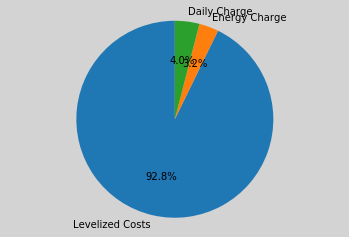

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[132.6338343024685, 169.0475962132615, 151.39404269772106, 17.65601174973272, 12.310282735991978, 18.85028846980071, 0.5167034909252322, 0.26027976612278697, 0.3570916310275571, 3312.06, 309.382, 309.382, 0.0, 0.0, {'Levelized Costs': 3072.8459999999995, 'Energy Charge': 106.17200000000037, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 60998.34479515182, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (244.81039822829067, 264.305058597628, 209.48021715229788, 15.353409303837225, 31.329455878627243, 42.626359796048014, 0.8631152300750484, 0.4778675295194072, 0.6784567256467928)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 245
                                           a tilt of 15.4
                                           and a gcr of 0.863


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9540820121765137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 31.3
                                           and a gcr of 0.478


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.880552053451538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 209
                                           a tilt of 42.6
                                           and a gcr of 0.678


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794238328933716 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 107s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 326.271]


ERROR:ga_logger:Cost: 3373.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,374 per year


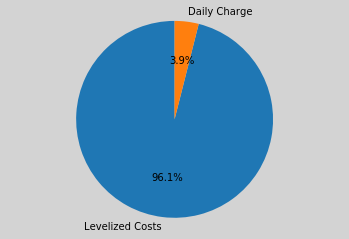

Total roof area of the  building: 599 m2
Total roof area used 481 m2
Percentage: 80.3%
succes
[[244.81039822829067, 264.305058597628, 209.48021715229788, 15.353409303837225, 31.329455878627243, 42.626359796048014, 0.8631152300750484, 0.4778675295194072, 0.6784567256467928, 3373.65, 326.271, 0.0, 0.0, 326.271, {'Levelized Costs': 3240.598, 'Energy Charge': 0.010000000000275122, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60056391414, 61845.7, 480.902]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (114.40909993854515, 190.14758245586287, 144.05888607232112, 8.211708018347434, 15.792363752071603, 39.00705206696389, 0.7271866959868528, 0.28348043409853785, 0.6440027590633075)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 114
                                           a tilt of 8.2
                                           and a gcr of 0.727


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9328691959381104 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 15.8
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.940070867538452 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 39.0
                                           and a gcr of 0.644


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8188514709472656 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 51.2844, 269.098]


ERROR:ga_logger:Cost: 3315.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,315 per year


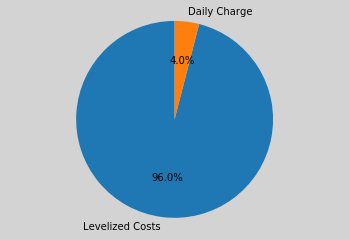

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[114.40909993854515, 190.14758245586287, 144.05888607232112, 8.211708018347434, 15.792363752071603, 39.00705206696389, 0.7271866959868528, 0.28348043409853785, 0.6440027590633075, 3315.16, 320.3824, 0.0, 51.2844, 269.098, {'Levelized Costs': 3182.1070000000004, 'Energy Charge': 0.010999999999683041, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.5983229699, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (256.47225505199384, 216.80660156464918, 230.68915767358214, 50.89379377600748, 52.93564698649391, 52.0298139814964, 0.7447905689415624, 0.6022739878109866, 0.7282197440168321)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 256
                                           a tilt of 50.9
                                           and a gcr of 0.745


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.216036081314087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 217
                                           a tilt of 52.9
                                           and a gcr of 0.602


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.885599374771118 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 52.0
                                           and a gcr of 0.728


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.825759172439575 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 345.327, 0.0]


ERROR:ga_logger:Cost: 3562.92


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,563 per year


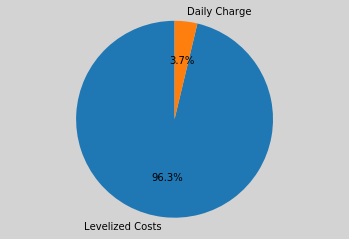

Total roof area of the  building: 599 m2
Total roof area used 573 m2
Percentage: 95.8%
succes
[[256.47225505199384, 216.80660156464918, 230.68915767358214, 50.89379377600748, 52.93564698649391, 52.0298139814964, 0.7447905689415624, 0.6022739878109866, 0.7282197440168321, 3562.92, 345.327, 0.0, 345.327, 0.0, {'Levelized Costs': 3429.859, 'Energy Charge': 0.019000000000346517, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59952736584, 61845.7, 573.373]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (231.01713136271616, 151.64451799488916, 208.47079041215312, 30.20705959825973, 14.084467250895534, 18.7881450331747, 0.4668162158248824, 0.2826238047320882, 0.5137116336610313)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 231
                                           a tilt of 30.2
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9285852909088135 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 152
                                           a tilt of 14.1
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.782536745071411 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 208
                                           a tilt of 18.8
                                           and a gcr of 0.514


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7944180965423584 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 306.699]


ERROR:ga_logger:Cost: 3179.25


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,179 per year


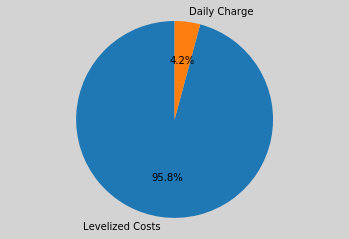

Total roof area of the  building: 599 m2
Total roof area used 597 m2
Percentage: 99.7%
succes
[[231.01713136271616, 151.64451799488916, 208.47079041215312, 30.20705959825973, 14.084467250895534, 18.7881450331747, 0.4668162158248824, 0.2826238047320882, 0.5137116336610313, 3179.25, 306.699, 0.0, 0.0, 306.699, {'Levelized Costs': 3046.1910000000003, 'Energy Charge': 0.016999999999939064, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.599665844384, 61845.7, 597.025]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (231.5617753313392, 222.40930601216945, 249.66794180029254, 36.784770029972165, 33.53623675773511, 43.42555279298725, 0.5327953040883429, 0.7189612941858439, 0.5179423869682563)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 232
                                           a tilt of 36.8
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0840742588043213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 222
                                           a tilt of 33.5
                                           and a gcr of 0.719


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9861223697662354 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 250
                                           a tilt of 43.4
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.985948085784912 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [286.294, 44.1568, 0.0]


ERROR:ga_logger:Cost: 3415.16


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,415 per year


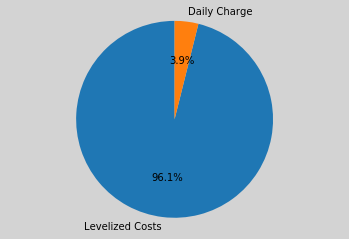

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[231.5617753313392, 222.40930601216945, 249.66794180029254, 36.784770029972165, 33.53623675773511, 43.42555279298725, 0.5327953040883429, 0.7189612941858439, 0.5179423869682563, 3415.16, 330.45079999999996, 286.294, 44.1568, 0.0, {'Levelized Costs': 3282.104, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60096154425, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165.30008989068318, 201.3157893686541, 220.281683843493, 39.49213257714824, 24.734743359795317, 39.79632447904973, 0.24895864451507096, 0.6218157598736601, 0.34736469476708204)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 39.5
                                           and a gcr of 0.249


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.042750835418701 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 201
                                           a tilt of 24.7
                                           and a gcr of 0.622


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9359560012817383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 39.8
                                           and a gcr of 0.347


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0752763748168945 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [46.4355, 256.339, 0.0]


ERROR:ga_logger:Cost: 3140.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,140 per year


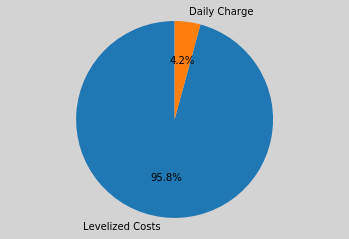

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[165.30008989068318, 201.3157893686541, 220.281683843493, 39.49213257714824, 24.734743359795317, 39.79632447904973, 0.24895864451507096, 0.6218157598736601, 0.34736469476708204, 3140.27, 302.7745, 46.4355, 256.339, 0.0, {'Levelized Costs': 3007.21, 'Energy Charge': 0.018000000000085947, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60231397482, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (184.72112518717068, 252.1823113169697, 211.66492497852332, 52.12403187620734, 36.15826948286609, 45.80942705082889, 0.7378230301000327, 0.8090312113012935, 0.6850188598063613)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 185
                                           a tilt of 52.1
                                           and a gcr of 0.738


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9523327350616455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 252
                                           a tilt of 36.2
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8261477947235107 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 212
                                           a tilt of 45.8
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8493175506591797 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [326.402, 0.0, 0.0]


ERROR:ga_logger:Cost: 3374.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 46,977 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


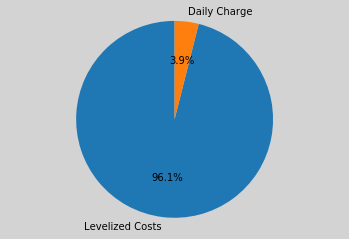

Total roof area of the  building: 599 m2
Total roof area used 442 m2
Percentage: 73.9%
succes
[[184.72112518717068, 252.1823113169697, 211.66492497852332, 52.12403187620734, 36.15826948286609, 45.80942705082889, 0.7378230301000327, 0.8090312113012935, 0.6850188598063613, 3374.94, 326.402, 326.402, 0.0, 0.0, {'Levelized Costs': 3241.886, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60163192626, 46976.6, 442.385]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.08088509386607, 185.29202814885247, 190.8635515106568, 17.57117487812625, 3.699712703060168, 44.55493284653742, 0.3107536619289899, 0.7855794555073716, 0.4866034699245204)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 17.6
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.949867010116577 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 3.7
                                           and a gcr of 0.786


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0816662311553955 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 44.6
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941873788833618 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  13 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 37.175, 268.333]


ERROR:ga_logger:Cost: 3167.42


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,167 per year


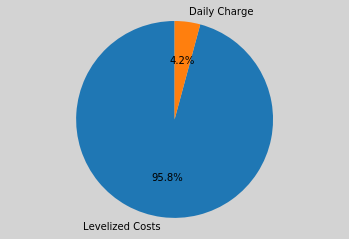

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.08088509386607, 185.29202814885247, 190.8635515106568, 17.57117487812625, 3.699712703060168, 44.55493284653742, 0.3107536619289899, 0.7855794555073716, 0.4866034699245204, 3167.42, 305.50800000000004, 0.0, 37.175, 268.333, {'Levelized Costs': 3034.3669999999997, 'Energy Charge': 0.011000000000194632, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60140845647, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (237.62647826831756, 184.66793149894005, 220.83745990295952, 46.84958311545715, 37.43177597389542, 52.17668373564524, 0.7177603729129555, 0.8691019142752746, 0.6468115829253076)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 238
                                           a tilt of 46.8
                                           and a gcr of 0.718


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941490888595581 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 185
                                           a tilt of 37.4
                                           and a gcr of 0.869


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.800710678100586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 52.2
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8067030906677246 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 320.571, 0.0]


ERROR:ga_logger:Cost: 3317.03


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 46,516 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,317 per year


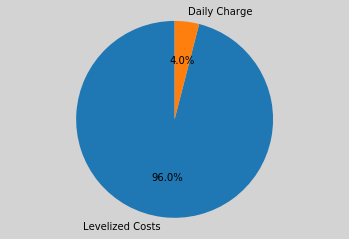

Total roof area of the  building: 599 m2
Total roof area used 369 m2
Percentage: 61.6%
succes
[[237.62647826831756, 184.66793149894005, 220.83745990295952, 46.84958311545715, 37.43177597389542, 52.17668373564524, 0.7177603729129555, 0.8691019142752746, 0.6468115829253076, 3317.03, 320.571, 0.0, 320.571, 0.0, {'Levelized Costs': 3183.9750000000004, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60179883489, 46515.9, 368.853]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.289256802424, 92.01762307163648, 202.69960698003882, 17.67637978165271, 32.67372707801945, 2.8674512125709146, 0.47370613293315184, 0.34533367891821604, 0.2766327606541642)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 17.7
                                           and a gcr of 0.474


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9075779914855957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 32.7
                                           and a gcr of 0.345


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8058366775512695 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 203
                                           a tilt of 2.9
                                           and a gcr of 0.277


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.675238609313965 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in   9 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 123 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 73s


ERROR:ga_logger:panel relevance: [283.637, 0.0, 0.0]


ERROR:ga_logger:Cost: 3629.34


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0110 /kWh
Total Cost of the system: $ 3,629 per year


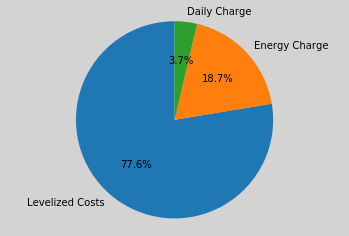

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.289256802424, 92.01762307163648, 202.69960698003882, 17.67637978165271, 32.67372707801945, 2.8674512125709146, 0.47370613293315184, 0.34533367891821604, 0.2766327606541642, 3629.34, 283.637, 283.637, 0.0, 0.0, {'Levelized Costs': 2817.1400000000003, 'Energy Charge': 679.158, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56425.448008070176, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (221.23096890194998, 191.63937350798207, 257.06327093483776, 43.12535206791548, 54.716733312873956, 52.591409850232836, 0.8041689850720557, 0.8466932797683051, 0.840697126634979)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 221
                                           a tilt of 43.1
                                           and a gcr of 0.804


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9507243633270264 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 54.7
                                           and a gcr of 0.847


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.854224920272827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 257
                                           a tilt of 52.6
                                           and a gcr of 0.841


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.793773889541626 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 100s


ERROR:ga_logger:panel relevance: [0.0, 346.04, 0.0]


ERROR:ga_logger:Cost: 3569.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 49,799 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,570 per year


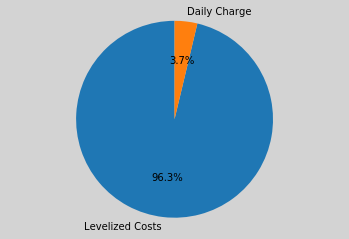

Total roof area of the  building: 599 m2
Total roof area used 409 m2
Percentage: 68.3%
succes
[[221.23096890194998, 191.63937350798207, 257.06327093483776, 43.12535206791548, 54.716733312873956, 52.591409850232836, 0.8041689850720557, 0.8466932797683051, 0.840697126634979, 3569.99, 346.04, 0.0, 346.04, 0.0, {'Levelized Costs': 3436.934, 'Energy Charge': 0.013999999999725787, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60028436199, 49799.2, 408.696]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (107.45897107970742, 143.27911267662813, 163.31114576237326, 43.64454341620951, 12.892898372269432, 32.12529159346326, 0.5218829294315928, 0.4935377306690314, 0.32290393257791106)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 107
                                           a tilt of 43.6
                                           and a gcr of 0.522


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.921603202819824 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 12.9
                                           and a gcr of 0.494


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.761730909347534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 163
                                           a tilt of 32.1
                                           and a gcr of 0.323


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.785905361175537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [0.0, 295.511, 0.0]


ERROR:ga_logger:Cost: 3484.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0067 /kWh
Total Cost of the system: $ 3,485 per year


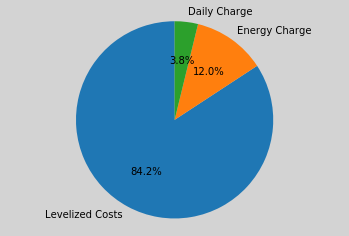

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[107.45897107970742, 143.27911267662813, 163.31114576237326, 43.64454341620951, 12.892898372269432, 32.12529159346326, 0.5218829294315928, 0.4935377306690314, 0.32290393257791106, 3484.67, 295.511, 0.0, 295.511, 0.0, {'Levelized Costs': 2935.073, 'Energy Charge': 416.5550000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58521.31315186013, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (240.386954127862, 264.305058597628, 203.6953922957945, 24.99247594215685, 31.253842730136704, 41.76636336708793, 0.8580773133782861, 0.790358957622028, 0.6355646624608893)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 25.0
                                           and a gcr of 0.858


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.042701482772827 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 31.3
                                           and a gcr of 0.790


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8089160919189453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 41.8
                                           and a gcr of 0.636


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.829340934753418 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 316.743]


ERROR:ga_logger:Cost: 3279.01


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,279 per year


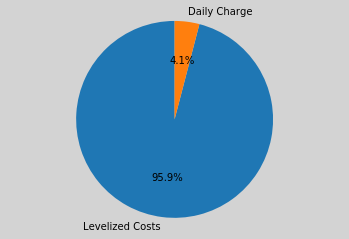

Total roof area of the  building: 599 m2
Total roof area used 498 m2
Percentage: 83.2%
succes
[[240.386954127862, 264.305058597628, 203.6953922957945, 24.99247594215685, 31.253842730136704, 41.76636336708793, 0.8580773133782861, 0.790358957622028, 0.6355646624608893, 3279.01, 316.743, 0.0, 0.0, 316.743, {'Levelized Costs': 3145.9500000000003, 'Energy Charge': 0.017999999999915417, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59972141433, 61845.7, 498.365]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.49020316517857, 181.569794604761, 122.00669659870509, 10.98660928477652, 5.874496043791391, 30.874258758914134, 0.3107536619289899, 0.4607010557890484, 0.3942121887029215)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 11.0
                                           and a gcr of 0.311


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.6115806102752686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 182
                                           a tilt of 5.9
                                           and a gcr of 0.461


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.594458818435669 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 122
                                           a tilt of 30.9
                                           and a gcr of 0.394


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8340797424316406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [0.0, 275.85, 0.0]


ERROR:ga_logger:Cost: 3951.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0174 /kWh
Total Cost of the system: $ 3,952 per year


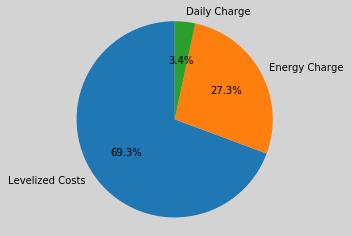

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[180.49020316517857, 181.569794604761, 122.00669659870509, 10.98660928477652, 5.874496043791391, 30.874258758914134, 0.3107536619289899, 0.4607010557890484, 0.3942121887029215, 3951.72, 275.85, 0.0, 275.85, 0.0, {'Levelized Costs': 2739.8079999999995, 'Energy Charge': 1078.8700000000001, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 53235.387106082206, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.09532502965357, 140.75525279792933, 146.09357032718458, 17.49569046991295, 52.88155717357251, 21.425364700948826, 0.7945694218620156, 0.8279961660418855, 0.8984547764991964)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 17.5
                                           and a gcr of 0.795


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.941952705383301 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 141
                                           a tilt of 52.9
                                           and a gcr of 0.828


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843242645263672 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 21.4
                                           and a gcr of 0.898


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.853201389312744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [312.453, 0.0, 0.0]


ERROR:ga_logger:Cost: 3236.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,236 per year


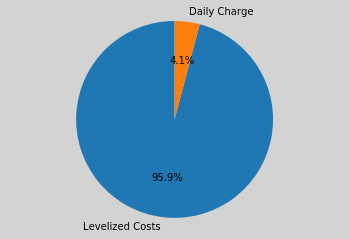

Total roof area of the  building: 599 m2
Total roof area used 393 m2
Percentage: 65.7%
succes
[[168.09532502965357, 140.75525279792933, 146.09357032718458, 17.49569046991295, 52.88155717357251, 21.425364700948826, 0.7945694218620156, 0.8279961660418855, 0.8984547764991964, 3236.4, 312.453, 312.453, 0.0, 0.0, {'Levelized Costs': 3103.34, 'Energy Charge': 0.01799999999997226, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60099903191, 61845.7, 393.236]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (165.53884910416267, 129.5831825370089, 137.0091887281004, 17.49569046991295, 49.6201084298723, 21.301000222363502, 0.7889787290358814, 0.8131712076707736, 0.895418805471206)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 17.5
                                           and a gcr of 0.789


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1726090908050537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 130
                                           a tilt of 49.6
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0802345275878906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 21.3
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.066145896911621 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [312.611, 0.0, 0.0]


ERROR:ga_logger:Cost: 3237.97


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,238 per year


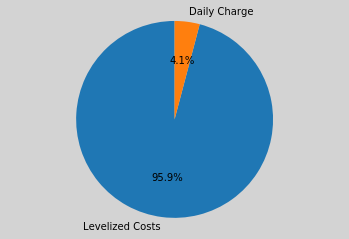

Total roof area of the  building: 599 m2
Total roof area used 396 m2
Percentage: 66.2%
succes
[[165.53884910416267, 129.5831825370089, 137.0091887281004, 17.49569046991295, 49.6201084298723, 21.301000222363502, 0.7889787290358814, 0.8131712076707736, 0.895418805471206, 3237.97, 312.611, 312.611, 0.0, 0.0, {'Levelized Costs': 3104.919, 'Energy Charge': 0.009000000000014552, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60022399524, 61845.7, 396.223]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (186.50049643868005, 247.65522861635634, 230.3792754632323, 47.810844288076495, 53.40411514254636, 39.458981027085244, 0.7627473457391084, 0.765144705708952, 0.6791791648595449)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 187
                                           a tilt of 47.8
                                           and a gcr of 0.763


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2018630504608154 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 248
                                           a tilt of 53.4
                                           and a gcr of 0.765


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0872204303741455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 39.5
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0971453189849854 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [322.751, 0.0, 0.0]


ERROR:ga_logger:Cost: 3338.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,339 per year


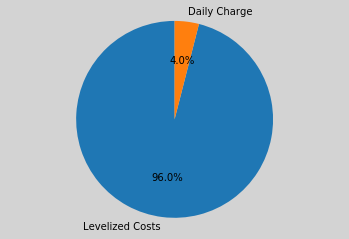

Total roof area of the  building: 599 m2
Total roof area used 423 m2
Percentage: 70.7%
succes
[[186.50049643868005, 247.65522861635634, 230.3792754632323, 47.810844288076495, 53.40411514254636, 39.458981027085244, 0.7627473457391084, 0.765144705708952, 0.6791791648595449, 3338.68, 322.751, 322.751, 0.0, 0.0, {'Levelized Costs': 3205.625, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60022199808, 61845.7, 423.143]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.13530073653219, 188.07751389022866, 182.78532129831248, 17.46417428682765, 35.16473916337704, 37.33049275040829, 0.7369382189975332, 0.6732433190903724, 0.3747021474953676)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 17.5
                                           and a gcr of 0.737


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2013473510742188 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 35.2
                                           and a gcr of 0.673


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1159489154815674 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 183
                                           a tilt of 37.3
                                           and a gcr of 0.375


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0985333919525146 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [0.0, 169.097, 130.244]


ERROR:ga_logger:Cost: 3106.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,106 per year


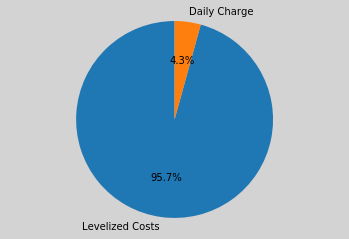

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.13530073653219, 188.07751389022866, 182.78532129831248, 17.46417428682765, 35.16473916337704, 37.33049275040829, 0.7369382189975332, 0.6732433190903724, 0.3747021474953676, 3106.17, 299.341, 0.0, 169.097, 130.244, {'Levelized Costs': 2973.112, 'Energy Charge': 0.01600000000013324, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60248959953, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.47997951049751, 252.71509434455277, 221.19475861519976, 48.69171598658012, 49.20209198254693, 12.14388583535993, 0.36590409115920014, 0.746304332747284, 0.8287266574260256)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 169
                                           a tilt of 48.7
                                           and a gcr of 0.366


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.194220542907715 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 253
                                           a tilt of 49.2
                                           and a gcr of 0.746


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0713460445404053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 12.1
                                           and a gcr of 0.829


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2125091552734375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [143.51, 0.0, 171.178]


ERROR:ga_logger:Cost: 3258.6


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,259 per year


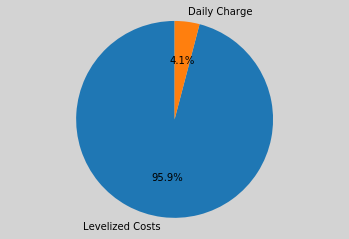

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.47997951049751, 252.71509434455277, 221.19475861519976, 48.69171598658012, 49.20209198254693, 12.14388583535993, 0.36590409115920014, 0.746304332747284, 0.8287266574260256, 3258.6, 314.688, 143.51, 0.0, 171.178, {'Levelized Costs': 3125.544, 'Energy Charge': 0.014000000000066848, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601507586936, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (124.3997833708751, 153.4531961797222, 95.22678733986302, 8.845470829958714, 31.077161933646817, 1.9551241557543335, 0.898612791657396, 0.2963745585683994, 0.3692436695168497)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 124
                                           a tilt of 8.8
                                           and a gcr of 0.899


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.139488697052002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 153
                                           a tilt of 31.1
                                           and a gcr of 0.296


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0681121349334717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 95
                                           a tilt of 2.0
                                           and a gcr of 0.369


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.97011137008667 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [212.116, 107.499, 0.0]


ERROR:ga_logger:Cost: 3307.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,308 per year


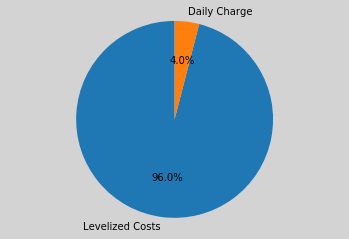

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[124.3997833708751, 153.4531961797222, 95.22678733986302, 8.845470829958714, 31.077161933646817, 1.9551241557543335, 0.898612791657396, 0.2963745585683994, 0.3692436695168497, 3307.54, 319.615, 212.116, 107.499, 0.0, {'Levelized Costs': 3174.485, 'Energy Charge': 0.013000000000033651, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60020702299, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (96.23496671113514, 176.55533919562848, 255.0520140743891, 19.849382520402294, 42.01051788571077, 35.09929096219304, 0.6841989276797611, 0.8772976266865107, 0.7174433262632233)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 96
                                           a tilt of 19.8
                                           and a gcr of 0.684


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1737260818481445 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 42.0
                                           and a gcr of 0.877


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0231308937072754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 255
                                           a tilt of 35.1
                                           and a gcr of 0.717


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0678794384002686 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 327.427, 0.0]


ERROR:ga_logger:Cost: 3385.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,385 per year


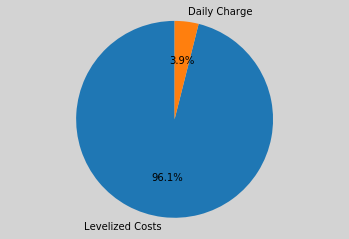

Total roof area of the  building: 599 m2
Total roof area used 373 m2
Percentage: 62.3%
succes
[[96.23496671113514, 176.55533919562848, 255.0520140743891, 19.849382520402294, 42.01051788571077, 35.09929096219304, 0.6841989276797611, 0.8772976266865107, 0.7174433262632233, 3385.13, 327.427, 0.0, 327.427, 0.0, {'Levelized Costs': 3252.071, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60166418997, 61845.7, 373.223]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (90.08400492593904, 163.45214842561637, 229.65036415138897, 18.049940176668148, 29.01331902278234, 1.6307661643127283, 0.3725323240020533, 0.4717040860982292, 0.47248966857404356)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 90
                                           a tilt of 18.0
                                           and a gcr of 0.373


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.194502353668213 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 163
                                           a tilt of 29.0
                                           and a gcr of 0.472


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0373921394348145 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 230
                                           a tilt of 1.6
                                           and a gcr of 0.472


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9116547107696533 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 282.438, 0.0]


ERROR:ga_logger:Cost: 3312.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0061 /kWh
Total Cost of the system: $ 3,313 per year


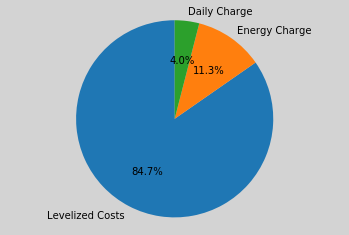

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[90.08400492593904, 163.45214842561637, 229.65036415138897, 18.049940176668148, 29.01331902278234, 1.6307661643127283, 0.3725323240020533, 0.4717040860982292, 0.47248966857404356, 3312.94, 282.438, 0.0, 282.438, 0.0, {'Levelized Costs': 2805.232, 'Energy Charge': 374.66600000000017, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58855.58992090001, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (207.54955664626783, 246.45652848807998, 174.73690025061393, 11.999116499668688, 42.370349396452326, 46.4870440189775, 0.833536041776929, 0.7733615539103911, 0.8089934437759556)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 208
                                           a tilt of 12.0
                                           and a gcr of 0.834


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.25970458984375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 246
                                           a tilt of 42.4
                                           and a gcr of 0.773


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0436794757843018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 46.5
                                           and a gcr of 0.809


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8209304809570312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [320.722, 0.0, 0.0]


ERROR:ga_logger:Cost: 3318.53


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,319 per year


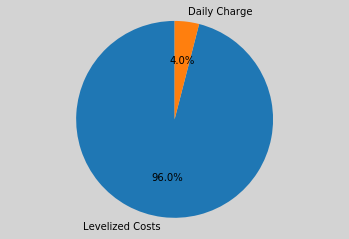

Total roof area of the  building: 599 m2
Total roof area used 385 m2
Percentage: 64.3%
succes
[[207.54955664626783, 246.45652848807998, 174.73690025061393, 11.999116499668688, 42.370349396452326, 46.4870440189775, 0.833536041776929, 0.7733615539103911, 0.8089934437759556, 3318.53, 320.722, 320.722, 0.0, 0.0, {'Levelized Costs': 3185.474, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60239004055, 61845.7, 384.773]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.28719903922807, 210.08754971421456, 136.6540435255667, 5.88625035575597, 4.836739653705049, 38.73225545801134, 0.3338272360187522, 0.746401180309024, 0.6833137402304696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 5.9
                                           and a gcr of 0.334


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2709872722625732 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 4.8
                                           and a gcr of 0.746


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.236497163772583 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 38.7
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.140066146850586 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [98.1053, 227.564, 0.0]


ERROR:ga_logger:Cost: 3367.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,368 per year


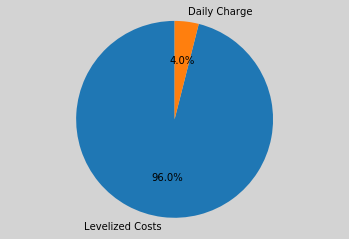

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.28719903922807, 210.08754971421456, 136.6540435255667, 5.88625035575597, 4.836739653705049, 38.73225545801134, 0.3338272360187522, 0.746401180309024, 0.6833137402304696, 3367.67, 325.6693, 98.1053, 227.564, 0.0, {'Levelized Costs': 3234.614, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.598766934505, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (164.65894867297456, 187.92603854550916, 199.3539886067036, 32.160259474902844, 51.67514503062219, 45.49284495152328, 0.29032653508934725, 0.7217756797989708, 0.4207920286180343)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 165
                                           a tilt of 32.2
                                           and a gcr of 0.290


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2882156372070312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 188
                                           a tilt of 51.7
                                           and a gcr of 0.722


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1390678882598877 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 45.5
                                           and a gcr of 0.421


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.179659128189087 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [0.0, 151.357, 163.714]


ERROR:ga_logger:Cost: 3262.4


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,262 per year


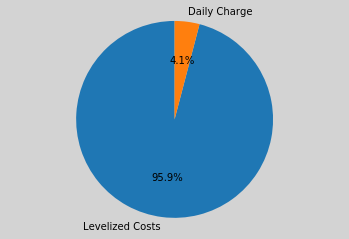

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[164.65894867297456, 187.92603854550916, 199.3539886067036, 32.160259474902844, 51.67514503062219, 45.49284495152328, 0.29032653508934725, 0.7217756797989708, 0.4207920286180343, 3262.4, 315.071, 0.0, 151.357, 163.714, {'Levelized Costs': 3129.3440000000005, 'Energy Charge': 0.013999999999896318, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60253803751, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.76765814745357, 182.86410898546166, 154.8000392128423, 28.363532920035663, 8.272676207488566, 9.084640569532155, 0.5491371575965233, 0.5494158101880284, 0.24446634825546334)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 28.4
                                           and a gcr of 0.549


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.278825283050537 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 183
                                           a tilt of 8.3
                                           and a gcr of 0.549


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2163515090942383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 155
                                           a tilt of 9.1
                                           and a gcr of 0.244


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2091033458709717 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [313.394, 0.0, 0.0]


ERROR:ga_logger:Cost: 3245.74


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,246 per year


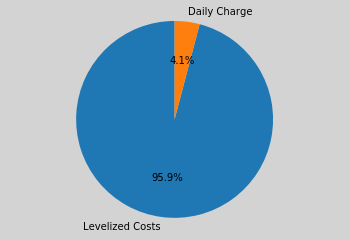

Total roof area of the  building: 599 m2
Total roof area used 571 m2
Percentage: 95.3%
succes
[[136.76765814745357, 182.86410898546166, 154.8000392128423, 28.363532920035663, 8.272676207488566, 9.084640569532155, 0.5491371575965233, 0.5494158101880284, 0.24446634825546334, 3245.74, 313.394, 313.394, 0.0, 0.0, {'Levelized Costs': 3112.6879999999996, 'Energy Charge': 0.010000000000218279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601027939956, 61845.7, 570.702]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.95292977559413, 231.2464126288572, 184.87512208708017, 32.67344732573981, 28.968186963853285, 52.62382570490644, 0.45059534592052664, 0.38357388547876076, 0.6465990281843128)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 32.7
                                           and a gcr of 0.451


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.28739070892334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 231
                                           a tilt of 29.0
                                           and a gcr of 0.384


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1930696964263916 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 185
                                           a tilt of 52.6
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.192674398422241 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [173.946, 0.0, 137.548]


ERROR:ga_logger:Cost: 3226.88


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,227 per year


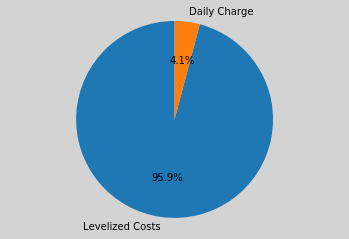

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.95292977559413, 231.2464126288572, 184.87512208708017, 32.67344732573981, 28.968186963853285, 52.62382570490644, 0.45059534592052664, 0.38357388547876076, 0.6465990281843128, 3226.88, 311.494, 173.946, 0.0, 137.548, {'Levelized Costs': 3093.824, 'Energy Charge': 0.014000000000180535, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60118582392, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (119.63963945539102, 180.24219094611905, 141.32910262845394, 19.55423073549945, 8.870073707522756, 42.042733406490356, 0.3928499007673203, 0.2664858422724584, 0.4436974174606755)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 120
                                           a tilt of 19.6
                                           and a gcr of 0.393


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.255415678024292 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 180
                                           a tilt of 8.9
                                           and a gcr of 0.266


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.8245224952697754 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 42.0
                                           and a gcr of 0.444


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2101285457611084 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 134 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 75s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 265.669]


ERROR:ga_logger:Cost: 3966.75


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0193 /kWh
Total Cost of the system: $ 3,967 per year


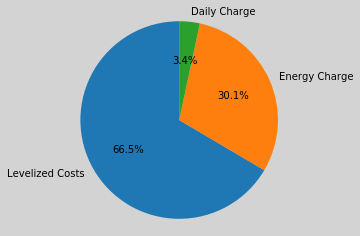

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[119.63963945539102, 180.24219094611905, 141.32910262845394, 19.55423073549945, 8.870073707522756, 42.042733406490356, 0.3928499007673203, 0.2664858422724584, 0.4436974174606755, 3966.75, 265.669, 0.0, 0.0, 265.669, {'Levelized Costs': 2638.676, 'Energy Charge': 1195.0320000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 52308.34627767011, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (143.53769325612132, 240.6522382233746, 145.9502057173416, 18.157588254025033, 23.372557397907848, 52.3975358113112, 0.5448586056558519, 0.36954333152092683, 0.8239600793056998)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 144
                                           a tilt of 18.2
                                           and a gcr of 0.545


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3890159130096436 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 241
                                           a tilt of 23.4
                                           and a gcr of 0.370


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492077350616455 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 52.4
                                           and a gcr of 0.824


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2436516284942627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 142 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [309.009, 0.0, 0.0]


ERROR:ga_logger:Cost: 3202.19


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,202 per year


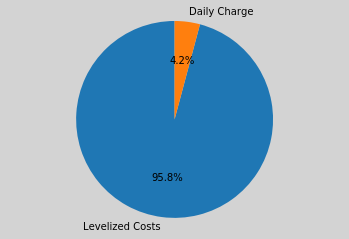

Total roof area of the  building: 599 m2
Total roof area used 567 m2
Percentage: 94.7%
succes
[[143.53769325612132, 240.6522382233746, 145.9502057173416, 18.157588254025033, 23.372557397907848, 52.3975358113112, 0.5448586056558519, 0.36954333152092683, 0.8239600793056998, 3202.19, 309.009, 309.009, 0.0, 0.0, {'Levelized Costs': 3069.137, 'Energy Charge': 0.010999999999853571, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60082105703, 61845.7, 567.135]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (112.54612565009803, 227.76169162459104, 118.52585069674957, 8.244193778691837, 19.047166472025054, 31.959885851170355, 0.4364952088753985, 0.2050837955289689, 0.6762734245466229)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 113
                                           a tilt of 8.2
                                           and a gcr of 0.436


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2988719940185547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 228
                                           a tilt of 19.0
                                           and a gcr of 0.205


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2766363620758057 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 119
                                           a tilt of 32.0
                                           and a gcr of 0.676


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2533252239227295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [119.895, 0.0, 219.17]


ERROR:ga_logger:Cost: 3500.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,501 per year


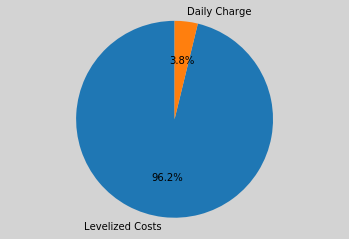

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[112.54612565009803, 227.76169162459104, 118.52585069674957, 8.244193778691837, 19.047166472025054, 31.959885851170355, 0.4364952088753985, 0.2050837955289689, 0.6762734245466229, 3500.72, 339.065, 119.895, 0.0, 219.17, {'Levelized Costs': 3367.6659999999997, 'Energy Charge': 0.012000000000398359, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.6016774499, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate


The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (262.433344592107, 149.7207904732937, 167.99860735762812, 24.143306928191333, 37.52098445532929, 21.947902535602925, 0.7018117525784211, 0.6941889977562433, 0.8760759869136854)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 262
                                           a tilt of 24.1
                                           and a gcr of 0.702


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2730276584625244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 150
                                           a tilt of 37.5
                                           and a gcr of 0.694


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1291308403015137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 21.9
                                           and a gcr of 0.876


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1873250007629395 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 319.274]


ERROR:ga_logger:Cost: 3304.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,304 per year


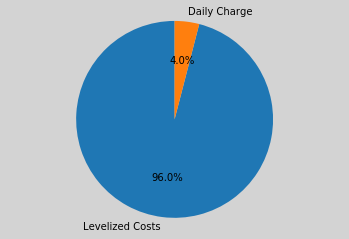

Total roof area of the  building: 599 m2
Total roof area used 364 m2
Percentage: 60.9%
succes
[[262.433344592107, 149.7207904732937, 167.99860735762812, 24.143306928191333, 37.52098445532929, 21.947902535602925, 0.7018117525784211, 0.6941889977562433, 0.8760759869136854, 3304.15, 319.274, 0.0, 0.0, 319.274, {'Levelized Costs': 3171.1040000000007, 'Energy Charge': 0.003999999999678039, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60097380133, 61845.7, 364.436]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.05825022768119, 143.28324877398845, 144.05125880729122, 37.16124492701306, 10.998321754084696, 16.42140636563043, 0.5167034909252322, 0.28293548971551274, 0.6048089680764637)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 37.2
                                           and a gcr of 0.517


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.294612407684326 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 11.0
                                           and a gcr of 0.283


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.203361988067627 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 144
                                           a tilt of 16.4
                                           and a gcr of 0.605


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.209989070892334 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [298.687, 0.0, 0.0]


ERROR:ga_logger:Cost: 3099.68


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,100 per year


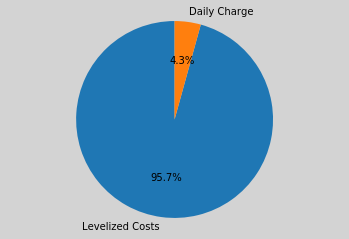

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[172.05825022768119, 143.28324877398845, 144.05125880729122, 37.16124492701306, 10.998321754084696, 16.42140636563043, 0.5167034909252322, 0.28293548971551274, 0.6048089680764637, 3099.68, 298.687, 298.687, 0.0, 0.0, {'Levelized Costs': 2966.6269999999995, 'Energy Charge': 0.011000000000251475, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60280242999, 61845.7, 578.063]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (135.90603963518862, 210.0095189582953, 228.60618018883739, 25.88014777206369, 51.3746369651252, 51.04220275403709, 0.6951044473055479, 0.7033776282147666, 0.6637824757278432)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 136
                                           a tilt of 25.9
                                           and a gcr of 0.695


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3095896244049072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 51.4
                                           and a gcr of 0.703


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.140799045562744 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 51.0
                                           and a gcr of 0.664


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1294853687286377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [322.357, 0.0, 0.0]


ERROR:ga_logger:Cost: 3334.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


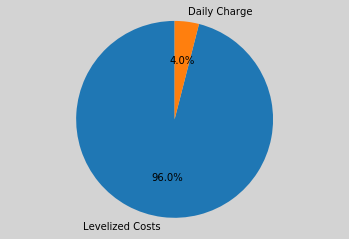

Total roof area of the  building: 599 m2
Total roof area used 464 m2
Percentage: 77.5%
succes
[[135.90603963518862, 210.0095189582953, 228.60618018883739, 25.88014777206369, 51.3746369651252, 51.04220275403709, 0.6951044473055479, 0.7033776282147666, 0.6637824757278432, 3334.77, 322.357, 322.357, 0.0, 0.0, {'Levelized Costs': 3201.71, 'Energy Charge': 0.018000000000029104, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60169608009, 61845.7, 463.754]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (110.87029074469754, 161.5863406431066, 204.38731515935166, 5.912875271592247, 36.05884467622845, 3.015517942381027, 0.3855819959924645, 0.31830097975286115, 0.3826287466795266)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 111
                                           a tilt of 5.9
                                           and a gcr of 0.386


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2999227046966553 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 162
                                           a tilt of 36.1
                                           and a gcr of 0.318


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.156287431716919 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 204
                                           a tilt of 3.0
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0019826889038086 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 135 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [230.872, 0.0, 0.0]


ERROR:ga_logger:Cost: 4739.1


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0374 /kWh
Total Cost of the system: $ 4,739 per year


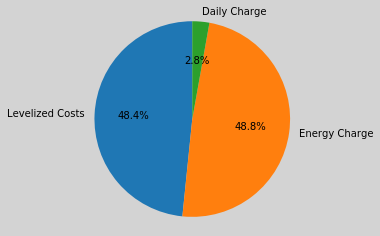

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[110.87029074469754, 161.5863406431066, 204.38731515935166, 5.912875271592247, 36.05884467622845, 3.015517942381027, 0.3855819959924645, 0.31830097975286115, 0.3826287466795266, 4739.1, 230.872, 230.872, 0.0, 0.0, {'Levelized Costs': 2293.0693000000006, 'Energy Charge': 2312.9887, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 43386.10752321686, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (166.15356244291954, 117.50224394883804, 207.24257528176574, 10.581177587640216, 50.000655462575814, 37.42257800209335, 0.23360696523604285, 0.5383754080447948, 0.4837712572152696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 166
                                           a tilt of 10.6
                                           and a gcr of 0.234


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.343212127685547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 118
                                           a tilt of 50.0
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.248145341873169 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 37.4
                                           and a gcr of 0.484


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2369327545166016 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 289.664]


ERROR:ga_logger:Cost: 3417.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0066 /kWh
Total Cost of the system: $ 3,418 per year


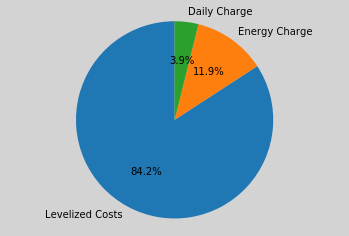

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[166.15356244291954, 117.50224394883804, 207.24257528176574, 10.581177587640216, 50.000655462575814, 37.42257800209335, 0.23360696523604285, 0.5383754080447948, 0.4837712572152696, 3417.8, 289.664, 0.0, 0.0, 289.664, {'Levelized Costs': 2876.989, 'Energy Charge': 407.76900000000023, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58591.41447641806, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.22193296915964, 101.77367111378533, 199.29562478392583, 5.020383164221441, 45.833684490964, 37.318788638219544, 0.21728326246988808, 0.5383754080447948, 0.5147179702158953)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 151
                                           a tilt of 5.0
                                           and a gcr of 0.217


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.226205825805664 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 102
                                           a tilt of 45.8
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.160168409347534 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 37.3
                                           and a gcr of 0.515


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.170097589492798 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 79s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 302.321]


ERROR:ga_logger:Cost: 3135.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,136 per year


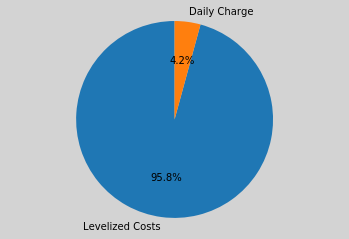

Total roof area of the  building: 599 m2
Total roof area used 587 m2
Percentage: 98.1%
succes
[[151.22193296915964, 101.77367111378533, 199.29562478392583, 5.020383164221441, 45.833684490964, 37.318788638219544, 0.21728326246988808, 0.5383754080447948, 0.5147179702158953, 3135.77, 302.321, 0.0, 0.0, 302.321, {'Levelized Costs': 3002.713, 'Energy Charge': 0.015000000000100044, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60204941224, 61845.7, 587.353]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (196.84044744170944, 224.92574712046297, 167.923322259464, 54.03479676415108, 33.69249567176636, 25.71642180412339, 0.5073879993157395, 0.8311399656540654, 0.7316582637014823)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 197
                                           a tilt of 54.0
                                           and a gcr of 0.507


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3414292335510254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 225
                                           a tilt of 33.7
                                           and a gcr of 0.831


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1896612644195557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 168
                                           a tilt of 25.7
                                           and a gcr of 0.732


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.16512131690979 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 307.774]


ERROR:ga_logger:Cost: 3189.93


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,190 per year


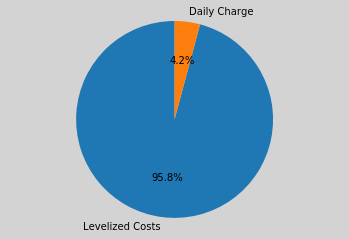

Total roof area of the  building: 599 m2
Total roof area used 421 m2
Percentage: 70.3%
succes
[[196.84044744170944, 224.92574712046297, 167.923322259464, 54.03479676415108, 33.69249567176636, 25.71642180412339, 0.5073879993157395, 0.8311399656540654, 0.7316582637014823, 3189.93, 307.774, 0.0, 0.0, 307.774, {'Levelized Costs': 3056.8749999999995, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60102435214, 61845.7, 420.652]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.60190850644472, 200.11583412574302, 119.74717300606852, 1.2565672735657536, 33.36025996839472, 13.927479198371195, 0.272389222974721, 0.6339710714507806, 0.4852845122990203)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 1.3
                                           and a gcr of 0.272


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.145564556121826 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 33.4
                                           and a gcr of 0.634


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1777637004852295 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 120
                                           a tilt of 13.9
                                           and a gcr of 0.485


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1232364177703857 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 307.02, 0.0]


ERROR:ga_logger:Cost: 3182.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,182 per year


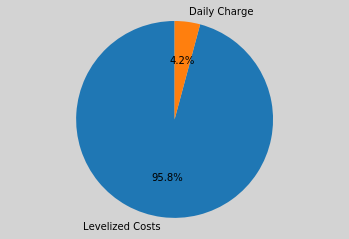

Total roof area of the  building: 599 m2
Total roof area used 484 m2
Percentage: 80.9%
succes
[[147.60190850644472, 200.11583412574302, 119.74717300606852, 1.2565672735657536, 33.36025996839472, 13.927479198371195, 0.272389222974721, 0.6339710714507806, 0.4852845122990203, 3182.44, 307.02, 0.0, 307.02, 0.0, {'Levelized Costs': 3049.377, 'Energy Charge': 0.02100000000024238, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60089810529, 61845.7, 484.281]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (207.54955664626783, 199.85023580156718, 140.26034918300442, 28.93981055193771, 42.12692216148681, 36.77828640631584, 0.8555252893922533, 0.8034204124920883, 0.7270593767227034)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 208
                                           a tilt of 28.9
                                           and a gcr of 0.856


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4191088676452637 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 200
                                           a tilt of 42.1
                                           and a gcr of 0.803


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2660770416259766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 140
                                           a tilt of 36.8
                                           and a gcr of 0.727


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2476589679718018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 133 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [328.287, 0.0, 0.0]


ERROR:ga_logger:Cost: 3393.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,394 per year


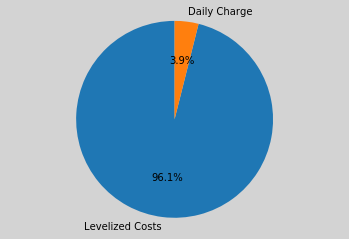

Total roof area of the  building: 599 m2
Total roof area used 384 m2
Percentage: 64.1%
succes
[[207.54955664626783, 199.85023580156718, 140.26034918300442, 28.93981055193771, 42.12692216148681, 36.77828640631584, 0.8555252893922533, 0.8034204124920883, 0.7270593767227034, 3393.67, 328.287, 328.287, 0.0, 0.0, {'Levelized Costs': 3260.61, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.602998745344, 61845.7, 383.726]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (161.28559754475455, 111.81763224630161, 117.34636865912495, 12.956438505821268, 28.576728360406342, 22.53778588468158, 0.4234210027326614, 0.6188902397903233, 0.22050213749914327)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 161
                                           a tilt of 13.0
                                           and a gcr of 0.423


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.281095266342163 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 112
                                           a tilt of 28.6
                                           and a gcr of 0.619


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.191206932067871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 117
                                           a tilt of 22.5
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2346837520599365 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [78.2543, 256.188, 0.0]


ERROR:ga_logger:Cost: 3454.8


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,455 per year


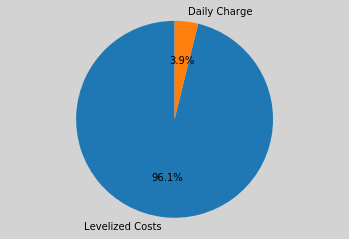

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[161.28559754475455, 111.81763224630161, 117.34636865912495, 12.956438505821268, 28.576728360406342, 22.53778588468158, 0.4234210027326614, 0.6188902397903233, 0.22050213749914327, 3454.8, 334.4423, 78.2543, 256.188, 0.0, {'Levelized Costs': 3321.742, 'Energy Charge': 0.01599999999996271, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60153923008, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (215.96646000425733, 190.6701883130066, 220.6349618256244, 22.20900188157711, 52.8107803609259, 42.74668774929589, 0.5376595451576109, 0.5932619123591568, 0.8584562848765299)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 216
                                           a tilt of 22.2
                                           and a gcr of 0.538


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2930164337158203 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 191
                                           a tilt of 52.8
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.113079786300659 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 42.7
                                           and a gcr of 0.858


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.135211944580078 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [309.379, 0.0, 0.0]


ERROR:ga_logger:Cost: 3205.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,206 per year


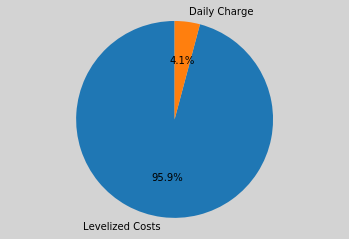

Total roof area of the  building: 599 m2
Total roof area used 575 m2
Percentage: 96.1%
succes
[[215.96646000425733, 190.6701883130066, 220.6349618256244, 22.20900188157711, 52.8107803609259, 42.74668774929589, 0.5376595451576109, 0.5932619123591568, 0.8584562848765299, 3205.87, 309.379, 309.379, 0.0, 0.0, {'Levelized Costs': 3072.828, 'Energy Charge': 1.7053025658242404e-13, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601090136726, 61845.7, 575.417]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.93729493305057, 121.20870385880707, 191.75467759004076, 6.105957278995365, 5.0596186350238455, 1.005009405789052, 0.26035918253880963, 0.37856248627272626, 0.5391129141507777)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 6.1
                                           and a gcr of 0.260


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.318112850189209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 5.1
                                           and a gcr of 0.379


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.158108711242676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 192
                                           a tilt of 1.0
                                           and a gcr of 0.539


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.288118600845337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 110s


ERROR:ga_logger:panel relevance: [0.0, 226.669, 0.0]


ERROR:ga_logger:Cost: 4773.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0386 /kWh
Total Cost of the system: $ 4,774 per year


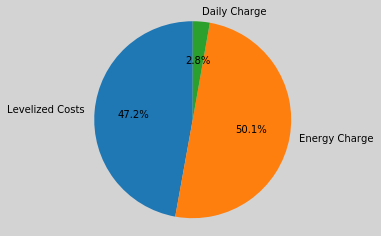

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[199.93729493305057, 121.20870385880707, 191.75467759004076, 6.105957278995365, 5.0596186350238455, 1.005009405789052, 0.26035918253880963, 0.37856248627272626, 0.5391129141507777, 4773.99, 226.669, 0.0, 226.669, 0.0, {'Levelized Costs': 2251.3158, 'Energy Charge': 2389.6322, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 42774.421581190145, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (170.79612122046805, 248.73109983172068, 182.0174451665628, 12.752653019812676, 52.22762830534227, 53.30130400310478, 0.23431523985388336, 0.702168598768921, 0.7177498362375266)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 171
                                           a tilt of 12.8
                                           and a gcr of 0.234


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.08510684967041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 249
                                           a tilt of 52.2
                                           and a gcr of 0.702


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.950826644897461 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 182
                                           a tilt of 53.3
                                           and a gcr of 0.718


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9333336353302 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 136 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [52.0689, 0.0, 270.265]


ERROR:ga_logger:Cost: 3334.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,335 per year


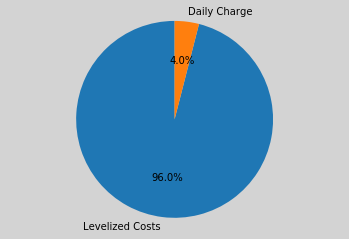

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[170.79612122046805, 248.73109983172068, 182.0174451665628, 12.752653019812676, 52.22762830534227, 53.30130400310478, 0.23431523985388336, 0.702168598768921, 0.7177498362375266, 3334.54, 322.33389999999997, 52.0689, 0.0, 270.265, {'Levelized Costs': 3201.487, 'Energy Charge': 0.011000000000137788, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59924841512, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (125.51377893017079, 116.43465156664624, 193.8485191197843, 4.187417229220786, 4.041945895945037, 42.34098266655291, 0.21014413552989789, 0.5383754080447948, 0.6418160802930467)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 4.2
                                           and a gcr of 0.210


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0345263481140137 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 116
                                           a tilt of 4.0
                                           and a gcr of 0.538


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8876755237579346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 194
                                           a tilt of 42.3
                                           and a gcr of 0.642


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.939039468765259 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 81s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.132]


ERROR:ga_logger:Cost: 3223.28


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,223 per year


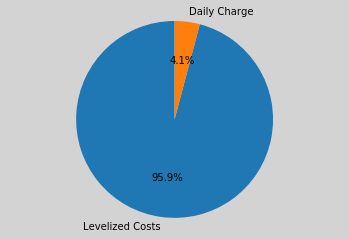

Total roof area of the  building: 599 m2
Total roof area used 485 m2
Percentage: 81.0%
succes
[[125.51377893017079, 116.43465156664624, 193.8485191197843, 4.187417229220786, 4.041945895945037, 42.34098266655291, 0.21014413552989789, 0.5383754080447948, 0.6418160802930467, 3223.28, 311.132, 0.0, 0.0, 311.132, {'Levelized Costs': 3090.226, 'Energy Charge': 0.012000000000227828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60184829426, 61845.7, 484.769]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (239.825037717682, 263.71099759428733, 193.3379690311491, 21.556694662511134, 40.325479187593594, 48.018531761729164, 0.7694751927856528, 0.7804431203972003, 0.7549157601401175)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 240
                                           a tilt of 21.6
                                           and a gcr of 0.769


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.076045513153076 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 40.3
                                           and a gcr of 0.780


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9581737518310547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 193
                                           a tilt of 48.0
                                           and a gcr of 0.755


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9656848907470703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 93s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 327.226]


ERROR:ga_logger:Cost: 3383.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,383 per year


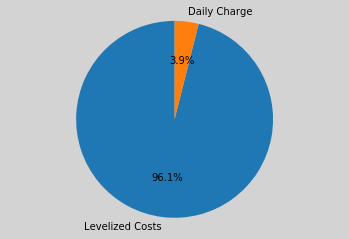

Total roof area of the  building: 599 m2
Total roof area used 433 m2
Percentage: 72.4%
succes
[[239.825037717682, 263.71099759428733, 193.3379690311491, 21.556694662511134, 40.325479187593594, 48.018531761729164, 0.7694751927856528, 0.7804431203972003, 0.7549157601401175, 3383.13, 327.226, 0.0, 0.0, 327.226, {'Levelized Costs': 3250.075, 'Energy Charge': 0.013000000000317868, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59968227355, 61845.7, 433.46]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.28719903922807, 250.169144554983, 183.5338347166524, 12.106984457985126, 7.526897280587862, 41.053524290948296, 0.20340092967260404, 0.4023316021385172, 0.6833137402304696)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 12.1
                                           and a gcr of 0.203


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.229506015777588 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 250
                                           a tilt of 7.5
                                           and a gcr of 0.402


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3426826000213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 184
                                           a tilt of 41.1
                                           and a gcr of 0.683


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1081902980804443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 308.06]


ERROR:ga_logger:Cost: 3192.77


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,193 per year


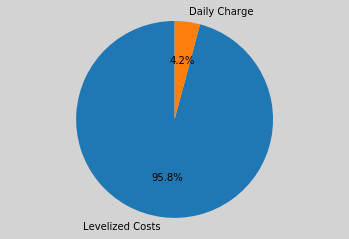

Total roof area of the  building: 599 m2
Total roof area used 451 m2
Percentage: 75.3%
succes
[[126.28719903922807, 250.169144554983, 183.5338347166524, 12.106984457985126, 7.526897280587862, 41.053524290948296, 0.20340092967260404, 0.4023316021385172, 0.6833137402304696, 3192.77, 308.06, 0.0, 0.0, 308.06, {'Levelized Costs': 3059.718, 'Energy Charge': 0.010000000000331966, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59863659094, 61845.7, 450.833]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (199.135956219281, 209.16791903528855, 175.7605647697015, 42.52001966439994, 31.86882456119767, 26.22127018807902, 0.829283333486897, 0.645674357577953, 0.31270772820666576)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 199
                                           a tilt of 42.5
                                           and a gcr of 0.829


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.977525234222412 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 209
                                           a tilt of 31.9
                                           and a gcr of 0.646


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.910264730453491 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 176
                                           a tilt of 26.2
                                           and a gcr of 0.313


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.974184274673462 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 233.457, 74.1714]


ERROR:ga_logger:Cost: 3188.48


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 45,323 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,188 per year


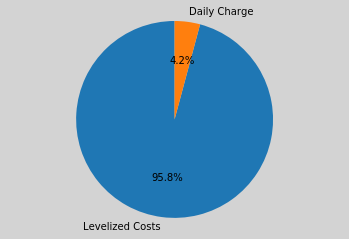

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[199.135956219281, 209.16791903528855, 175.7605647697015, 42.52001966439994, 31.86882456119767, 26.22127018807902, 0.829283333486897, 0.645674357577953, 0.31270772820666576, 3188.48, 307.6284, 0.0, 233.457, 74.1714, {'Levelized Costs': 3055.4230000000002, 'Energy Charge': 0.014999999999929514, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60158130569, 45322.8, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (169.72108016601283, 205.11824610899694, 162.43151097569324, 4.346902931497187, 31.771021105766597, 13.72749476234792, 0.27882800606105207, 0.4410393968742188, 0.2838637530962)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 170
                                           a tilt of 4.3
                                           and a gcr of 0.279


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2855172157287598 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 205
                                           a tilt of 31.8
                                           and a gcr of 0.441


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.220320224761963 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 162
                                           a tilt of 13.7
                                           and a gcr of 0.284


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1383743286132812 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 264.077, 0.0]


ERROR:ga_logger:Cost: 3693.15


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0152 /kWh
Total Cost of the system: $ 3,693 per year


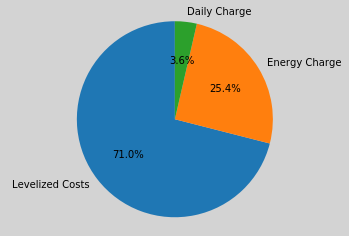

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[169.72108016601283, 205.11824610899694, 162.43151097569324, 4.346902931497187, 31.771021105766597, 13.72749476234792, 0.27882800606105207, 0.4410393968742188, 0.2838637530962, 3693.15, 264.077, 0.0, 264.077, 0.0, {'Levelized Costs': 2622.872, 'Energy Charge': 937.2360000000003, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 54365.75513232733, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


Found the solver set


ERROR:ga_logger:panel values: (228.78062122369846, 251.43109276208415, 235.27042363094236, 38.19716779851743, 34.50217006210087, 10.61312284325429, 0.35929137350028484, 0.6470425872212142, 0.6038649460158484)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 229
                                           a tilt of 38.2
                                           and a gcr of 0.359


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3037109375 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 251
                                           a tilt of 34.5
                                           and a gcr of 0.647


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.151723861694336 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 235
                                           a tilt of 10.6
                                           and a gcr of 0.604


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.5039405822753906 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [55.1877, 0.0, 268.817]


ERROR:ga_logger:Cost: 3351.13


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 44,010 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,351 per year


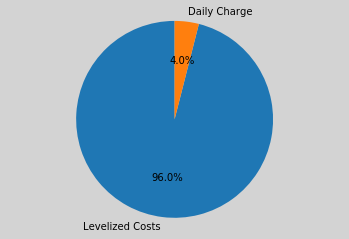

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[228.78062122369846, 251.43109276208415, 235.27042363094236, 38.19716779851743, 34.50217006210087, 10.61312284325429, 0.35929137350028484, 0.6470425872212142, 0.6038649460158484, 3351.13, 324.0047, 55.1877, 0.0, 268.817, {'Levelized Costs': 3218.0746999999997, 'Energy Charge': 0.013300000000299406, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60293737636, 44010.4, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.15319324295746, 164.51539569575306, 212.5798052227257, 24.493839914745546, 5.287219217799359, 3.816113028755382, 0.34898926255025875, 0.4812163129855874, 0.40925564780661317)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 24.5
                                           and a gcr of 0.349


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.963083267211914 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 165
                                           a tilt of 5.3
                                           and a gcr of 0.481


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8142647743225098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 213
                                           a tilt of 3.8
                                           and a gcr of 0.409


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.061232805252075 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 288.134, 0.0]


ERROR:ga_logger:Cost: 3810.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0132 /kWh
Total Cost of the system: $ 3,810 per year


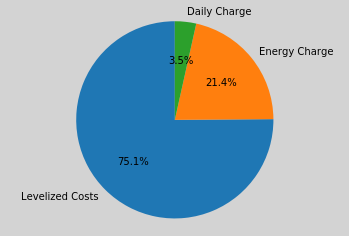

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.15319324295746, 164.51539569575306, 212.5798052227257, 24.493839914745546, 5.287219217799359, 3.816113028755382, 0.34898926255025875, 0.4812163129855874, 0.40925564780661317, 3810.04, 288.134, 0.0, 288.134, 0.0, {'Levelized Costs': 2861.805, 'Energy Charge': 815.1930000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55339.76450591919, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (181.34338875777763, 264.8786084240412, 190.8882931171896, 41.57598744744889, 45.29247720288138, 43.608223007544524, 0.7371710080078823, 0.7691912107299489, 0.6614093552546136)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 181
                                           a tilt of 41.6
                                           and a gcr of 0.737


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2584080696105957 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 265
                                           a tilt of 45.3
                                           and a gcr of 0.769


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1409218311309814 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 191
                                           a tilt of 43.6
                                           and a gcr of 0.661


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1867334842681885 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [311.527, 0.0, 0.0]


ERROR:ga_logger:Cost: 3227.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,227 per year


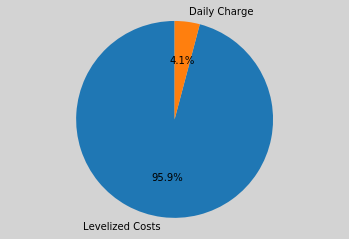

Total roof area of the  building: 599 m2
Total roof area used 423 m2
Percentage: 70.6%
succes
[[181.34338875777763, 264.8786084240412, 190.8882931171896, 41.57598744744889, 45.29247720288138, 43.608223007544524, 0.7371710080078823, 0.7691912107299489, 0.6614093552546136, 3227.21, 311.527, 311.527, 0.0, 0.0, {'Levelized Costs': 3094.156, 'Energy Charge': 0.012000000000227828, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.600544772504, 61845.7, 422.598]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (141.12747265833792, 157.29014648763498, 135.2843299321857, 27.58732778450534, 34.701574870343705, 19.49253675747054, 0.46720410733914797, 0.44822960027925207, 0.3711567215624376)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 141
                                           a tilt of 27.6
                                           and a gcr of 0.467


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9536945819854736 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 157
                                           a tilt of 34.7
                                           and a gcr of 0.448


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8080954551696777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 19.5
                                           and a gcr of 0.371


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8249125480651855 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 78s


ERROR:ga_logger:panel relevance: [279.744, 0.0, 0.0]


ERROR:ga_logger:Cost: 3583.64


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0109 /kWh
Total Cost of the system: $ 3,584 per year


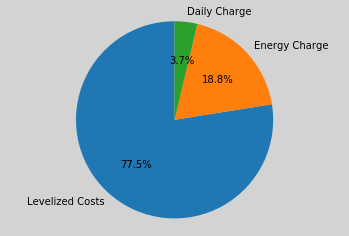

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[141.12747265833792, 157.29014648763498, 135.2843299321857, 27.58732778450534, 34.701574870343705, 19.49253675747054, 0.46720410733914797, 0.44822960027925207, 0.3711567215624376, 3583.64, 279.744, 279.744, 0.0, 0.0, {'Levelized Costs': 2778.471, 'Energy Charge': 672.1270000000002, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 56481.587395280054, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (223.8501606056157, 171.14766782911641, 220.01857092080473, 32.406382271870605, 51.569116990276534, 42.74668774929589, 0.5376595451576109, 0.5533175794611549, 0.804251982478991)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 32.4
                                           and a gcr of 0.538


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3116064071655273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 51.6
                                           and a gcr of 0.553


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.174828052520752 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 220
                                           a tilt of 42.7
                                           and a gcr of 0.804


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.169585704803467 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 316.326, 0.0]


ERROR:ga_logger:Cost: 3274.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,275 per year


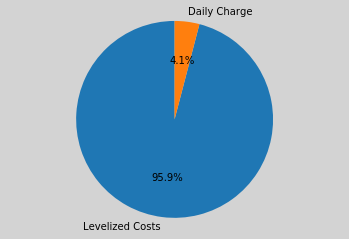

Total roof area of the  building: 599 m2
Total roof area used 572 m2
Percentage: 95.5%
succes
[[223.8501606056157, 171.14766782911641, 220.01857092080473, 32.406382271870605, 51.569116990276534, 42.74668774929589, 0.5376595451576109, 0.5533175794611549, 0.804251982478991, 3274.87, 316.326, 0.0, 316.326, 0.0, {'Levelized Costs': 3141.815, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59873299992, 61845.7, 571.691]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (136.76765814745357, 96.88360613502742, 158.3548355928831, 4.805711501656001, 2.8177500082549143, 6.5673481515174945, 0.5414636590496302, 0.4046917318495096, 0.32210161472081134)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 137
                                           a tilt of 4.8
                                           and a gcr of 0.541


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.245107412338257 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 97
                                           a tilt of 2.8
                                           and a gcr of 0.405


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0933339595794678 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 158
                                           a tilt of 6.6
                                           and a gcr of 0.322


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1465871334075928 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 131 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [324.208, 0.0, 0.0]


ERROR:ga_logger:Cost: 3389.81


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 43,342 kWh
At a cost of $ 0.0008 /kWh
Total Cost of the system: $ 3,390 per year


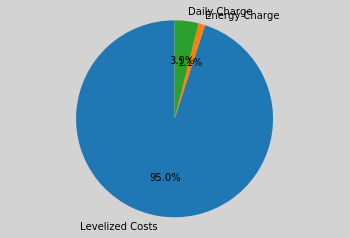

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[136.76765814745357, 96.88360613502742, 158.3548355928831, 4.805711501656001, 2.8177500082549143, 6.5673481515174945, 0.5414636590496302, 0.4046917318495096, 0.32210161472081134, 3389.81, 324.208, 324.208, 0.0, 0.0, {'Levelized Costs': 3220.0962, 'Energy Charge': 36.67179999999996, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61553.0179211297, 43342.0, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (193.90564734486247, 131.80366970657798, 173.41123827288015, 17.6580859422891, 53.18380510467769, 21.425364700948826, 0.8129412909903826, 0.8131712076707736, 0.8956449566390213)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 194
                                           a tilt of 17.7
                                           and a gcr of 0.813


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9684441089630127 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 53.2
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.79996657371521 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 173
                                           a tilt of 21.4
                                           and a gcr of 0.896


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7984132766723633 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [313.682, 0.0, 0.0]


ERROR:ga_logger:Cost: 3248.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,249 per year


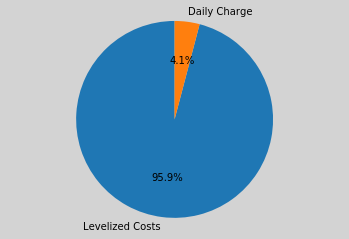

Total roof area of the  building: 599 m2
Total roof area used 386 m2
Percentage: 64.4%
succes
[[193.90564734486247, 131.80366970657798, 173.41123827288015, 17.6580859422891, 53.18380510467769, 21.425364700948826, 0.8129412909903826, 0.8131712076707736, 0.8956449566390213, 3248.61, 313.682, 313.682, 0.0, 0.0, {'Levelized Costs': 3115.5589999999997, 'Energy Charge': 0.009000000000298769, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59892484313, 61845.7, 385.861]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (162.7482245457137, 120.85667166129387, 159.61605980262922, 17.49569046991295, 52.38247222646767, 21.220120502707946, 0.8075798308914238, 0.8131712076707736, 0.885020562666759)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 163
                                           a tilt of 17.5
                                           and a gcr of 0.808


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.24413800239563 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 121
                                           a tilt of 52.4
                                           and a gcr of 0.813


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1308348178863525 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 21.2
                                           and a gcr of 0.885


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.133841037750244 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [314.571, 0.0, 0.0]


ERROR:ga_logger:Cost: 3257.44


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,257 per year


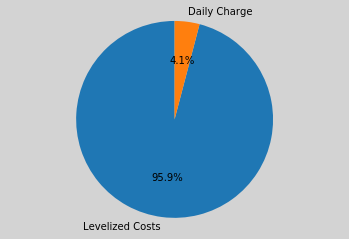

Total roof area of the  building: 599 m2
Total roof area used 390 m2
Percentage: 65.1%
succes
[[162.7482245457137, 120.85667166129387, 159.61605980262922, 17.49569046991295, 52.38247222646767, 21.220120502707946, 0.8075798308914238, 0.8131712076707736, 0.885020562666759, 3257.44, 314.571, 314.571, 0.0, 0.0, {'Levelized Costs': 3124.382, 'Energy Charge': 0.016000000000246928, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60315790541, 61845.7, 389.523]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (154.84100590813503, 196.31571942794415, 141.28046416389824, 47.59876136035437, 45.29247720288138, 18.598661790279337, 0.4774979308774965, 0.5899715817293425, 0.42655911665299395)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 155
                                           a tilt of 47.6
                                           and a gcr of 0.477


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9534945487976074 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 196
                                           a tilt of 45.3
                                           and a gcr of 0.590


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.848217487335205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 141
                                           a tilt of 18.6
                                           and a gcr of 0.427


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8206863403320312 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 199.509, 111.159]


ERROR:ga_logger:Cost: 3218.67


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,219 per year


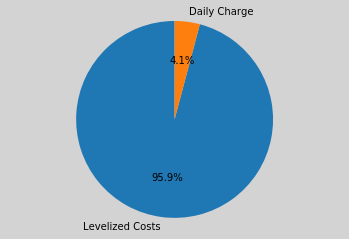

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[154.84100590813503, 196.31571942794415, 141.28046416389824, 47.59876136035437, 45.29247720288138, 18.598661790279337, 0.4774979308774965, 0.5899715817293425, 0.42655911665299395, 3218.67, 310.668, 0.0, 199.509, 111.159, {'Levelized Costs': 3085.616, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60052301343, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (144.76560257064548, 170.80215477854435, 137.1303558799452, 27.53182961870857, 12.004265013719618, 14.266230820956286, 0.4836668877435405, 0.4484893134033708, 0.39785902969406606)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 145
                                           a tilt of 27.5
                                           and a gcr of 0.484


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.261411428451538 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 12.0
                                           and a gcr of 0.448


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.151770830154419 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 137
                                           a tilt of 14.3
                                           and a gcr of 0.398


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2549920082092285 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 72s


ERROR:ga_logger:panel relevance: [289.601, 0.0, 0.0]


ERROR:ga_logger:Cost: 3396.17


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0063 /kWh
Total Cost of the system: $ 3,396 per year


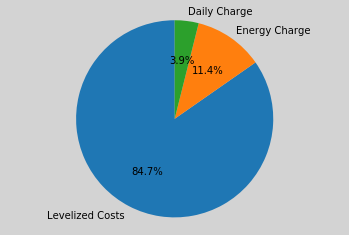

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[144.76560257064548, 170.80215477854435, 137.1303558799452, 27.53182961870857, 12.004265013719618, 14.266230820956286, 0.4836668877435405, 0.4484893134033708, 0.39785902969406606, 3396.17, 289.601, 289.601, 0.0, 0.0, {'Levelized Costs': 2876.3740000000003, 'Energy Charge': 386.75400000000013, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58759.11674809006, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (149.34271183099622, 210.0095189582953, 241.14045419975164, 17.884176114253574, 35.29105427756594, 51.057232271742805, 0.682482130432735, 0.33516764254745357, 0.654160246456185)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 149
                                           a tilt of 17.9
                                           and a gcr of 0.682


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.306467294692993 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 210
                                           a tilt of 35.3
                                           and a gcr of 0.335


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.103053092956543 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 51.1
                                           and a gcr of 0.654


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1394479274749756 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [211.447, 96.8439, 0.0]


ERROR:ga_logger:Cost: 3195.06


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,195 per year


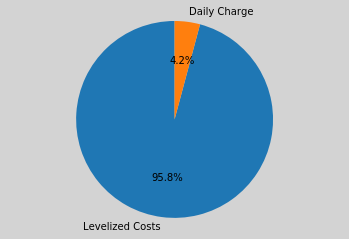

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[149.34271183099622, 210.0095189582953, 241.14045419975164, 17.884176114253574, 35.29105427756594, 51.057232271742805, 0.682482130432735, 0.33516764254745357, 0.654160246456185, 3195.06, 308.2909, 211.447, 96.8439, 0.0, {'Levelized Costs': 3062.0049999999997, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60278584978, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (93.21144309769647, 177.16023302331791, 210.56185927024666, 22.11757742072878, 28.991768144404872, 6.312084816455634, 0.35929137350028484, 0.49272584607825964, 0.4575603249453613)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 93
                                           a tilt of 22.1
                                           and a gcr of 0.359


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.983556032180786 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 177
                                           a tilt of 29.0
                                           and a gcr of 0.493


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.873563766479492 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 6.3
                                           and a gcr of 0.458


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.366272211074829 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 77s


ERROR:ga_logger:panel relevance: [0.0, 295.025, 0.0]


ERROR:ga_logger:Cost: 3068.99


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0001 /kWh
Total Cost of the system: $ 3,069 per year


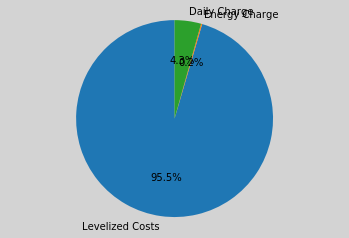

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[93.21144309769647, 177.16023302331791, 210.56185927024666, 22.11757742072878, 28.991768144404872, 6.312084816455634, 0.35929137350028484, 0.49272584607825964, 0.4575603249453613, 3068.99, 295.025, 0.0, 295.025, 0.0, {'Levelized Costs': 2930.2439999999997, 'Energy Charge': 5.704000000000292, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61800.21102777493, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (245.64841946273864, 148.35741898670102, 206.71733102817714, 25.176985120709055, 19.57954569827782, 52.19049554934819, 0.7375133841632217, 0.8209978164224432, 0.7917551639434892)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 246
                                           a tilt of 25.2
                                           and a gcr of 0.738


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2790310382843018 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 148
                                           a tilt of 19.6
                                           and a gcr of 0.821


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.11533260345459 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 207
                                           a tilt of 52.2
                                           and a gcr of 0.792


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1452717781066895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 321.394, 0.0]


ERROR:ga_logger:Cost: 3325.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,325 per year


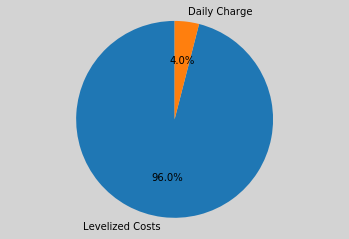

Total roof area of the  building: 599 m2
Total roof area used 391 m2
Percentage: 65.4%
succes
[[245.64841946273864, 148.35741898670102, 206.71733102817714, 25.176985120709055, 19.57954569827782, 52.19049554934819, 0.7375133841632217, 0.8209978164224432, 0.7917551639434892, 3325.21, 321.394, 0.0, 321.394, 0.0, {'Levelized Costs': 3192.156, 'Energy Charge': 0.012000000000057298, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59969872003, 61845.7, 391.468]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (232.893077684967, 133.65852852075463, 135.16707960058022, 53.43651684883825, 10.081092641443362, 39.7523745323847, 0.5212933998890046, 0.5781481541752662, 0.2324672621681222)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 233
                                           a tilt of 53.4
                                           and a gcr of 0.521


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3567450046539307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 134
                                           a tilt of 10.1
                                           and a gcr of 0.578


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1086065769195557 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 39.8
                                           and a gcr of 0.232


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.168245553970337 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 90s


ERROR:ga_logger:panel relevance: [0.0, 299.791, 18.6497]


ERROR:ga_logger:Cost: 3295.87


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,296 per year


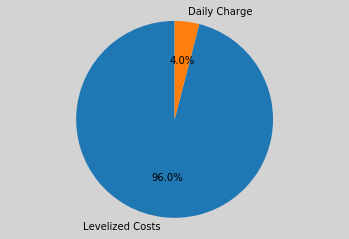

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[232.893077684967, 133.65852852075463, 135.16707960058022, 53.43651684883825, 10.081092641443362, 39.7523745323847, 0.5212933998890046, 0.5781481541752662, 0.2324672621681222, 3295.87, 318.4407, 0.0, 299.791, 18.6497, {'Levelized Costs': 3162.8089999999997, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59850181188, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (203.80298151510095, 171.06304485316565, 199.20349259589332, 53.108375543122236, 46.50742359087218, 41.70665751409199, 0.4131946452432398, 0.6263620588820407, 0.49907463261440654)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 204
                                           a tilt of 53.1
                                           and a gcr of 0.413


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.327390193939209 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 46.5
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2469799518585205 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 199
                                           a tilt of 41.7
                                           and a gcr of 0.499


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.492927312850952 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 89s


ERROR:ga_logger:panel relevance: [0.0, 35.3198, 270.685]


ERROR:ga_logger:Cost: 3172.35


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,172 per year


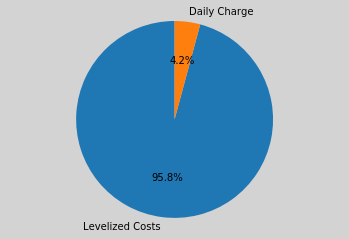

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[203.80298151510095, 171.06304485316565, 199.20349259589332, 53.108375543122236, 46.50742359087218, 41.70665751409199, 0.4131946452432398, 0.6263620588820407, 0.49907463261440654, 3172.35, 306.0048, 0.0, 35.3198, 270.685, {'Levelized Costs': 3039.296, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60201756832, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (142.50950758188904, 115.21841484259298, 135.18252931741372, 11.956930997101583, 33.87388275029836, 30.599956892734312, 0.23362576932520016, 0.5405569956789453, 0.7156410150623422)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 143
                                           a tilt of 12.0
                                           and a gcr of 0.234


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3942134380340576 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 115
                                           a tilt of 33.9
                                           and a gcr of 0.541


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.267394781112671 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 135
                                           a tilt of 30.6
                                           and a gcr of 0.716


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.232720375061035 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [49.4716, 0.0, 276.957]


ERROR:ga_logger:Cost: 3375.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,375 per year


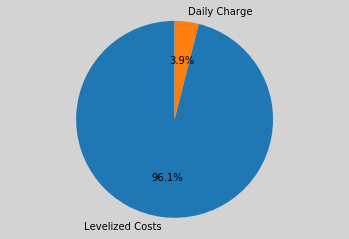

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[142.50950758188904, 115.21841484259298, 135.18252931741372, 11.956930997101583, 33.87388275029836, 30.599956892734312, 0.23362576932520016, 0.5405569956789453, 0.7156410150623422, 3375.21, 326.4286, 49.4716, 0.0, 276.957, {'Levelized Costs': 3242.151, 'Energy Charge': 0.017000000000166438, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601013592954, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (180.30498651814398, 256.3518477728085, 197.07453267552918, 49.02689088116409, 34.60968377325574, 43.84833917414435, 0.6061415142725631, 0.7566211679910039, 0.6850188598063613)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 49.0
                                           and a gcr of 0.606


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1883182525634766 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 34.6
                                           and a gcr of 0.757


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.09785795211792 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 197
                                           a tilt of 43.8
                                           and a gcr of 0.685


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.120365858078003 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [310.975, 0.0, 0.0]


ERROR:ga_logger:Cost: 3221.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,222 per year


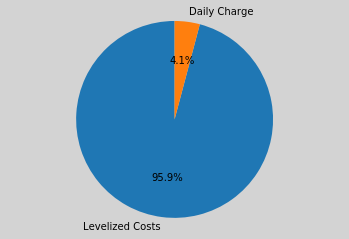

Total roof area of the  building: 599 m2
Total roof area used 513 m2
Percentage: 85.7%
succes
[[180.30498651814398, 256.3518477728085, 197.07453267552918, 49.02689088116409, 34.60968377325574, 43.84833917414435, 0.6061415142725631, 0.7566211679910039, 0.6850188598063613, 3221.72, 310.975, 310.975, 0.0, 0.0, {'Levelized Costs': 3088.6659999999997, 'Energy Charge': 0.012000000000284672, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60284142755, 61845.7, 513.04]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (172.05825022768119, 170.68787202749894, 146.1565445329254, 37.13878553674049, 13.56210133242087, 15.86775207309323, 0.5167034909252322, 0.22098787454895538, 0.5257600658722673)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 172
                                           a tilt of 37.1
                                           and a gcr of 0.517


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2268264293670654 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 171
                                           a tilt of 13.6
                                           and a gcr of 0.221


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0746757984161377 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 146
                                           a tilt of 15.9
                                           and a gcr of 0.526


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0624752044677734 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [298.674, 0.0, 0.0]


ERROR:ga_logger:Cost: 3099.55


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,100 per year


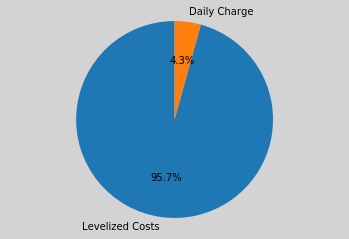

Total roof area of the  building: 599 m2
Total roof area used 578 m2
Percentage: 96.5%
succes
[[172.05825022768119, 170.68787202749894, 146.1565445329254, 37.13878553674049, 13.56210133242087, 15.86775207309323, 0.5167034909252322, 0.22098787454895538, 0.5257600658722673, 3099.55, 298.674, 298.674, 0.0, 0.0, {'Levelized Costs': 2966.4950000000003, 'Energy Charge': 0.012999999999976808, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60055852017, 61845.7, 578.038]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (197.724173964166, 218.86982052031036, 168.73840660251776, 11.720993373775197, 30.9752221015989, 41.87870312410985, 0.6719465617585726, 0.5623252226423625, 0.6793521473305673)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 198
                                           a tilt of 11.7
                                           and a gcr of 0.672


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.377685308456421 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 219
                                           a tilt of 31.0
                                           and a gcr of 0.562


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.206587791442871 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 169
                                           a tilt of 41.9
                                           and a gcr of 0.679


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.182924747467041 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 130 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 91s


ERROR:ga_logger:panel relevance: [312.635, 0.0, 0.0]


ERROR:ga_logger:Cost: 3238.21


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,238 per year


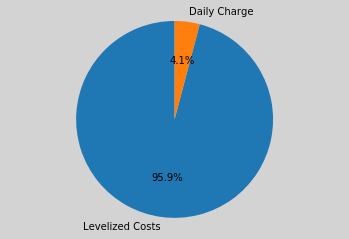

Total roof area of the  building: 599 m2
Total roof area used 465 m2
Percentage: 77.7%
succes
[[197.724173964166, 218.86982052031036, 168.73840660251776, 11.720993373775197, 30.9752221015989, 41.87870312410985, 0.6719465617585726, 0.5623252226423625, 0.6793521473305673, 3238.21, 312.635, 312.635, 0.0, 0.0, {'Levelized Costs': 3105.1490000000003, 'Energy Charge': 0.018999999999778083, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60312830336, 61845.7, 465.268]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (105.3222335332871, 189.0940126867925, 175.48968128470213, 52.33563508017258, 6.958526242074532, 23.00069139132102, 0.27882800606105207, 0.20635220632852716, 0.35384159667864673)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 105
                                           a tilt of 52.3
                                           and a gcr of 0.279


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3765602111816406 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 189
                                           a tilt of 7.0
                                           and a gcr of 0.206


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 4.379384279251099 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 175
                                           a tilt of 23.0
                                           and a gcr of 0.354


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1952598094940186 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 128 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 211.867]


ERROR:ga_logger:Cost: 4421.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0353 /kWh
Total Cost of the system: $ 4,422 per year


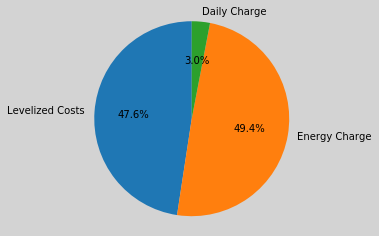

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[105.3222335332871, 189.0940126867925, 175.48968128470213, 52.33563508017258, 6.958526242074532, 23.00069139132102, 0.27882800606105207, 0.20635220632852716, 0.35384159667864673, 4421.66, 211.867, 0.0, 0.0, 211.867, {'Levelized Costs': 2104.3089999999997, 'Energy Charge': 2184.309, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 44413.06972377996, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (179.59956695721823, 256.09751068795765, 179.10498888781365, 34.44136255196454, 37.26122179238497, 9.09723232592758, 0.8874471468234523, 0.6263898409544926, 0.27098873838493825)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 180
                                           a tilt of 34.4
                                           and a gcr of 0.887


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3164098262786865 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 256
                                           a tilt of 37.3
                                           and a gcr of 0.626


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1889538764953613 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 179
                                           a tilt of 9.1
                                           and a gcr of 0.271


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0866215229034424 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 130s


ERROR:ga_logger:panel relevance: [225.405, 0.0, 93.4285]


ERROR:ga_logger:Cost: 3299.78


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,300 per year


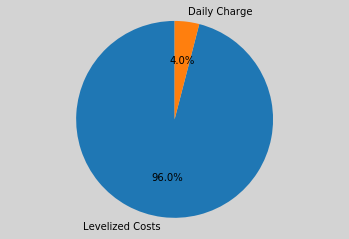

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[179.59956695721823, 256.09751068795765, 179.10498888781365, 34.44136255196454, 37.26122179238497, 9.09723232592758, 0.8874471468234523, 0.6263898409544926, 0.27098873838493825, 3299.78, 318.8335, 225.405, 0.0, 93.4285, {'Levelized Costs': 3166.725, 'Energy Charge': 0.013000000000147338, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60177961397, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (212.05526867282177, 212.58174861104513, 111.37290640402286, 10.674863964436998, 32.30172403223011, 48.916196976728486, 0.5994172857656217, 0.5934733740206628, 0.23450314179655776)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 212
                                           a tilt of 10.7
                                           and a gcr of 0.599


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.4572675228118896 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 213
                                           a tilt of 32.3
                                           and a gcr of 0.593


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.176182508468628 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 111
                                           a tilt of 48.9
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1641616821289062 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 312.165, 0.0]


ERROR:ga_logger:Cost: 3233.54


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,234 per year


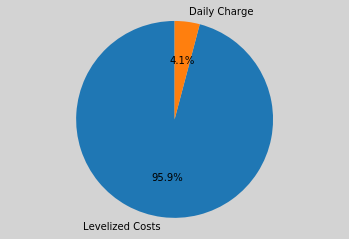

Total roof area of the  building: 599 m2
Total roof area used 526 m2
Percentage: 87.8%
succes
[[212.05526867282177, 212.58174861104513, 111.37290640402286, 10.674863964436998, 32.30172403223011, 48.916196976728486, 0.5994172857656217, 0.5934733740206628, 0.23450314179655776, 3233.54, 312.165, 0.0, 312.165, 0.0, {'Levelized Costs': 3100.479, 'Energy Charge': 0.01900000000023283, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.601573640946, 61845.7, 525.996]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (193.34211638434473, 264.17721393937643, 220.87260578694776, 28.52352815067463, 40.771454237845276, 54.85410162608318, 0.5536555363501112, 0.48654176199346855, 0.44122939514001713)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 193
                                           a tilt of 28.5
                                           and a gcr of 0.554


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.254713535308838 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 264
                                           a tilt of 40.8
                                           and a gcr of 0.487


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1193714141845703 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 221
                                           a tilt of 54.9
                                           and a gcr of 0.441


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.135352849960327 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 92s


ERROR:ga_logger:panel relevance: [298.761, 0.0, 0.0]


ERROR:ga_logger:Cost: 3100.41


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,100 per year


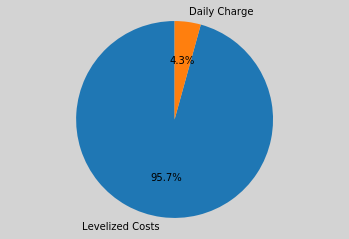

Total roof area of the  building: 599 m2
Total roof area used 540 m2
Percentage: 90.1%
succes
[[193.34211638434473, 264.17721393937643, 220.87260578694776, 28.52352815067463, 40.771454237845276, 54.85410162608318, 0.5536555363501112, 0.48654176199346855, 0.44122939514001713, 3100.41, 298.761, 298.761, 0.0, 0.0, {'Levelized Costs': 2967.3509999999997, 'Energy Charge': 0.01700000000022328, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60075129276, 61845.7, 539.616]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.57625765115847, 176.32410384834526, 104.77110283171066, 21.460533559686166, 39.81176380586782, 1.8660949086232819, 0.3804630583963713, 0.5768737093550831, 0.23450314179655776)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 95
                                           a tilt of 21.5
                                           and a gcr of 0.380


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2939682006835938 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 176
                                           a tilt of 39.8
                                           and a gcr of 0.577


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1392059326171875 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 105
                                           a tilt of 1.9
                                           and a gcr of 0.235


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0645554065704346 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [0.0, 302.598, 0.0]


ERROR:ga_logger:Cost: 3138.52


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,139 per year


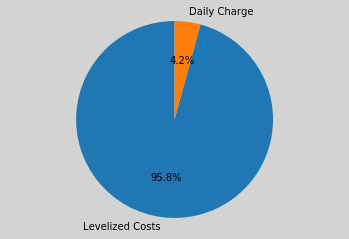

Total roof area of the  building: 599 m2
Total roof area used 525 m2
Percentage: 87.6%
succes
[[94.57625765115847, 176.32410384834526, 104.77110283171066, 21.460533559686166, 39.81176380586782, 1.8660949086232819, 0.3804630583963713, 0.5768737093550831, 0.23450314179655776, 3138.52, 302.598, 0.0, 302.598, 0.0, {'Levelized Costs': 3005.4649999999997, 'Energy Charge': 0.013000000000374712, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60121967009, 61845.7, 524.548]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (236.7022275535502, 220.88446036393543, 210.84408343995912, 55.77440528489682, 31.594211553166495, 25.376018481093666, 0.355673487544631, 0.6428492773014655, 0.6998441089210818)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 237
                                           a tilt of 55.8
                                           and a gcr of 0.356


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.3113913536071777 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 221
                                           a tilt of 31.6
                                           and a gcr of 0.643


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.151367664337158 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 211
                                           a tilt of 25.4
                                           and a gcr of 0.700


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1246073246002197 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 137 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 113s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 314.27]


ERROR:ga_logger:Cost: 3254.45


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,254 per year


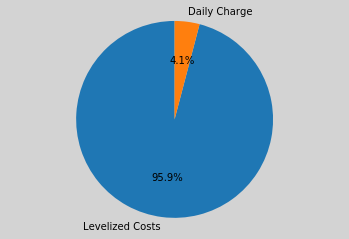

Total roof area of the  building: 599 m2
Total roof area used 449 m2
Percentage: 75.0%
succes
[[236.7022275535502, 220.88446036393543, 210.84408343995912, 55.77440528489682, 31.594211553166495, 25.376018481093666, 0.355673487544631, 0.6428492773014655, 0.6998441089210818, 3254.45, 314.27, 0.0, 0.0, 314.27, {'Levelized Costs': 3121.394, 'Energy Charge': 0.014000000000351065, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60111300542, 61845.7, 449.058]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (195.4728508884786, 192.06344126712142, 109.21604140879228, 39.57782166316641, 5.287219217799359, 14.849041239407322, 0.22658969607870802, 0.6279824193657976, 0.35800313138381884)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 195
                                           a tilt of 39.6
                                           and a gcr of 0.227


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.014132261276245 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 192
                                           a tilt of 5.3
                                           and a gcr of 0.628


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0585274696350098 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 109
                                           a tilt of 14.8
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.852501153945923 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 86s


ERROR:ga_logger:panel relevance: [31.9302, 287.519, 0.0]


ERROR:ga_logger:Cost: 3305.89


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,306 per year


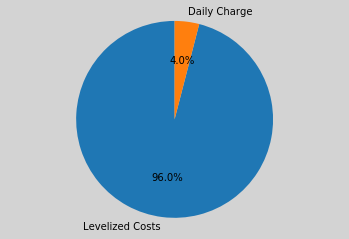

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[195.4728508884786, 192.06344126712142, 109.21604140879228, 39.57782166316641, 5.287219217799359, 14.849041239407322, 0.22658969607870802, 0.6279824193657976, 0.35800313138381884, 3305.89, 319.4492, 31.9302, 287.519, 0.0, {'Levelized Costs': 3172.8259999999996, 'Energy Charge': 0.02200000000016189, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60181015346, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (168.46960272656094, 259.9401186213181, 254.44104153236017, 46.38087577065009, 12.559485291578318, 52.06581561583886, 0.8946472793458623, 0.8078945354616549, 0.8114327119559627)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 168
                                           a tilt of 46.4
                                           and a gcr of 0.895


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.319240093231201 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 260
                                           a tilt of 12.6
                                           and a gcr of 0.808


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.848886728286743 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 254
                                           a tilt of 52.1
                                           and a gcr of 0.811


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1200828552246094 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  12 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [338.997, 0.0, 0.0]


ERROR:ga_logger:Cost: 3500.04


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,500 per year


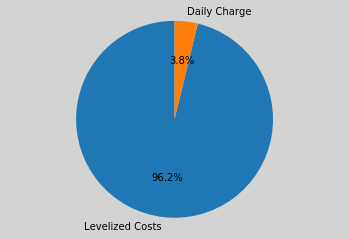

Total roof area of the  building: 599 m2
Total roof area used 379 m2
Percentage: 63.3%
succes
[[168.46960272656094, 259.9401186213181, 254.44104153236017, 46.38087577065009, 12.559485291578318, 52.06581561583886, 0.8946472793458623, 0.8078945354616549, 0.8114327119559627, 3500.04, 338.997, 338.997, 0.0, 0.0, {'Levelized Costs': 3366.9829999999997, 'Energy Charge': 0.015000000000156888, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60227560001, 61845.7, 378.917]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (94.17869757848422, 143.89318386989964, 215.69205518550334, 38.36707262427442, 12.924964161859094, 36.87956092705732, 0.4993440022693858, 0.5266143885765777, 0.39908650640055393)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 94
                                           a tilt of 38.4
                                           and a gcr of 0.499


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.962904691696167 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 144
                                           a tilt of 12.9
                                           and a gcr of 0.527


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7911534309387207 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 216
                                           a tilt of 36.9
                                           and a gcr of 0.399


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.352921485900879 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 84s


ERROR:ga_logger:panel relevance: [0.0, 303.039, 9.30425]


ERROR:ga_logger:Cost: 3235.31


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,235 per year


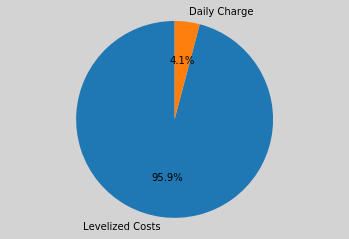

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[94.17869757848422, 143.89318386989964, 215.69205518550334, 38.36707262427442, 12.924964161859094, 36.87956092705732, 0.4993440022693858, 0.5266143885765777, 0.39908650640055393, 3235.31, 312.34325, 0.0, 303.039, 9.30425, {'Levelized Costs': 3102.2549999999997, 'Energy Charge': 0.013000000000204182, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60180129249, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (210.86417941414106, 242.27034229619034, 229.18115513120975, 54.55330765810136, 33.902940000309336, 36.14345314444846, 0.8016550940822929, 0.28751636803089026, 0.448878738708283)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 211
                                           a tilt of 54.6
                                           and a gcr of 0.802


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.308473587036133 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 242
                                           a tilt of 33.9
                                           and a gcr of 0.288


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2483551502227783 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 229
                                           a tilt of 36.1
                                           and a gcr of 0.449


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.230501890182495 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 132 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 88s


ERROR:ga_logger:panel relevance: [162.609, 0.0, 177.72]


ERROR:ga_logger:Cost: 3513.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,513 per year


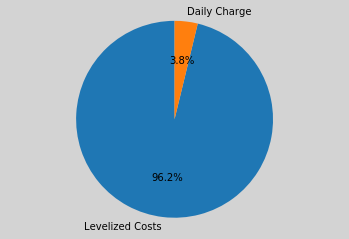

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[210.86417941414106, 242.27034229619034, 229.18115513120975, 54.55330765810136, 33.902940000309336, 36.14345314444846, 0.8016550940822929, 0.28751636803089026, 0.448878738708283, 3513.27, 340.329, 162.609, 0.0, 177.72, {'Levelized Costs': 3380.22, 'Energy Charge': 0.008000000000151886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60029901283, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (151.75497842665743, 121.98956234722878, 132.38634776146313, 11.583826534115843, 6.592294404861743, 26.717115209640824, 0.6476724780873003, 0.27377707487993963, 0.38255149865274474)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 152
                                           a tilt of 11.6
                                           and a gcr of 0.648


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.476465940475464 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 122
                                           a tilt of 6.6
                                           and a gcr of 0.274


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1612977981567383 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 132
                                           a tilt of 26.7
                                           and a gcr of 0.383


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.134127378463745 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 129 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [202.959, 0.0, 109.178]


ERROR:ga_logger:Cost: 3233.27


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,233 per year


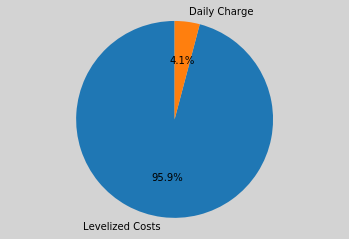

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[151.75497842665743, 121.98956234722878, 132.38634776146313, 11.583826534115843, 6.592294404861743, 26.717115209640824, 0.6476724780873003, 0.27377707487993963, 0.38255149865274474, 3233.27, 312.137, 202.959, 0.0, 109.178, {'Levelized Costs': 3100.217, 'Energy Charge': 0.010999999999910415, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60124014708, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (252.0976711033341, 189.83921151167112, 246.38691842275034, 23.855815435516515, 33.6090012893606, 24.827739869378398, 0.6350051995825201, 0.5058953714198244, 0.8162150820292859)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 252
                                           a tilt of 23.9
                                           and a gcr of 0.635


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.993980884552002 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 190
                                           a tilt of 33.6
                                           and a gcr of 0.506


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7963695526123047 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 246
                                           a tilt of 24.8
                                           and a gcr of 0.816


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.794782876968384 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [0.0, 296.526, 0.0]


ERROR:ga_logger:Cost: 3078.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,078 per year


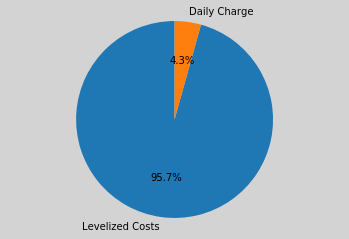

Total roof area of the  building: 599 m2
Total roof area used 586 m2
Percentage: 97.9%
succes
[[252.0976711033341, 189.83921151167112, 246.38691842275034, 23.855815435516515, 33.6090012893606, 24.827739869378398, 0.6350051995825201, 0.5058953714198244, 0.8162150820292859, 3078.22, 296.526, 0.0, 296.526, 0.0, {'Levelized Costs': 2945.16, 'Energy Charge': 0.01800000000014279, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60059514217, 61845.7, 586.142]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (159.46611909034237, 230.4902227715963, 136.00359834701675, 11.41982459166708, 23.387942590246066, 22.6840837171412, 0.6101207842852034, 0.39488111421825356, 0.566583412152559)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 159
                                           a tilt of 11.4
                                           and a gcr of 0.610


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.046550750732422 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 230
                                           a tilt of 23.4
                                           and a gcr of 0.395


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.854689598083496 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 136
                                           a tilt of 22.7
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.843823194503784 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [311.975, 0.0, 0.0]


ERROR:ga_logger:Cost: 3231.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,232 per year


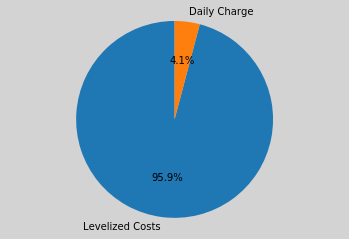

Total roof area of the  building: 599 m2
Total roof area used 511 m2
Percentage: 85.4%
succes
[[159.46611909034237, 230.4902227715963, 136.00359834701675, 11.41982459166708, 23.387942590246066, 22.6840837171412, 0.6101207842852034, 0.39488111421825356, 0.566583412152559, 3231.65, 311.975, 311.975, 0.0, 0.0, {'Levelized Costs': 3098.596, 'Energy Charge': 0.011999999999943611, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60077734475, 61845.7, 511.333]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (200.32177042070444, 142.8288111279262, 195.50268926899022, 45.59175560142608, 40.8809550160355, 22.08847514498778, 0.8670145565014942, 0.8945908385210918, 0.7747538706695538)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 200
                                           a tilt of 45.6
                                           and a gcr of 0.867


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2710154056549072 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 143
                                           a tilt of 40.9
                                           and a gcr of 0.895


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1548421382904053 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 196
                                           a tilt of 22.1
                                           and a gcr of 0.775


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2890682220458984 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 83s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 311.214]


ERROR:ga_logger:Cost: 3224.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,224 per year


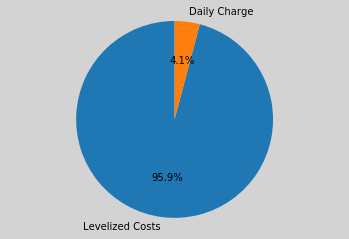

Total roof area of the  building: 599 m2
Total roof area used 402 m2
Percentage: 67.1%
succes
[[200.32177042070444, 142.8288111279262, 195.50268926899022, 45.59175560142608, 40.8809550160355, 22.08847514498778, 0.8670145565014942, 0.8945908385210918, 0.7747538706695538, 3224.09, 311.214, 0.0, 0.0, 311.214, {'Levelized Costs': 3091.0389999999998, 'Energy Charge': 0.0090000000004693, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60159690958, 61845.7, 401.694]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (149.59585176168426, 114.30594149391892, 189.54676345056455, 17.415425459118836, 12.86920137716809, 12.801739612417885, 0.6150225767470855, 0.5182781442077976, 0.427701582385949)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 150
                                           a tilt of 17.4
                                           and a gcr of 0.615


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.288154125213623 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 114
                                           a tilt of 12.9
                                           and a gcr of 0.518


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1614134311676025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 190
                                           a tilt of 12.8
                                           and a gcr of 0.428


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1831977367401123 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 87s


ERROR:ga_logger:panel relevance: [171.914, 0.0, 136.538]


ERROR:ga_logger:Cost: 3196.66


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,197 per year


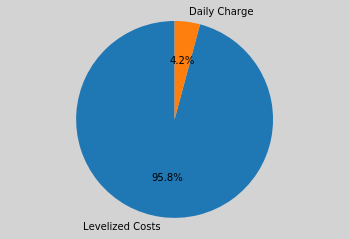

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[149.59585176168426, 114.30594149391892, 189.54676345056455, 17.415425459118836, 12.86920137716809, 12.801739612417885, 0.6150225767470855, 0.5182781442077976, 0.427701582385949, 3196.66, 308.452, 171.914, 0.0, 136.538, {'Levelized Costs': 3063.604, 'Energy Charge': 0.013999999999953161, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60103490343, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (224.35364883370366, 95.69327677611257, 240.62736216434712, 39.70438206263916, 55.6254056045126, 36.65065327243311, 0.7805478444875372, 0.5673390092841881, 0.8394680963178333)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 224
                                           a tilt of 39.7
                                           and a gcr of 0.781


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.339967966079712 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 96
                                           a tilt of 55.6
                                           and a gcr of 0.567


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0284409523010254 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 241
                                           a tilt of 36.7
                                           and a gcr of 0.839


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9631571769714355 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [350.435, 0.0, 0.0]


ERROR:ga_logger:Cost: 3613.65


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,614 per year


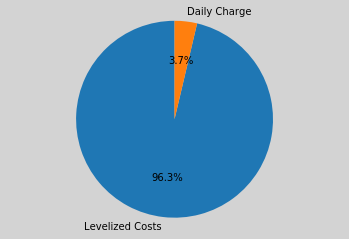

Total roof area of the  building: 599 m2
Total roof area used 449 m2
Percentage: 75.0%
succes
[[224.35364883370366, 95.69327677611257, 240.62736216434712, 39.70438206263916, 55.6254056045126, 36.65065327243311, 0.7805478444875372, 0.5673390092841881, 0.8394680963178333, 3613.65, 350.435, 350.435, 0.0, 0.0, {'Levelized Costs': 3480.597, 'Energy Charge': 0.010999999999796728, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60141249609, 61845.7, 448.961]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (176.33949506955625, 92.39667636684074, 231.29417563439605, 4.233884231635703, 2.7174716914516255, 37.652768575285286, 0.590586778745001, 0.27182228884215043, 0.5320544441400845)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 176
                                           a tilt of 4.2
                                           and a gcr of 0.591


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1153645515441895 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 92
                                           a tilt of 2.7
                                           and a gcr of 0.272


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8576455116271973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 231
                                           a tilt of 37.7
                                           and a gcr of 0.532


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.007577419281006 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 125 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 85s


ERROR:ga_logger:panel relevance: [324.489, 0.0, 0.0]


ERROR:ga_logger:Cost: 3355.94


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,356 per year


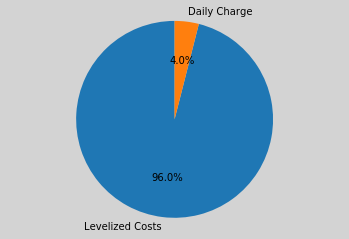

Total roof area of the  building: 599 m2
Total roof area used 549 m2
Percentage: 91.8%
succes
[[176.33949506955625, 92.39667636684074, 231.29417563439605, 4.233884231635703, 2.7174716914516255, 37.652768575285286, 0.590586778745001, 0.27182228884215043, 0.5320544441400845, 3355.94, 324.489, 324.489, 0.0, 0.0, {'Levelized Costs': 3222.884, 'Energy Charge': 0.014000000000123691, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60070571529, 61845.7, 549.434]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (147.61713430331915, 246.84950196738987, 252.89939607949162, 44.85014995000957, 46.078311287438005, 10.002684909635299, 0.8717716661564427, 0.6106406715866102, 0.8922754812421914)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 148
                                           a tilt of 44.9
                                           and a gcr of 0.872


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.2809197902679443 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 46.1
                                           and a gcr of 0.611


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1236133575439453 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 253
                                           a tilt of 10.0
                                           and a gcr of 0.892


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.764755964279175 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 344.136]


ERROR:ga_logger:Cost: 3551.09


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,551 per year


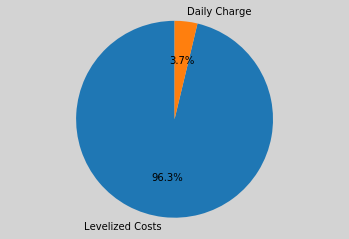

Total roof area of the  building: 599 m2
Total roof area used 386 m2
Percentage: 64.4%
succes
[[147.61713430331915, 246.84950196738987, 252.89939607949162, 44.85014995000957, 46.078311287438005, 10.002684909635299, 0.8717716661564427, 0.6106406715866102, 0.8922754812421914, 3551.09, 344.136, 0.0, 0.0, 344.136, {'Levelized Costs': 3418.038, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59937068993, 61845.7, 385.684]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (101.58451445386942, 159.4765643208089, 237.1351088542639, 3.8522884858882698, 22.385219188517873, 5.618254473612769, 0.4228469129488792, 0.5741506565766938, 0.3848241822005436)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 102
                                           a tilt of 3.9
                                           and a gcr of 0.423


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.1393659114837646 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 159
                                           a tilt of 22.4
                                           and a gcr of 0.574


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.993377923965454 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 237
                                           a tilt of 5.6
                                           and a gcr of 0.385


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.622952461242676 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  11 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 127 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [0.0, 302.506, 0.0]


ERROR:ga_logger:Cost: 3137.61


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,138 per year


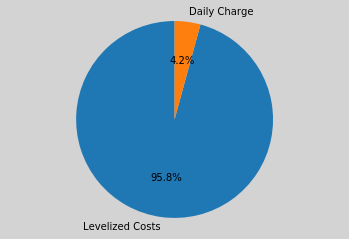

Total roof area of the  building: 599 m2
Total roof area used 527 m2
Percentage: 88.0%
succes
[[101.58451445386942, 159.4765643208089, 237.1351088542639, 3.8522884858882698, 22.385219188517873, 5.618254473612769, 0.4228469129488792, 0.5741506565766938, 0.3848241822005436, 3137.61, 302.506, 0.0, 302.506, 0.0, {'Levelized Costs': 3004.564, 'Energy Charge': 0.004000000000246473, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60109920003, 61845.7, 526.875]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (121.30394579754768, 235.1404468280135, 260.6550267672615, 17.130463861709714, 28.565615280376868, 47.89661609548673, 0.5269551214726924, 0.7721891091375728, 0.818613262696787)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 121
                                           a tilt of 17.1
                                           and a gcr of 0.527


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.09635329246521 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 235
                                           a tilt of 28.6
                                           and a gcr of 0.772


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9994957447052 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 261
                                           a tilt of 47.9
                                           and a gcr of 0.819


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9603941440582275 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 126 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [301.304, 20.8319, 0.0]


ERROR:ga_logger:Cost: 3332.58


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,333 per year


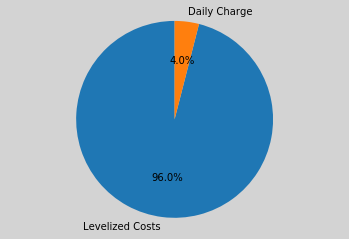

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[121.30394579754768, 235.1404468280135, 260.6550267672615, 17.130463861709714, 28.565615280376868, 47.89661609548673, 0.5269551214726924, 0.7721891091375728, 0.818613262696787, 3332.58, 322.1359, 301.304, 20.8319, 0.0, {'Levelized Costs': 3199.5140000000006, 'Energy Charge': 0.023999999999546162, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.603211310045, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (139.1268119662833, 112.56975154525263, 167.35151365172507, 1.5761117059000442, 21.34721042475441, 20.46127548206201, 0.2619898001752043, 0.3577379247626494, 0.4503346949945896)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 139
                                           a tilt of 1.6
                                           and a gcr of 0.262


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.91288685798645 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 113
                                           a tilt of 21.3
                                           and a gcr of 0.358


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.873972177505493 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 167
                                           a tilt of 20.5
                                           and a gcr of 0.450


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9004180431365967 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [0.0, 0.0, 269.643]


ERROR:ga_logger:Cost: 3570.08


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0123 /kWh
Total Cost of the system: $ 3,570 per year


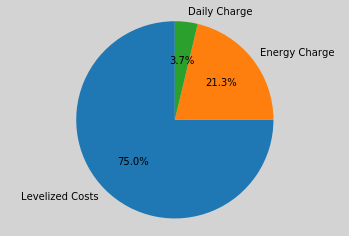

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[139.1268119662833, 112.56975154525263, 167.35151365172507, 1.5761117059000442, 21.34721042475441, 20.46127548206201, 0.2619898001752043, 0.3577379247626494, 0.4503346949945896, 3570.08, 269.643, 0.0, 0.0, 269.643, {'Levelized Costs': 2678.152, 'Energy Charge': 758.886, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55789.121385939936, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (174.44317996221585, 247.14871507920063, 150.95145993409406, 24.96591361689554, 18.512729840613403, 13.354116779267926, 0.7383396178248682, 0.6412918275707091, 0.7768104311003503)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 174
                                           a tilt of 25.0
                                           and a gcr of 0.738


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 3.0761759281158447 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 247
                                           a tilt of 18.5
                                           and a gcr of 0.641


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9586737155914307 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 151
                                           a tilt of 13.4
                                           and a gcr of 0.777


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.919795274734497 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 80s


ERROR:ga_logger:panel relevance: [306.657, 0.0, 0.0]


ERROR:ga_logger:Cost: 3178.84


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,179 per year


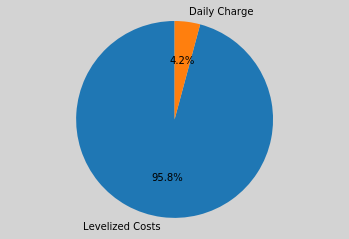

Total roof area of the  building: 599 m2
Total roof area used 415 m2
Percentage: 69.4%
succes
[[174.44317996221585, 247.14871507920063, 150.95145993409406, 24.96591361689554, 18.512729840613403, 13.354116779267926, 0.7383396178248682, 0.6412918275707091, 0.7768104311003503, 3178.84, 306.657, 306.657, 0.0, 0.0, {'Levelized Costs': 3045.783, 'Energy Charge': 0.015000000000327418, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.59943430369, 61845.7, 415.334]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (126.45177049555576, 244.69828902976445, 91.54445758942008, 4.587994384333581, 3.9330910747213883, 53.05535052885819, 0.28792223042352055, 0.5005913815601482, 0.4428820412775769)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 126
                                           a tilt of 4.6
                                           and a gcr of 0.288


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.939159393310547 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 245
                                           a tilt of 3.9
                                           and a gcr of 0.501


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8198773860931396 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 92
                                           a tilt of 53.1
                                           and a gcr of 0.443


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8626317977905273 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 76s


ERROR:ga_logger:panel relevance: [0.0, 299.735, 0.0]


ERROR:ga_logger:Cost: 3872.62


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0123 /kWh
Total Cost of the system: $ 3,873 per year


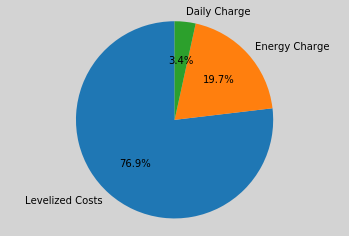

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[126.45177049555576, 244.69828902976445, 91.54445758942008, 4.587994384333581, 3.9330910747213883, 53.05535052885819, 0.28792223042352055, 0.5005913815601482, 0.4428820412775769, 3872.62, 299.735, 0.0, 299.735, 0.0, {'Levelized Costs': 2977.031, 'Energy Charge': 762.5469999999999, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 55759.88693450538, 61845.7, 598.762]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (190.69665144367508, 135.9239552766959, 160.9864065940801, 38.032328850084, 51.96133879624366, 21.08201812329369, 0.7935063596245218, 0.8367277674852355, 0.8989584221349599)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 191
                                           a tilt of 38.0
                                           and a gcr of 0.794


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9450955390930176 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 136
                                           a tilt of 52.0
                                           and a gcr of 0.837


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.79923415184021 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 161
                                           a tilt of 21.1
                                           and a gcr of 0.899


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8307900428771973 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 82s


ERROR:ga_logger:panel relevance: [317.218, 0.0, 0.0]


ERROR:ga_logger:Cost: 3283.72


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0000 /kWh
Total Cost of the system: $ 3,284 per year


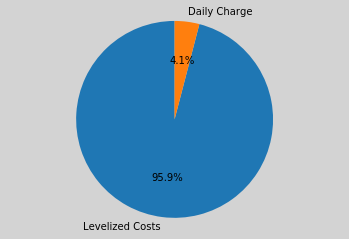

Total roof area of the  building: 599 m2
Total roof area used 400 m2
Percentage: 66.8%
succes
[[190.69665144367508, 135.9239552766959, 160.9864065940801, 38.032328850084, 51.96133879624366, 21.08201812329369, 0.7935063596245218, 0.8367277674852355, 0.8989584221349599, 3283.72, 317.218, 317.218, 0.0, 0.0, {'Levelized Costs': 3150.668, 'Energy Charge': 0.009999999999990905, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 61845.60086831785, 61845.7, 399.767]]


The maximum power used is 16 kW
The minimum power used is 2 kW
The average power used is 7 kW
The total Electricity use is 61,846 kWh or 62 MWh
This building is **Small General Service** Rate
The maximum demand charge is: $ 2,059.63


ERROR:ga_logger:panel values: (138.05225074572257, 131.80366970657798, 159.5860897132943, 17.49569046991295, 52.352342312576376, 6.910723502581531, 0.4924778103441038, 0.5328247428925547, 0.20275066073893522)


ERROR:ga_logger:price of the panel 106


ERROR:ga_logger:Start Evaluation


ERROR:ga_logger:Compiling and setting: Irra0 based on:
                                           an Azimuth of 138
                                           a tilt of 17.5
                                           and a gcr of 0.492


Found the solver set


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.9209160804748535 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra1 based on:
                                           an Azimuth of 132
                                           a tilt of 52.4
                                           and a gcr of 0.533


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.8152220249176025 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Compiling and setting: Irra2 based on:
                                           an Azimuth of 160
                                           a tilt of 6.9
                                           and a gcr of 0.203


ERROR:root:Started Generation of Irradiance


INFO:pvfactors.run:Parallel calculation elapsed time: 2.7780203819274902 sec


ERROR:root:Finished Generation of Irradiance


ERROR:ga_logger:Generated the panel irradiance in  10 s


ERROR:ga_logger:Starting recompile


ERROR:ga_logger:Recompiled the model in 124 s


ERROR:ga_logger:Starting solver


ERROR:ga_logger:Solved the model in 74s


ERROR:ga_logger:panel relevance: [294.877, 0.0, 0.0]


ERROR:ga_logger:Cost: 3452.22


ERROR:ga_logger:total demand cost: 0.0


ERROR:ga_logger:total daily cost: 133.042


Total Electricity Imported from the grid 61,846 kWh
At a cost of $ 0.0063 /kWh
Total Cost of the system: $ 3,452 per year


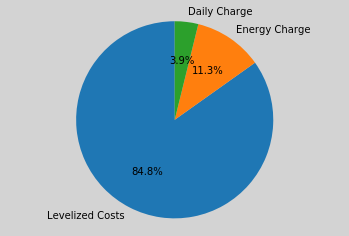

Total roof area of the  building: 599 m2
Total roof area used 599 m2
Percentage: 100.0%
succes
[[138.05225074572257, 131.80366970657798, 159.5860897132943, 17.49569046991295, 52.352342312576376, 6.910723502581531, 0.4924778103441038, 0.5328247428925547, 0.20275066073893522, 3452.22, 294.877, 294.877, 0.0, 0.0, {'Levelized Costs': 2928.774, 'Energy Charge': 390.404, 'Demand Charge': 0.0, 'Daily Charge': 133.042}, 58729.93636651005, 61845.7, 598.762]]


ERROR:optimizer_logger:200


ERROR:optimizer_logger:{'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:optimizer_logger:Finished and stored: {'building_idf': 'energy_plus/input_building/idf/upgraded/RefBldgSmallOfficeNew2004_v1.4_7.2_5A_USA_IL_CHICAGO-OHARE.idf', 'price': 106}


ERROR:Runs_logger:Run nr 0 using opt-method ga-100 with 200 evalautions took: (min)


ERROR:Runs_logger:988.8104534745216


In [29]:
# GA
if (opt_method =="ga-20"):
    init_pop=20
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-50"):
    init_pop=50
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="ga-100"):
    init_pop=100
    pvoptimizer.runGA(number_of_opt_evaluations,init_pop, model="BC", obj="DUAL")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-net"):
    # implementation of the max_evaluations only works starting from 6 or higher
    # also if you set this max_evalutions to 10 it will stop after 9 evaluations
    # therefore I have added 1 to the max_evaluations. 
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE-NET")
    pvoptimizer.processGA(ga_fina)
elif(opt_method=="rbf-cost"):
    pvoptimizer.runRBFOPT(number_of_opt_evaluations, model="BC", obj="SINGLE")
    pvoptimizer.processGA(ga_fina)

# runtime in seconds
endtime=time.time()-t1
mintime=endtime/60
lrun.error("Run nr {} using opt-method {} with {} evalautions took: (min)".format(run_i,opt_method,number_of_opt_evaluations))
lrun.error(mintime)